In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

import torch
from torch import nn

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from multiclass_performanceMetrics import *
from dataMining_functions import *
from neuralNet_functions import *
from nested_design_analysis import *

In [3]:
from imblearn.over_sampling import SMOTE

In [4]:
# load csv files containing slope of wavelet decomposition extracted from data based on discrete wavelet transform
slope_m = pd.read_csv('features/window512_neuron_slope_rowwindow_Molino.csv', header=None)
slope_p = pd.read_csv('features/window512_neuron_slope_rowwindow_Pachon.csv', header=None)
slope_s = pd.read_csv('features/window512_neuron_slope_rowwindow_Surface.csv', header=None)

In [5]:
slope_m

,0,1,2,3,4,5,6,7,8,9,...,869,870,871,872,873,874,875,876,877,878
0,-0.067605,-0.118922,-0.094129,0.066032,-0.238939,0.254376,-0.040246,-0.523493,0.087673,0.015258,...,0,0,0,0,0,0,0,0,0,0
1,0.332007,-0.134249,-0.199915,0.160182,-0.087102,0.085284,-0.115161,-0.078553,-0.028346,0.131704,...,0,0,0,0,0,0,0,0,0,0
2,-0.038976,-0.040227,0.055008,-0.038261,-0.154654,0.070836,-0.114923,0.036480,0.135799,0.022447,...,0,0,0,0,0,0,0,0,0,0
3,0.212578,0.135834,-0.017293,-0.067745,0.269292,-0.100228,0.107695,-0.215125,0.118761,-0.020157,...,0,0,0,0,0,0,0,0,0,0
4,-0.162624,-0.076423,-0.017957,0.056792,-0.081956,-0.101262,-0.147040,0.138392,0.080331,-0.032050,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,-0.066847,0.015115,-0.005959,0.140707,-0.069607,-0.107607,-0.848645,-0.110150,-0.414189,0.010325,...,0,0,0,0,0,0,0,0,0,0
172,0.016731,-0.081127,0.099292,-0.113153,0.166376,0.124942,-0.647028,-0.153044,-0.502469,-0.102382,...,0,0,0,0,0,0,0,0,0,0
173,0.065406,-0.255316,-0.078730,-0.139135,-0.008821,-0.238510,-0.553786,-0.415466,-0.494167,-0.203211,...,0,0,0,0,0,0,0,0,0,0
174,-0.180683,-0.158076,-0.078359,-0.168406,0.140557,-0.090916,-0.817421,-0.217100,0.018712,0.150379,...,0,0,0,0,0,0,0,0,0,0


In [7]:
min_col = 275  # minimum number of neurons of a fish in the data

# slicing the data set
slope_m = slope_m.iloc[:, :min_col]
slope_p = slope_p.iloc[:, :min_col]
slope_s = slope_s.iloc[:, :min_col]

# compute Hurst exponent
slope_m = (slope_m + 1)/2
slope_p = (slope_p + 1)/2
slope_s = (slope_s + 1)/2


# class lables
# molino = 0, pachon = 1, surface = 2
slope_m['class'] = 0
slope_p['class'] = 1
slope_s['class'] = 2
num_class = 3





In [8]:
slope_m.shape, slope_p.shape, slope_s.shape

((176, 276), (176, 276), (121, 276))

In [9]:
# get the number of nonoverlapping window obtained from the neural signal
num_window = slope_m.shape[0] / 16  # 16 is the number of fishes in molino group in the dataset
num_window

11.0

In [10]:
# combine all fish classes datasets
df = pd.concat([slope_m, slope_p], axis=0)
df = pd.concat([df, slope_s], axis=0)

In [11]:
# apply balanced nested design to the dataset
# to break the dependency caused by subjects(fishes) on the neural signals of a fish
balanced_nested_df = balanced_nested_design_sampling(df, num_window=num_window)

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

# Classifications

In [12]:
# shuffle data set for more randomness during training
balanced_nested_df = balanced_nested_df.sample(frac=1)
balanced_nested_df.head()

,0,1,2,3,4,5,6,7,8,9,...,266,267,268,269,270,271,272,273,274,class
354,0.753675,0.775157,0.746274,0.759329,0.778181,0.758676,0.753935,0.769986,0.748658,0.508121,...,0.536662,0.738389,0.478835,0.633533,0.362533,0.560747,0.799004,0.732729,0.258900,2
105,0.699479,0.707503,0.690006,0.677856,0.721376,0.716001,0.711474,0.705339,0.692454,0.718268,...,0.705747,0.718016,0.771827,0.656295,0.636589,0.648954,0.699661,0.726450,0.714853,0
21,0.757320,0.798367,0.758067,0.706956,0.758351,0.731182,0.727433,0.804297,0.745428,0.679017,...,0.701261,0.668106,0.828725,0.384581,0.776205,0.680453,0.365834,0.459746,0.736056,0
44,0.782812,0.779845,0.747288,0.707806,0.727818,0.783616,0.659902,0.756293,0.721069,0.753314,...,0.796387,0.762429,0.763007,0.716985,0.773121,0.761745,0.606911,0.745942,0.647902,0
130,0.749819,0.655984,0.697889,0.693018,0.713902,0.670998,0.714278,0.674966,0.634233,0.775648,...,0.337987,0.648131,0.729493,0.514861,0.691916,0.679083,0.525599,0.487943,0.541493,1


In [14]:
# train and test data split
X, y = balanced_nested_df.drop(labels='class', axis=1), balanced_nested_df['class']
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
# Apply SMOTE to balance the training data
# sometimes random train and test data split causes minor data imbalance
# not a big issue, but used SMOTE just in case
#sm = SMOTE(random_state=42, k_neighbors=12)
#X_train, y_train = sm.fit_resample(X_train, y_train)

In [16]:
def SMOTE_oversample(data):
    # param: data is a dataframe (normally training data) where the target feature is in the last column
    # return balanced data by applying SMOTE oversampling technique
    # this function will be used in repeat_sampling_and_training function
    #             to apply data preprocessing for every sample
    X, y = data.iloc[:,:-1], data.iloc[:,-1]
    sm = SMOTE(random_state=42, k_neighbors=12)
    X, y = sm.fit_resample(X, y)
    df = pd.concat([X, y], axis=1)
    df = df.sample(frac=1)
    return df

Feedforward Neural Network

In [17]:
# check whether a GPU is available and set the device to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [18]:
# split data into train and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=3)
# Apply SMOTE to balance the training data
# sometimes random train and test data split causes minor data imbalance
# not a big issue, but used SMOTE just in case
sm = SMOTE(random_state=42, k_neighbors=12)
X_train, y_train = sm.fit_resample(X_train, y_train)
print(y_train.value_counts())

# form a pair of dataset and corresponding class labels
test_np = np.array(pd.concat([X_test, y_test], axis=1))
train_np = np.array(pd.concat([X_train, y_train], axis=1))
val_np = np.array(pd.concat([X_val, y_val], axis=1))

1    79
0    79
2    79
Name: class, dtype: int64


In [19]:
# simple feedforward NN
input_d = X_train.shape[1]
output_d = len(y_train.unique())
is_dropOut=True  # True means dropout layers will be applied
is_batchNorm=True  # True means batch norm will be applied
layers_dim = [input_d//3, input_d//9, input_d//27]  # dimension of NN layers excluding output layer
activations = [nn.ReLU(), nn.LeakyReLU(), nn.LeakyReLU()]  # activation functions for hidden layers
model = simpleNN(input_d, output_d, is_dropOut, is_batchNorm,
                 layers_dim=layers_dim, activations=activations)

In [20]:
model

simpleNN(
  (dropout): Dropout(p=0.2, inplace=False)
  (layer1): Sequential(
    (0): Linear(in_features=275, out_features=91, bias=True)
    (1): BatchNorm1d(91, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (hidden_layers): Sequential(
    (hidden1): Sequential(
      (0): Linear(in_features=91, out_features=30, bias=True)
      (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (hidden2): Sequential(
      (0): Linear(in_features=30, out_features=10, bias=True)
      (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (output_layer): Linear(in_features=10, out_features=3, bias=True)
)

In [23]:
# hyper params
n_epochs=500  # number of epochs
lr=0.0005  # learning rate
loss_f = nn.CrossEntropyLoss()  # loss function
loss_f.float()
weight_decay=0.25
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # optimizer

In [24]:
# training a feedforward neural network
es = simpleEarlyStopping(patience=20)
train_res = train(model, train_np, val_np, optimizer=optimizer, loss_f=loss_f,
            batch_size=64, epochs=n_epochs, ES=es, is_binary=False)

Epoch 10/500
Train Loss: 0.7523	Train Accuracy: 0.8534
Validation Loss: 0.9018	Validation Accuracy: 0.6552
Epoch 20/500
Train Loss: 0.6240	Train Accuracy: 0.9570
Validation Loss: 0.7921	Validation Accuracy: 0.7069
Epoch 30/500
Train Loss: 0.5566	Train Accuracy: 0.9827
Validation Loss: 0.6569	Validation Accuracy: 0.8276
Epoch 40/500
Train Loss: 0.5127	Train Accuracy: 0.9961
Validation Loss: 0.6083	Validation Accuracy: 0.9310
Epoch 50/500
Train Loss: 0.4874	Train Accuracy: 0.9922
Validation Loss: 0.5344	Validation Accuracy: 0.9483
Epoch 60/500
Train Loss: 0.4775	Train Accuracy: 0.9961
Validation Loss: 0.4812	Validation Accuracy: 0.9655
Epoch 70/500
Train Loss: 0.4180	Train Accuracy: 1.0000
Validation Loss: 0.4771	Validation Accuracy: 0.9655
Epoch 80/500
Train Loss: 0.4095	Train Accuracy: 1.0000
Validation Loss: 0.4582	Validation Accuracy: 0.9828
Epoch 90/500
Train Loss: 0.3947	Train Accuracy: 1.0000
Validation Loss: 0.4253	Validation Accuracy: 1.0000
Epoch 100/500
Train Loss: 0.3954	Trai

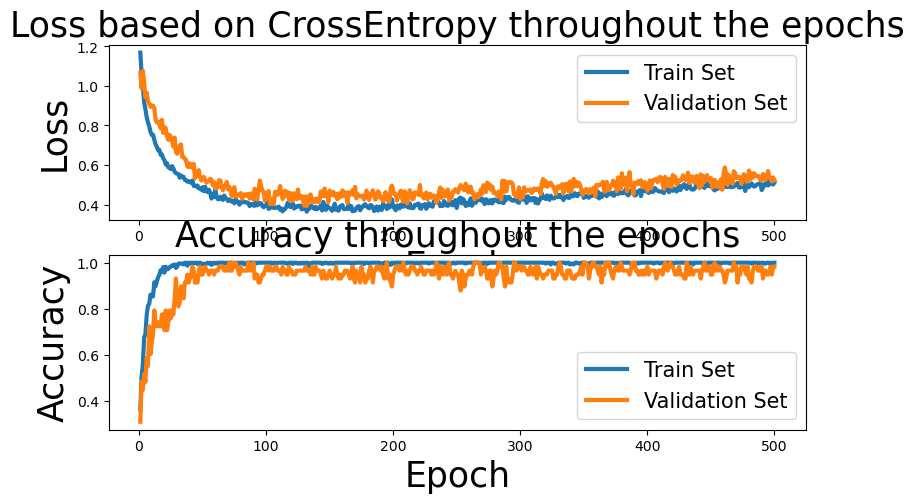

In [25]:
# plot training history
train_loss, val_loss, train_acc, val_acc = train_res
loss_fname = "CrossEntropy"
visualize_train_log(train_loss, val_loss, train_acc, val_acc, loss_fname)

In [26]:
# evaluate the model performance on training and testing data
train_true, train_pred = test(model, train_np, batch_size=512)
target_names = ['Molino', 'Pachon', 'Surface']
print(classification_report(train_true, train_pred, target_names=target_names))
confusion_matrix(train_true, train_pred)

              precision    recall  f1-score   support

      Molino       1.00      0.99      0.99        79
      Pachon       1.00      0.99      0.99        79
     Surface       0.98      1.00      0.99        79

    accuracy                           0.99       237
   macro avg       0.99      0.99      0.99       237
weighted avg       0.99      0.99      0.99       237



array([[78,  0,  1],
       [ 0, 78,  1],
       [ 0,  0, 79]])

In [27]:
test_true, test_pred = test(model, test_np, batch_size=512)
target_names = ['Molino', 'Pachon', 'Surface']
print(classification_report(test_true, test_pred, target_names=target_names))
confusion_matrix(test_true, test_pred)

              precision    recall  f1-score   support

      Molino       0.96      0.86      0.91        28
      Pachon       1.00      0.83      0.90        23
     Surface       0.76      1.00      0.86        22

    accuracy                           0.89        73
   macro avg       0.91      0.89      0.89        73
weighted avg       0.91      0.89      0.89        73



array([[24,  0,  4],
       [ 1, 19,  3],
       [ 0,  0, 22]])

In [28]:
def build_simpleNN(params):
    input_d, output_d, is_dropOut,is_batchNorm, layers_dim, activations = args
    model = simpleNN(input_d, output_d, is_dropOut, is_batchNorm,
                 layers_dim=layers_dim, activations=activations)
    return model

args = [input_d, output_d, is_dropOut,is_batchNorm, layers_dim, activations]

model_f = build_simpleNN

# random sampling and train a new model
# to more accurately test our model performace indepedent of particular samples
# Similar to the idea of K-fold cross validation
predictors = list(df.drop(labels='class', axis=1).columns)  # names of the features
res = repeat_sampling_and_trainingNN(model_f, args, df,
                                  'class', predictors, num_repeat=100, doMinMaxScaling=False,
                                  #num_window=num_window,
                                     data_processing_f=balanced_nested_design_sampling,
                                  is_oversample=True, oversample_f=SMOTE_oversample,
                                    train_f = train, test_f = test, epochs=100)

Epoch 10/100
Train Loss: 0.9009	Train Accuracy: 0.7079
Validation Loss: 0.9802	Validation Accuracy: 0.5345


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7989	Train Accuracy: 0.8169
Validation Loss: 0.8976	Validation Accuracy: 0.6897
Epoch 30/100
Train Loss: 0.6902	Train Accuracy: 0.9167
Validation Loss: 0.8162	Validation Accuracy: 0.8103
Epoch 40/100
Train Loss: 0.6461	Train Accuracy: 0.9882
Validation Loss: 0.7567	Validation Accuracy: 0.9138
Epoch 50/100
Train Loss: 0.5743	Train Accuracy: 0.9919
Validation Loss: 0.6231	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.5351	Train Accuracy: 0.9960
Validation Loss: 0.5982	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.5094	Train Accuracy: 0.9960
Validation Loss: 0.5544	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.4758	Train Accuracy: 1.0000
Validation Loss: 0.5498	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4458	Train Accuracy: 0.9960
Validation Loss: 0.5194	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4502	Train Accuracy: 1.0000
Validation Loss: 0.4593	Validation Accuracy: 1.0000
[[29  0  0]
 [ 0 21  0]
 [ 0  0 23]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6933	Train Accuracy: 0.8421
Validation Loss: 0.8707	Validation Accuracy: 0.7069
Epoch 30/100
Train Loss: 0.5952	Train Accuracy: 0.8884
Validation Loss: 0.7215	Validation Accuracy: 0.7586
Epoch 40/100
Train Loss: 0.5815	Train Accuracy: 0.9386
Validation Loss: 0.7595	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.5278	Train Accuracy: 0.9827
Validation Loss: 0.6821	Validation Accuracy: 0.8448
Epoch 60/100
Train Loss: 0.4808	Train Accuracy: 0.9754
Validation Loss: 0.5635	Validation Accuracy: 0.8793
Epoch 70/100
Train Loss: 0.4480	Train Accuracy: 0.9916
Validation Loss: 0.5513	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.4306	Train Accuracy: 0.9682
Validation Loss: 0.4868	Validation Accuracy: 0.9310
Epoch 90/100
Train Loss: 0.4150	Train Accuracy: 0.9833
Validation Loss: 0.4376	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4042	Train Accuracy: 0.9872
Validation Loss: 0.4638	Validation Accuracy: 0.9483
[[21  0  1]
 [ 0 25  0]
 [ 0  0 26]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6735	Train Accuracy: 0.9001
Validation Loss: 0.7688	Validation Accuracy: 0.8621
Epoch 30/100
Train Loss: 0.5951	Train Accuracy: 0.9581
Validation Loss: 0.6967	Validation Accuracy: 0.8276
Epoch 40/100
Train Loss: 0.5475	Train Accuracy: 0.9805
Validation Loss: 0.5867	Validation Accuracy: 0.9483
Epoch 50/100
Train Loss: 0.4982	Train Accuracy: 0.9883
Validation Loss: 0.5599	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.4746	Train Accuracy: 0.9916
Validation Loss: 0.5261	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.4634	Train Accuracy: 0.9883
Validation Loss: 0.4586	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4029	Train Accuracy: 0.9866
Validation Loss: 0.4769	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4457	Train Accuracy: 0.9955
Validation Loss: 0.4628	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4043	Train Accuracy: 0.9827
Validation Loss: 0.3993	Validation Accuracy: 1.0000
[[21  0  0]
 [ 0 26  1]
 [ 0  0 25]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.8077	Train Accuracy: 0.6904
Validation Loss: 0.8745	Validation Accuracy: 0.6379
Epoch 30/100
Train Loss: 0.7241	Train Accuracy: 0.8118
Validation Loss: 0.8207	Validation Accuracy: 0.6724
Epoch 40/100
Train Loss: 0.6945	Train Accuracy: 0.8861
Validation Loss: 0.7404	Validation Accuracy: 0.7931
Epoch 50/100
Train Loss: 0.6538	Train Accuracy: 0.9568
Validation Loss: 0.7106	Validation Accuracy: 0.8621
Epoch 60/100
Train Loss: 0.5864	Train Accuracy: 0.9608
Validation Loss: 0.6589	Validation Accuracy: 0.9138
Epoch 70/100
Train Loss: 0.5530	Train Accuracy: 0.9686
Validation Loss: 0.6154	Validation Accuracy: 0.9138
Epoch 80/100
Train Loss: 0.5378	Train Accuracy: 0.9804
Validation Loss: 0.5551	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.5203	Train Accuracy: 0.9764
Validation Loss: 0.5167	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4900	Train Accuracy: 0.9882
Validation Loss: 0.4695	Validation Accuracy: 0.9828
[[23  0  1]
 [ 0 33  0]
 [ 0  0 16]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7806	Train Accuracy: 0.7150
Validation Loss: 0.8398	Validation Accuracy: 0.6724
Epoch 30/100
Train Loss: 0.7166	Train Accuracy: 0.8106
Validation Loss: 0.8118	Validation Accuracy: 0.6897
Epoch 40/100
Train Loss: 0.6539	Train Accuracy: 0.8627
Validation Loss: 0.6987	Validation Accuracy: 0.7931
Epoch 50/100
Train Loss: 0.6157	Train Accuracy: 0.9214
Validation Loss: 0.6673	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.5692	Train Accuracy: 0.9548
Validation Loss: 0.6005	Validation Accuracy: 0.9138
Epoch 70/100
Train Loss: 0.5103	Train Accuracy: 0.9957
Validation Loss: 0.5168	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4681	Train Accuracy: 0.9917
Validation Loss: 0.4734	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4338	Train Accuracy: 0.9878
Validation Loss: 0.4475	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4277	Train Accuracy: 1.0000
Validation Loss: 0.4563	Validation Accuracy: 0.9828
[[29  0  0]
 [ 0 22  0]
 [ 0  0 22]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.8261	Train Accuracy: 0.6875
Validation Loss: 0.8477	Validation Accuracy: 0.6724
Epoch 30/100
Train Loss: 0.7421	Train Accuracy: 0.7109
Validation Loss: 0.7461	Validation Accuracy: 0.6897
Epoch 40/100
Train Loss: 0.9225	Train Accuracy: 0.7370
Validation Loss: 0.7150	Validation Accuracy: 0.7586
Epoch 50/100
Train Loss: 0.7694	Train Accuracy: 0.7682
Validation Loss: 0.6944	Validation Accuracy: 0.7759
Epoch 60/100
Train Loss: 0.7170	Train Accuracy: 0.7656
Validation Loss: 0.6702	Validation Accuracy: 0.7931
Epoch 70/100
Train Loss: 0.6373	Train Accuracy: 0.9531
Validation Loss: 0.6398	Validation Accuracy: 0.8966
Epoch 80/100
Train Loss: 0.5830	Train Accuracy: 0.9453
Validation Loss: 0.6363	Validation Accuracy: 0.8103
Epoch 90/100
Train Loss: 0.6364	Train Accuracy: 0.7630
Validation Loss: 0.6199	Validation Accuracy: 0.8966
Epoch 100/100
Train Loss: 0.6695	Train Accuracy: 0.6094
Validation Loss: 0.6618	Validation Accuracy: 0.8103
[[29  0  0]
 [ 0 26  1]
 [ 1  0 16]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6817	Train Accuracy: 0.8281
Validation Loss: 0.8004	Validation Accuracy: 0.6724
Epoch 30/100
Train Loss: 0.6077	Train Accuracy: 0.8811
Validation Loss: 0.7360	Validation Accuracy: 0.7586
Epoch 40/100
Train Loss: 0.5265	Train Accuracy: 0.9498
Validation Loss: 0.6838	Validation Accuracy: 0.7759
Epoch 50/100
Train Loss: 0.4921	Train Accuracy: 0.9710
Validation Loss: 0.6563	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.4515	Train Accuracy: 0.9833
Validation Loss: 0.6150	Validation Accuracy: 0.8448
Epoch 70/100
Train Loss: 0.4494	Train Accuracy: 0.9911
Validation Loss: 0.5295	Validation Accuracy: 0.8793
Epoch 80/100
Train Loss: 0.4190	Train Accuracy: 0.9794
Validation Loss: 0.4957	Validation Accuracy: 0.8448
Epoch 90/100
Train Loss: 0.4008	Train Accuracy: 0.9877
Validation Loss: 0.5298	Validation Accuracy: 0.9138
Epoch 100/100
Train Loss: 0.4019	Train Accuracy: 0.9955
Validation Loss: 0.4729	Validation Accuracy: 0.9138
[[23  0  0]
 [ 3 20  0]
 [ 0  0 27]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7559	Train Accuracy: 0.8775
Validation Loss: 0.8005	Validation Accuracy: 0.7931
Epoch 30/100
Train Loss: 0.6777	Train Accuracy: 0.9413
Validation Loss: 0.7316	Validation Accuracy: 0.8448
Epoch 40/100
Train Loss: 0.5850	Train Accuracy: 0.9752
Validation Loss: 0.6380	Validation Accuracy: 0.9655
Epoch 50/100
Train Loss: 0.5434	Train Accuracy: 0.9896
Validation Loss: 0.5605	Validation Accuracy: 0.9655
Epoch 60/100
Train Loss: 0.5158	Train Accuracy: 0.9726
Validation Loss: 0.5072	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.4683	Train Accuracy: 1.0000
Validation Loss: 0.4884	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4268	Train Accuracy: 0.9948
Validation Loss: 0.4785	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4206	Train Accuracy: 0.9974
Validation Loss: 0.5021	Validation Accuracy: 0.9483
Epoch 100/100
Train Loss: 0.4370	Train Accuracy: 1.0000
Validation Loss: 0.4263	Validation Accuracy: 0.9828
[[15  0  0]
 [ 0 30  1]
 [ 0  0 27]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6580	Train Accuracy: 0.8771
Validation Loss: 0.7934	Validation Accuracy: 0.6724
Epoch 30/100
Train Loss: 0.5782	Train Accuracy: 0.9603
Validation Loss: 0.7688	Validation Accuracy: 0.8276
Epoch 40/100
Train Loss: 0.5098	Train Accuracy: 0.9680
Validation Loss: 0.6618	Validation Accuracy: 0.8276
Epoch 50/100
Train Loss: 0.4751	Train Accuracy: 0.9684
Validation Loss: 0.5640	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.4419	Train Accuracy: 0.9921
Validation Loss: 0.5154	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.4372	Train Accuracy: 0.9842
Validation Loss: 0.4724	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4115	Train Accuracy: 0.9839
Validation Loss: 0.4315	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.3934	Train Accuracy: 0.9840
Validation Loss: 0.4225	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3688	Train Accuracy: 0.9960
Validation Loss: 0.4003	Validation Accuracy: 1.0000
[[21  0  0]
 [ 0 23  0]
 [ 2  0 27]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8331	Train Accuracy: 0.8125
Validation Loss: 0.8828	Validation Accuracy: 0.6379
Epoch 20/100
Train Loss: 0.7136	Train Accuracy: 0.9040
Validation Loss: 0.8223	Validation Accuracy: 0.7241
Epoch 30/100
Train Loss: 0.6605	Train Accuracy: 0.9497
Validation Loss: 0.7526	Validation Accuracy: 0.8621
Epoch 40/100
Train Loss: 0.6025	Train Accuracy: 0.9869
Validation Loss: 0.7042	Validation Accuracy: 0.8966
Epoch 50/100
Train Loss: 0.5663	Train Accuracy: 0.9961
Validation Loss: 0.6876	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.5352	Train Accuracy: 1.0000
Validation Loss: 0.5974	Validation Accuracy: 0.9828
Epoch 70/100
Train Loss: 0.5046	Train Accuracy: 1.0000
Validation Loss: 0.5780	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.5030	Train Accuracy: 0.9961
Validation Loss: 0.5555	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4865	Train Accuracy: 1.0000
Validation Loss: 0.5206	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4707	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8078	Train Accuracy: 0.6661
Validation Loss: 0.8971	Validation Accuracy: 0.6207
Epoch 20/100
Train Loss: 0.6918	Train Accuracy: 0.8088
Validation Loss: 0.7432	Validation Accuracy: 0.7414
Epoch 30/100
Train Loss: 0.6124	Train Accuracy: 0.8626
Validation Loss: 0.6943	Validation Accuracy: 0.7414
Epoch 40/100
Train Loss: 0.5389	Train Accuracy: 0.8941
Validation Loss: 0.6386	Validation Accuracy: 0.8793
Epoch 50/100
Train Loss: 0.5055	Train Accuracy: 0.9111
Validation Loss: 0.5713	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.4420	Train Accuracy: 0.9554
Validation Loss: 0.4975	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.4138	Train Accuracy: 0.9717
Validation Loss: 0.4308	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.4035	Train Accuracy: 0.9762
Validation Loss: 0.4430	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.3663	Train Accuracy: 0.9961
Validation Loss: 0.4000	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.3854	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8160	Train Accuracy: 0.7320
Validation Loss: 0.8875	Validation Accuracy: 0.6034
Epoch 20/100
Train Loss: 0.7236	Train Accuracy: 0.8445
Validation Loss: 0.7804	Validation Accuracy: 0.7414
Epoch 30/100
Train Loss: 0.6391	Train Accuracy: 0.9279
Validation Loss: 0.7476	Validation Accuracy: 0.8103
Epoch 40/100
Train Loss: 0.5659	Train Accuracy: 0.9440
Validation Loss: 0.6526	Validation Accuracy: 0.9138
Epoch 50/100
Train Loss: 0.5148	Train Accuracy: 0.9835
Validation Loss: 0.6100	Validation Accuracy: 0.9483
Epoch 60/100
Train Loss: 0.4921	Train Accuracy: 0.9881
Validation Loss: 0.6057	Validation Accuracy: 0.9828
Epoch 70/100
Train Loss: 0.4433	Train Accuracy: 0.9876
Validation Loss: 0.5758	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4249	Train Accuracy: 0.9959
Validation Loss: 0.4426	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4078	Train Accuracy: 0.9959
Validation Loss: 0.4780	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4000	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.8791	Train Accuracy: 0.5552
Validation Loss: 0.9290	Validation Accuracy: 0.5862
Epoch 30/100
Train Loss: 0.8307	Train Accuracy: 0.6239
Validation Loss: 0.8465	Validation Accuracy: 0.6724
Epoch 40/100
Train Loss: 0.7583	Train Accuracy: 0.6518
Validation Loss: 0.8051	Validation Accuracy: 0.7414
Epoch 50/100
Train Loss: 0.7058	Train Accuracy: 0.6685
Validation Loss: 0.7057	Validation Accuracy: 0.7759
Epoch 60/100
Train Loss: 0.6828	Train Accuracy: 0.6641
Validation Loss: 0.6992	Validation Accuracy: 0.7759
Epoch 70/100
Train Loss: 0.6539	Train Accuracy: 0.7812
Validation Loss: 0.6302	Validation Accuracy: 0.8793
Epoch 80/100
Train Loss: 0.6236	Train Accuracy: 0.9805
Validation Loss: 0.5869	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.5998	Train Accuracy: 0.9794
Validation Loss: 0.5517	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.5974	Train Accuracy: 0.9955
Validation Loss: 0.5496	Validation Accuracy: 0.9828
[[17  0  0]
 [ 0 33  0]
 [ 0  0 23]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7112	Train Accuracy: 0.8811
Validation Loss: 0.8126	Validation Accuracy: 0.7241
Epoch 30/100
Train Loss: 0.6513	Train Accuracy: 0.9838
Validation Loss: 0.7295	Validation Accuracy: 0.9310
Epoch 40/100
Train Loss: 0.5931	Train Accuracy: 0.9794
Validation Loss: 0.6407	Validation Accuracy: 0.9828
Epoch 50/100
Train Loss: 0.5597	Train Accuracy: 0.9833
Validation Loss: 0.6354	Validation Accuracy: 0.9655
Epoch 60/100
Train Loss: 0.5290	Train Accuracy: 0.9955
Validation Loss: 0.5627	Validation Accuracy: 0.9828
Epoch 70/100
Train Loss: 0.4911	Train Accuracy: 1.0000
Validation Loss: 0.5220	Validation Accuracy: 1.0000
Epoch 80/100
Train Loss: 0.4744	Train Accuracy: 1.0000
Validation Loss: 0.4821	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4343	Train Accuracy: 1.0000
Validation Loss: 0.4484	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4160	Train Accuracy: 0.9916
Validation Loss: 0.4284	Validation Accuracy: 1.0000
[[21  0  0]
 [ 0 23  0]
 [ 0  0 29]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7024	Train Accuracy: 0.8266
Validation Loss: 0.8519	Validation Accuracy: 0.6207
Epoch 30/100
Train Loss: 0.8601	Train Accuracy: 0.6734
Validation Loss: 0.7581	Validation Accuracy: 0.7931
Epoch 40/100
Train Loss: 0.6213	Train Accuracy: 0.9583
Validation Loss: 0.7111	Validation Accuracy: 0.7414
Epoch 50/100
Train Loss: 0.5997	Train Accuracy: 0.9229
Validation Loss: 0.6537	Validation Accuracy: 0.8621
Epoch 60/100
Train Loss: 0.6558	Train Accuracy: 0.9151
Validation Loss: 0.6548	Validation Accuracy: 0.8448
Epoch 70/100
Train Loss: 0.5714	Train Accuracy: 0.9792
Validation Loss: 0.5945	Validation Accuracy: 0.9138
Epoch 80/100
Train Loss: 0.6156	Train Accuracy: 0.7948
Validation Loss: 0.5529	Validation Accuracy: 0.9310
Epoch 90/100
Train Loss: 0.4513	Train Accuracy: 0.9896
Validation Loss: 0.5327	Validation Accuracy: 0.9310
Epoch 100/100
Train Loss: 0.5274	Train Accuracy: 0.9974
Validation Loss: 0.5381	Validation Accuracy: 1.0000
[[19  0  0]
 [ 0 26  1]
 [ 3  0 24]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7982	Train Accuracy: 0.8318
Validation Loss: 0.8766	Validation Accuracy: 0.6897
Epoch 30/100
Train Loss: 0.7918	Train Accuracy: 0.9141
Validation Loss: 0.8708	Validation Accuracy: 0.7586
Epoch 40/100
Train Loss: 0.7300	Train Accuracy: 0.8250
Validation Loss: 0.8110	Validation Accuracy: 0.7759
Epoch 50/100
Train Loss: 0.7417	Train Accuracy: 0.9844
Validation Loss: 0.7559	Validation Accuracy: 0.8966
Epoch 60/100
Train Loss: 0.6325	Train Accuracy: 0.9870
Validation Loss: 0.7026	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.6104	Train Accuracy: 0.9818
Validation Loss: 0.6486	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.5549	Train Accuracy: 0.9896
Validation Loss: 0.6535	Validation Accuracy: 0.9138
Epoch 90/100
Train Loss: 0.5828	Train Accuracy: 0.9255
Validation Loss: 0.6095	Validation Accuracy: 0.9138
Epoch 100/100
Train Loss: 0.5145	Train Accuracy: 0.9922
Validation Loss: 0.5988	Validation Accuracy: 0.8793
[[27  0  0]
 [ 0 17  4]
 [ 0  0 25]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6824	Train Accuracy: 0.9090
Validation Loss: 0.7766	Validation Accuracy: 0.7414
Epoch 30/100
Train Loss: 0.6412	Train Accuracy: 0.9554
Validation Loss: 0.7250	Validation Accuracy: 0.8103
Epoch 40/100
Train Loss: 0.6004	Train Accuracy: 0.9838
Validation Loss: 0.6594	Validation Accuracy: 0.9138
Epoch 50/100
Train Loss: 0.5599	Train Accuracy: 0.9955
Validation Loss: 0.6119	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.4976	Train Accuracy: 0.9916
Validation Loss: 0.5631	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.5027	Train Accuracy: 0.9961
Validation Loss: 0.5737	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4819	Train Accuracy: 1.0000
Validation Loss: 0.4806	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4503	Train Accuracy: 1.0000
Validation Loss: 0.4916	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4473	Train Accuracy: 1.0000
Validation Loss: 0.4216	Validation Accuracy: 0.9828
[[27  0  0]
 [ 1 21  0]
 [ 0  0 24]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6916	Train Accuracy: 0.8420
Validation Loss: 0.7818	Validation Accuracy: 0.6379
Epoch 30/100
Train Loss: 0.6390	Train Accuracy: 0.8687
Validation Loss: 0.7208	Validation Accuracy: 0.6897
Epoch 40/100
Train Loss: 0.5719	Train Accuracy: 0.8987
Validation Loss: 0.6980	Validation Accuracy: 0.7759
Epoch 50/100
Train Loss: 0.5539	Train Accuracy: 0.9267
Validation Loss: 0.6087	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.5133	Train Accuracy: 0.9788
Validation Loss: 0.5533	Validation Accuracy: 0.8966
Epoch 70/100
Train Loss: 0.4808	Train Accuracy: 0.9547
Validation Loss: 0.5003	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4307	Train Accuracy: 0.9915
Validation Loss: 0.4998	Validation Accuracy: 0.9138
Epoch 90/100
Train Loss: 0.4563	Train Accuracy: 0.9795
Validation Loss: 0.4617	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4169	Train Accuracy: 0.9837
Validation Loss: 0.4652	Validation Accuracy: 0.9828
[[27  0  0]
 [ 0 21  0]
 [ 0  0 25]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7431	Train Accuracy: 0.9054
Validation Loss: 0.8602	Validation Accuracy: 0.7241
Epoch 30/100
Train Loss: 0.6954	Train Accuracy: 0.9642
Validation Loss: 0.8006	Validation Accuracy: 0.7759
Epoch 40/100
Train Loss: 0.6333	Train Accuracy: 0.9879
Validation Loss: 0.7441	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.6012	Train Accuracy: 0.9800
Validation Loss: 0.6994	Validation Accuracy: 0.8103
Epoch 60/100
Train Loss: 0.5642	Train Accuracy: 0.9921
Validation Loss: 0.6926	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.5127	Train Accuracy: 0.9921
Validation Loss: 0.6100	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.5000	Train Accuracy: 0.9880
Validation Loss: 0.5678	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4518	Train Accuracy: 1.0000
Validation Loss: 0.4660	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4361	Train Accuracy: 0.9961
Validation Loss: 0.4781	Validation Accuracy: 0.9828
[[31  0  0]
 [ 0 25  0]
 [ 0  0 17]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6765	Train Accuracy: 0.8575
Validation Loss: 0.8192	Validation Accuracy: 0.5862
Epoch 30/100
Train Loss: 0.6090	Train Accuracy: 0.8684
Validation Loss: 0.7637	Validation Accuracy: 0.7241
Epoch 40/100
Train Loss: 0.5829	Train Accuracy: 0.9086
Validation Loss: 0.7577	Validation Accuracy: 0.7414
Epoch 50/100
Train Loss: 0.5261	Train Accuracy: 0.9565
Validation Loss: 0.6878	Validation Accuracy: 0.8276
Epoch 60/100
Train Loss: 0.5034	Train Accuracy: 0.9168
Validation Loss: 0.6670	Validation Accuracy: 0.7931
Epoch 70/100
Train Loss: 0.5072	Train Accuracy: 0.9244
Validation Loss: 0.6151	Validation Accuracy: 0.7931
Epoch 80/100
Train Loss: 0.4663	Train Accuracy: 0.9482
Validation Loss: 0.5627	Validation Accuracy: 0.8621
Epoch 90/100
Train Loss: 0.4327	Train Accuracy: 0.9603
Validation Loss: 0.5025	Validation Accuracy: 0.8276
Epoch 100/100
Train Loss: 0.4099	Train Accuracy: 0.9604
Validation Loss: 0.4953	Validation Accuracy: 0.9310
[[26  0  0]
 [ 2 21  0]
 [ 0  0 24]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8731	Train Accuracy: 0.5923
Validation Loss: 1.0179	Validation Accuracy: 0.4483
Epoch 20/100
Train Loss: 0.7364	Train Accuracy: 0.7484
Validation Loss: 0.8688	Validation Accuracy: 0.6379
Epoch 30/100
Train Loss: 0.6421	Train Accuracy: 0.8609
Validation Loss: 0.7701	Validation Accuracy: 0.7586
Epoch 40/100
Train Loss: 0.5819	Train Accuracy: 0.9380
Validation Loss: 0.6858	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.5186	Train Accuracy: 0.9497
Validation Loss: 0.6398	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.4773	Train Accuracy: 0.9784
Validation Loss: 0.5881	Validation Accuracy: 0.8793
Epoch 70/100
Train Loss: 0.4648	Train Accuracy: 1.0000
Validation Loss: 0.5518	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4347	Train Accuracy: 0.9961
Validation Loss: 0.5090	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4194	Train Accuracy: 0.9961
Validation Loss: 0.4958	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4156	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.9050	Train Accuracy: 0.6144
Validation Loss: 0.9323	Validation Accuracy: 0.6552
Epoch 20/100
Train Loss: 0.8171	Train Accuracy: 0.7020
Validation Loss: 0.9268	Validation Accuracy: 0.5862
Epoch 30/100
Train Loss: 0.7671	Train Accuracy: 0.7969
Validation Loss: 0.8743	Validation Accuracy: 0.7069
Epoch 40/100
Train Loss: 0.7105	Train Accuracy: 0.8761
Validation Loss: 0.7823	Validation Accuracy: 0.8103
Epoch 50/100
Train Loss: 0.6452	Train Accuracy: 0.9453
Validation Loss: 0.7444	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.5909	Train Accuracy: 0.9799
Validation Loss: 0.6560	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.5665	Train Accuracy: 0.9872
Validation Loss: 0.5786	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.5058	Train Accuracy: 0.9827
Validation Loss: 0.5831	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.4789	Train Accuracy: 1.0000
Validation Loss: 0.5388	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4465	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8334	Train Accuracy: 0.7483
Validation Loss: 0.9676	Validation Accuracy: 0.5690
Epoch 20/100
Train Loss: 0.7608	Train Accuracy: 0.8850
Validation Loss: 0.8737	Validation Accuracy: 0.7759
Epoch 30/100
Train Loss: 0.6761	Train Accuracy: 0.9760
Validation Loss: 0.7509	Validation Accuracy: 0.8621
Epoch 40/100
Train Loss: 0.5998	Train Accuracy: 0.9715
Validation Loss: 0.6899	Validation Accuracy: 0.9310
Epoch 50/100
Train Loss: 0.5714	Train Accuracy: 0.9916
Validation Loss: 0.6251	Validation Accuracy: 0.9483
Epoch 60/100
Train Loss: 0.5356	Train Accuracy: 0.9911
Validation Loss: 0.6235	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.5096	Train Accuracy: 0.9961
Validation Loss: 0.5504	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4906	Train Accuracy: 0.9961
Validation Loss: 0.4808	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4486	Train Accuracy: 0.9922
Validation Loss: 0.4423	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4215	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.9069	Train Accuracy: 0.5661
Validation Loss: 0.9657	Validation Accuracy: 0.6034
Epoch 20/100
Train Loss: 0.8031	Train Accuracy: 0.6260
Validation Loss: 0.8476	Validation Accuracy: 0.6552
Epoch 30/100
Train Loss: 0.7321	Train Accuracy: 0.6329
Validation Loss: 0.8378	Validation Accuracy: 0.6552
Epoch 40/100
Train Loss: 0.7001	Train Accuracy: 0.6555
Validation Loss: 0.7395	Validation Accuracy: 0.7069
Epoch 50/100
Train Loss: 0.6452	Train Accuracy: 0.6633
Validation Loss: 0.6736	Validation Accuracy: 0.6897
Epoch 60/100
Train Loss: 0.6094	Train Accuracy: 0.6981
Validation Loss: 0.6428	Validation Accuracy: 0.7586
Epoch 70/100
Train Loss: 0.5894	Train Accuracy: 0.7858
Validation Loss: 0.5935	Validation Accuracy: 0.8621
Epoch 80/100
Train Loss: 0.5529	Train Accuracy: 0.8627
Validation Loss: 0.5426	Validation Accuracy: 0.8793
Epoch 90/100
Train Loss: 0.5179	Train Accuracy: 0.9218
Validation Loss: 0.5645	Validation Accuracy: 0.9138
Epoch 100/100
Train Loss: 0.5067	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8685	Train Accuracy: 0.8002
Validation Loss: 0.9041	Validation Accuracy: 0.6034
Epoch 20/100
Train Loss: 0.7562	Train Accuracy: 0.9140
Validation Loss: 0.8022	Validation Accuracy: 0.8621
Epoch 30/100
Train Loss: 0.7028	Train Accuracy: 0.9592
Validation Loss: 0.7630	Validation Accuracy: 0.8621
Epoch 40/100
Train Loss: 0.6470	Train Accuracy: 0.9878
Validation Loss: 0.7116	Validation Accuracy: 0.9655
Epoch 50/100
Train Loss: 0.5830	Train Accuracy: 0.9796
Validation Loss: 0.6631	Validation Accuracy: 0.9655
Epoch 60/100
Train Loss: 0.5707	Train Accuracy: 0.9878
Validation Loss: 0.6419	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.5509	Train Accuracy: 0.9957
Validation Loss: 0.5969	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.5115	Train Accuracy: 0.9835
Validation Loss: 0.5145	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4830	Train Accuracy: 0.9957
Validation Loss: 0.4939	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4448	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7911	Train Accuracy: 0.8767
Validation Loss: 0.8427	Validation Accuracy: 0.6552
Epoch 30/100
Train Loss: 0.7504	Train Accuracy: 0.8974
Validation Loss: 0.8370	Validation Accuracy: 0.8103
Epoch 40/100
Train Loss: 0.7024	Train Accuracy: 0.9438
Validation Loss: 0.8004	Validation Accuracy: 0.8793
Epoch 50/100
Train Loss: 0.6404	Train Accuracy: 0.9922
Validation Loss: 0.6889	Validation Accuracy: 0.8621
Epoch 60/100
Train Loss: 0.6052	Train Accuracy: 0.9830
Validation Loss: 0.6434	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.5469	Train Accuracy: 0.9869
Validation Loss: 0.5798	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.5309	Train Accuracy: 0.9954
Validation Loss: 0.5851	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.5007	Train Accuracy: 0.9961
Validation Loss: 0.4935	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4684	Train Accuracy: 0.9954
Validation Loss: 0.4500	Validation Accuracy: 0.9828
[[19  0  0]
 [ 0 30  0]
 [ 0  0 24]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8148	Train Accuracy: 0.7550
Validation Loss: 0.8189	Validation Accuracy: 0.6724
Epoch 20/100
Train Loss: 0.7022	Train Accuracy: 0.9149
Validation Loss: 0.7538	Validation Accuracy: 0.7414
Epoch 30/100
Train Loss: 0.6267	Train Accuracy: 0.9601
Validation Loss: 0.6938	Validation Accuracy: 0.8103
Epoch 40/100
Train Loss: 0.5791	Train Accuracy: 0.9957
Validation Loss: 0.6766	Validation Accuracy: 0.9138
Epoch 50/100
Train Loss: 0.5387	Train Accuracy: 0.9839
Validation Loss: 0.5868	Validation Accuracy: 0.8966
Epoch 60/100
Train Loss: 0.5166	Train Accuracy: 0.9961
Validation Loss: 0.5778	Validation Accuracy: 0.9828
Epoch 70/100
Train Loss: 0.4676	Train Accuracy: 1.0000
Validation Loss: 0.4975	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4403	Train Accuracy: 0.9957
Validation Loss: 0.4897	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.4097	Train Accuracy: 1.0000
Validation Loss: 0.4950	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4031	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8292	Train Accuracy: 0.7601
Validation Loss: 0.9185	Validation Accuracy: 0.7069
Epoch 20/100
Train Loss: 0.7229	Train Accuracy: 0.8903
Validation Loss: 0.7882	Validation Accuracy: 0.6724
Epoch 30/100
Train Loss: 0.6324	Train Accuracy: 0.9309
Validation Loss: 0.7600	Validation Accuracy: 0.9138
Epoch 40/100
Train Loss: 0.5599	Train Accuracy: 0.9791
Validation Loss: 0.6571	Validation Accuracy: 0.9138
Epoch 50/100
Train Loss: 0.5060	Train Accuracy: 0.9876
Validation Loss: 0.6136	Validation Accuracy: 0.9483
Epoch 60/100
Train Loss: 0.4944	Train Accuracy: 0.9954
Validation Loss: 0.5797	Validation Accuracy: 0.9138
Epoch 70/100
Train Loss: 0.4458	Train Accuracy: 1.0000
Validation Loss: 0.5254	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4248	Train Accuracy: 0.9961
Validation Loss: 0.4574	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4240	Train Accuracy: 0.9954
Validation Loss: 0.4922	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3986	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8370	Train Accuracy: 0.6090
Validation Loss: 0.8532	Validation Accuracy: 0.6207
Epoch 20/100
Train Loss: 0.6892	Train Accuracy: 0.7780
Validation Loss: 0.7588	Validation Accuracy: 0.7241
Epoch 30/100
Train Loss: 0.6040	Train Accuracy: 0.9075
Validation Loss: 0.7212	Validation Accuracy: 0.7931
Epoch 40/100
Train Loss: 0.5367	Train Accuracy: 0.9353
Validation Loss: 0.6813	Validation Accuracy: 0.8793
Epoch 50/100
Train Loss: 0.5142	Train Accuracy: 0.9718
Validation Loss: 0.6231	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.4742	Train Accuracy: 0.9957
Validation Loss: 0.5122	Validation Accuracy: 0.9828
Epoch 70/100
Train Loss: 0.4266	Train Accuracy: 0.9917
Validation Loss: 0.4835	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.3815	Train Accuracy: 0.9913
Validation Loss: 0.4576	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4052	Train Accuracy: 0.9961
Validation Loss: 0.4257	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.3895	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.9029	Train Accuracy: 0.6823
Validation Loss: 0.8852	Validation Accuracy: 0.6552
Epoch 20/100
Train Loss: 0.9208	Train Accuracy: 0.5703
Validation Loss: 0.8166	Validation Accuracy: 0.7414
Epoch 30/100
Train Loss: 0.7772	Train Accuracy: 0.7839
Validation Loss: 0.7354	Validation Accuracy: 0.8276
Epoch 40/100
Train Loss: 0.6665	Train Accuracy: 0.9583
Validation Loss: 0.7409	Validation Accuracy: 0.7931
Epoch 50/100
Train Loss: 0.8742	Train Accuracy: 0.8203
Validation Loss: 0.6737	Validation Accuracy: 0.8966
Epoch 60/100
Train Loss: 0.6210	Train Accuracy: 0.9922
Validation Loss: 0.6354	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.8277	Train Accuracy: 0.8281
Validation Loss: 0.6544	Validation Accuracy: 0.8621
Epoch 80/100
Train Loss: 0.7220	Train Accuracy: 0.8125
Validation Loss: 0.6734	Validation Accuracy: 0.8621
Epoch 90/100
Train Loss: 0.7265	Train Accuracy: 0.8255
Validation Loss: 0.6168	Validation Accuracy: 0.9483
Epoch 100/100
Train Loss: 0.5919	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8780	Train Accuracy: 0.6038
Validation Loss: 1.0302	Validation Accuracy: 0.4138
Epoch 20/100
Train Loss: 0.8019	Train Accuracy: 0.7336
Validation Loss: 0.9455	Validation Accuracy: 0.5862
Epoch 30/100
Train Loss: 0.7481	Train Accuracy: 0.8156
Validation Loss: 0.9011	Validation Accuracy: 0.5690
Epoch 40/100
Train Loss: 0.7134	Train Accuracy: 0.8588
Validation Loss: 0.8362	Validation Accuracy: 0.6897
Epoch 50/100
Train Loss: 0.6696	Train Accuracy: 0.9372
Validation Loss: 0.7882	Validation Accuracy: 0.6897
Epoch 60/100
Train Loss: 0.6220	Train Accuracy: 0.9060
Validation Loss: 0.7545	Validation Accuracy: 0.8448
Epoch 70/100
Train Loss: 0.5834	Train Accuracy: 0.9332
Validation Loss: 0.6485	Validation Accuracy: 0.8621
Epoch 80/100
Train Loss: 0.5449	Train Accuracy: 0.9568
Validation Loss: 0.6282	Validation Accuracy: 0.9310
Epoch 90/100
Train Loss: 0.5166	Train Accuracy: 0.9411
Validation Loss: 0.6344	Validation Accuracy: 0.8966
Epoch 100/100
Train Loss: 0.5161	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7049	Train Accuracy: 0.8842
Validation Loss: 0.8093	Validation Accuracy: 0.6552
Epoch 30/100
Train Loss: 0.6547	Train Accuracy: 0.9235
Validation Loss: 0.7183	Validation Accuracy: 0.7586
Epoch 40/100
Train Loss: 0.6242	Train Accuracy: 0.9086
Validation Loss: 0.6570	Validation Accuracy: 0.8966
Epoch 50/100
Train Loss: 0.5386	Train Accuracy: 0.9763
Validation Loss: 0.6256	Validation Accuracy: 0.8276
Epoch 60/100
Train Loss: 0.5330	Train Accuracy: 0.9878
Validation Loss: 0.6256	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.5033	Train Accuracy: 0.9878
Validation Loss: 0.5738	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4736	Train Accuracy: 0.9839
Validation Loss: 0.5356	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.4723	Train Accuracy: 0.9959
Validation Loss: 0.4933	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4622	Train Accuracy: 1.0000
Validation Loss: 0.4529	Validation Accuracy: 0.9828
[[28  0  0]
 [ 0 20  0]
 [ 0  0 25]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6097	Train Accuracy: 0.9179
Validation Loss: 0.7280	Validation Accuracy: 0.8793
Epoch 30/100
Train Loss: 0.5444	Train Accuracy: 0.9514
Validation Loss: 0.6272	Validation Accuracy: 0.9483
Epoch 40/100
Train Loss: 0.4743	Train Accuracy: 0.9883
Validation Loss: 0.5637	Validation Accuracy: 0.9483
Epoch 50/100
Train Loss: 0.4385	Train Accuracy: 0.9957
Validation Loss: 0.5139	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.4079	Train Accuracy: 0.9917
Validation Loss: 0.4341	Validation Accuracy: 0.9828
Epoch 70/100
Train Loss: 0.3857	Train Accuracy: 1.0000
Validation Loss: 0.4097	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.3733	Train Accuracy: 0.9913
Validation Loss: 0.4361	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.3668	Train Accuracy: 1.0000
Validation Loss: 0.4048	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3407	Train Accuracy: 1.0000
Validation Loss: 0.3540	Validation Accuracy: 0.9828
[[31  0  0]
 [ 2 20  0]
 [ 0  0 20]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7272	Train Accuracy: 0.7984
Validation Loss: 0.8428	Validation Accuracy: 0.5690
Epoch 30/100
Train Loss: 0.6398	Train Accuracy: 0.9197
Validation Loss: 0.7475	Validation Accuracy: 0.7069
Epoch 40/100
Train Loss: 0.5787	Train Accuracy: 0.9353
Validation Loss: 0.6589	Validation Accuracy: 0.7759
Epoch 50/100
Train Loss: 0.5363	Train Accuracy: 0.9660
Validation Loss: 0.6355	Validation Accuracy: 0.8448
Epoch 60/100
Train Loss: 0.4820	Train Accuracy: 0.9915
Validation Loss: 0.6138	Validation Accuracy: 0.8621
Epoch 70/100
Train Loss: 0.4830	Train Accuracy: 0.9791
Validation Loss: 0.5403	Validation Accuracy: 0.8621
Epoch 80/100
Train Loss: 0.4337	Train Accuracy: 0.9915
Validation Loss: 0.5141	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4207	Train Accuracy: 0.9961
Validation Loss: 0.5121	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.3744	Train Accuracy: 0.9908
Validation Loss: 0.4452	Validation Accuracy: 0.9655
[[22  0  0]
 [ 0 27  0]
 [ 0  0 24]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.7784	Train Accuracy: 0.6328
Validation Loss: 0.9105	Validation Accuracy: 0.4655
Epoch 20/100
Train Loss: 0.6866	Train Accuracy: 0.7292
Validation Loss: 0.7602	Validation Accuracy: 0.6552
Epoch 30/100
Train Loss: 0.6465	Train Accuracy: 0.8802
Validation Loss: 0.7705	Validation Accuracy: 0.7931
Epoch 40/100
Train Loss: 0.5484	Train Accuracy: 0.9427
Validation Loss: 0.6822	Validation Accuracy: 0.8793
Epoch 50/100
Train Loss: 0.5997	Train Accuracy: 0.9167
Validation Loss: 0.6102	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.4712	Train Accuracy: 0.9974
Validation Loss: 0.5827	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.4550	Train Accuracy: 0.9974
Validation Loss: 0.5400	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.4215	Train Accuracy: 0.9870
Validation Loss: 0.4796	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4303	Train Accuracy: 0.9948
Validation Loss: 0.4941	Validation Accuracy: 0.9483
Epoch 100/100
Train Loss: 0.4416	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8570	Train Accuracy: 0.6177
Validation Loss: 0.9224	Validation Accuracy: 0.5690
Epoch 20/100
Train Loss: 0.7548	Train Accuracy: 0.7232
Validation Loss: 0.8200	Validation Accuracy: 0.6552
Epoch 30/100
Train Loss: 0.6946	Train Accuracy: 0.8343
Validation Loss: 0.7992	Validation Accuracy: 0.7241
Epoch 40/100
Train Loss: 0.6240	Train Accuracy: 0.9057
Validation Loss: 0.7442	Validation Accuracy: 0.8793
Epoch 50/100
Train Loss: 0.5701	Train Accuracy: 0.9353
Validation Loss: 0.6241	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.5485	Train Accuracy: 0.9542
Validation Loss: 0.5965	Validation Accuracy: 0.8966
Epoch 70/100
Train Loss: 0.4784	Train Accuracy: 0.9833
Validation Loss: 0.4999	Validation Accuracy: 0.9138
Epoch 80/100
Train Loss: 0.4508	Train Accuracy: 0.9916
Validation Loss: 0.4778	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.4392	Train Accuracy: 1.0000
Validation Loss: 0.4277	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4293	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7236	Train Accuracy: 0.8801
Validation Loss: 0.8398	Validation Accuracy: 0.6897
Epoch 30/100
Train Loss: 0.6677	Train Accuracy: 0.9301
Validation Loss: 0.7107	Validation Accuracy: 0.8448
Epoch 40/100
Train Loss: 0.6062	Train Accuracy: 0.9670
Validation Loss: 0.6709	Validation Accuracy: 0.9310
Epoch 50/100
Train Loss: 0.5680	Train Accuracy: 0.9713
Validation Loss: 0.6028	Validation Accuracy: 0.9655
Epoch 60/100
Train Loss: 0.5135	Train Accuracy: 0.9874
Validation Loss: 0.6017	Validation Accuracy: 0.9828
Epoch 70/100
Train Loss: 0.4844	Train Accuracy: 0.9961
Validation Loss: 0.5417	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.4431	Train Accuracy: 0.9874
Validation Loss: 0.4734	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4412	Train Accuracy: 1.0000
Validation Loss: 0.4562	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4089	Train Accuracy: 0.9957
Validation Loss: 0.4039	Validation Accuracy: 0.9828
[[25  0  2]
 [ 0 21  0]
 [ 0  0 25]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7239	Train Accuracy: 0.8761
Validation Loss: 0.8581	Validation Accuracy: 0.7931
Epoch 30/100
Train Loss: 0.6544	Train Accuracy: 0.8973
Validation Loss: 0.7469	Validation Accuracy: 0.8621
Epoch 40/100
Train Loss: 0.6065	Train Accuracy: 0.9425
Validation Loss: 0.6942	Validation Accuracy: 0.8448
Epoch 50/100
Train Loss: 0.5640	Train Accuracy: 0.9794
Validation Loss: 0.5850	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.5021	Train Accuracy: 0.9838
Validation Loss: 0.5737	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.4702	Train Accuracy: 0.9833
Validation Loss: 0.5090	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4312	Train Accuracy: 0.9877
Validation Loss: 0.5330	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.4193	Train Accuracy: 1.0000
Validation Loss: 0.4539	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.3918	Train Accuracy: 1.0000
Validation Loss: 0.4177	Validation Accuracy: 1.0000
[[22  0  0]
 [ 0 25  0]
 [ 0  0 26]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8447	Train Accuracy: 0.7422
Validation Loss: 0.8811	Validation Accuracy: 0.5862
Epoch 20/100
Train Loss: 0.7040	Train Accuracy: 0.8237
Validation Loss: 0.8633	Validation Accuracy: 0.6724
Epoch 30/100
Train Loss: 0.6151	Train Accuracy: 0.9621
Validation Loss: 0.7706	Validation Accuracy: 0.7414
Epoch 40/100
Train Loss: 0.5753	Train Accuracy: 0.9615
Validation Loss: 0.6931	Validation Accuracy: 0.8966
Epoch 50/100
Train Loss: 0.5155	Train Accuracy: 0.9782
Validation Loss: 0.6336	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.4763	Train Accuracy: 0.9671
Validation Loss: 0.6033	Validation Accuracy: 0.8966
Epoch 70/100
Train Loss: 0.4413	Train Accuracy: 0.9961
Validation Loss: 0.4747	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4089	Train Accuracy: 0.9961
Validation Loss: 0.4492	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4156	Train Accuracy: 0.9955
Validation Loss: 0.4383	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.3926	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7468	Train Accuracy: 0.8605
Validation Loss: 0.8912	Validation Accuracy: 0.7241
Epoch 30/100
Train Loss: 0.6590	Train Accuracy: 0.9196
Validation Loss: 0.7931	Validation Accuracy: 0.8276
Epoch 40/100
Train Loss: 0.6017	Train Accuracy: 0.9671
Validation Loss: 0.7470	Validation Accuracy: 0.8276
Epoch 50/100
Train Loss: 0.5592	Train Accuracy: 0.9833
Validation Loss: 0.6659	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.5253	Train Accuracy: 0.9833
Validation Loss: 0.5871	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.4954	Train Accuracy: 0.9922
Validation Loss: 0.5585	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4587	Train Accuracy: 0.9877
Validation Loss: 0.4841	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4335	Train Accuracy: 0.9833
Validation Loss: 0.4846	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4108	Train Accuracy: 0.9844
Validation Loss: 0.4415	Validation Accuracy: 0.9655
[[22  0  0]
 [ 0 25  0]
 [ 0  0 26]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.8203	Train Accuracy: 0.6300
Validation Loss: 0.8915	Validation Accuracy: 0.5172
Epoch 30/100
Train Loss: 0.7496	Train Accuracy: 0.6641
Validation Loss: 0.8616	Validation Accuracy: 0.5690
Epoch 40/100
Train Loss: 0.7078	Train Accuracy: 0.6769
Validation Loss: 0.8048	Validation Accuracy: 0.6207
Epoch 50/100
Train Loss: 0.6579	Train Accuracy: 0.6752
Validation Loss: 0.7235	Validation Accuracy: 0.6207
Epoch 60/100
Train Loss: 0.6273	Train Accuracy: 0.8650
Validation Loss: 0.6906	Validation Accuracy: 0.7586
Epoch 70/100
Train Loss: 0.5727	Train Accuracy: 0.9570
Validation Loss: 0.6298	Validation Accuracy: 0.8621
Epoch 80/100
Train Loss: 0.5471	Train Accuracy: 0.9738
Validation Loss: 0.5722	Validation Accuracy: 0.9310
Epoch 90/100
Train Loss: 0.5142	Train Accuracy: 1.0000
Validation Loss: 0.5404	Validation Accuracy: 0.9483
Epoch 100/100
Train Loss: 0.4775	Train Accuracy: 1.0000
Validation Loss: 0.5525	Validation Accuracy: 0.9655
[[25  0  0]
 [ 0 22  0]
 [ 0  0 26]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8276	Train Accuracy: 0.6710
Validation Loss: 0.8443	Validation Accuracy: 0.5862
Epoch 20/100
Train Loss: 0.7173	Train Accuracy: 0.8606
Validation Loss: 0.7757	Validation Accuracy: 0.7931
Epoch 30/100
Train Loss: 0.6388	Train Accuracy: 0.9008
Validation Loss: 0.7399	Validation Accuracy: 0.8103
Epoch 40/100
Train Loss: 0.5875	Train Accuracy: 0.9328
Validation Loss: 0.6148	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.5442	Train Accuracy: 0.9129
Validation Loss: 0.5845	Validation Accuracy: 0.8448
Epoch 60/100
Train Loss: 0.5146	Train Accuracy: 0.9366
Validation Loss: 0.5863	Validation Accuracy: 0.8966
Epoch 70/100
Train Loss: 0.4934	Train Accuracy: 0.9604
Validation Loss: 0.5382	Validation Accuracy: 0.9138
Epoch 80/100
Train Loss: 0.4548	Train Accuracy: 0.9524
Validation Loss: 0.5087	Validation Accuracy: 0.9310
Epoch 90/100
Train Loss: 0.4455	Train Accuracy: 0.9483
Validation Loss: 0.5140	Validation Accuracy: 0.9310
Epoch 100/100
Train Loss: 0.4327	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6997	Train Accuracy: 0.8705
Validation Loss: 0.7931	Validation Accuracy: 0.6897
Epoch 30/100
Train Loss: 0.5994	Train Accuracy: 0.9263
Validation Loss: 0.7645	Validation Accuracy: 0.8103
Epoch 40/100
Train Loss: 0.5305	Train Accuracy: 0.9587
Validation Loss: 0.7084	Validation Accuracy: 0.8966
Epoch 50/100
Train Loss: 0.4821	Train Accuracy: 0.9838
Validation Loss: 0.6154	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.4601	Train Accuracy: 0.9877
Validation Loss: 0.5567	Validation Accuracy: 0.8621
Epoch 70/100
Train Loss: 0.4345	Train Accuracy: 0.9961
Validation Loss: 0.5024	Validation Accuracy: 0.8793
Epoch 80/100
Train Loss: 0.4121	Train Accuracy: 0.9961
Validation Loss: 0.4992	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.4073	Train Accuracy: 0.9961
Validation Loss: 0.4511	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.3865	Train Accuracy: 0.9872
Validation Loss: 0.4535	Validation Accuracy: 0.9310
[[25  0  0]
 [ 0 26  0]
 [ 0  1 21]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.9512	Train Accuracy: 0.5322
Validation Loss: 0.9715	Validation Accuracy: 0.5172
Epoch 20/100
Train Loss: 0.8598	Train Accuracy: 0.7160
Validation Loss: 0.9315	Validation Accuracy: 0.5862
Epoch 30/100
Train Loss: 0.7956	Train Accuracy: 0.8277
Validation Loss: 0.8233	Validation Accuracy: 0.6552
Epoch 40/100
Train Loss: 0.7289	Train Accuracy: 0.8987
Validation Loss: 0.7324	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.6840	Train Accuracy: 0.9267
Validation Loss: 0.7021	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.6384	Train Accuracy: 0.9727
Validation Loss: 0.6431	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.6057	Train Accuracy: 0.9720
Validation Loss: 0.6286	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.5589	Train Accuracy: 0.9635
Validation Loss: 0.5676	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.5337	Train Accuracy: 0.9720
Validation Loss: 0.5317	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.5244	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.8469	Train Accuracy: 0.7786
Validation Loss: 0.8433	Validation Accuracy: 0.7759
Epoch 30/100
Train Loss: 0.7030	Train Accuracy: 0.8021
Validation Loss: 0.7638	Validation Accuracy: 0.8793
Epoch 40/100
Train Loss: 0.7990	Train Accuracy: 0.8099
Validation Loss: 0.7205	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.7924	Train Accuracy: 0.6458
Validation Loss: 0.6798	Validation Accuracy: 0.9655
Epoch 60/100
Train Loss: 0.6485	Train Accuracy: 0.8047
Validation Loss: 0.6964	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.7767	Train Accuracy: 0.8047
Validation Loss: 0.6360	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.8276	Train Accuracy: 0.8125
Validation Loss: 0.6541	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.6087	Train Accuracy: 0.7969
Validation Loss: 0.6370	Validation Accuracy: 0.8793
Epoch 100/100
Train Loss: 0.5928	Train Accuracy: 0.9844
Validation Loss: 0.6161	Validation Accuracy: 0.9483
[[22  0  4]
 [ 0 19  1]
 [ 1  0 26]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7717	Train Accuracy: 0.7106
Validation Loss: 0.8489	Validation Accuracy: 0.5690
Epoch 30/100
Train Loss: 0.7057	Train Accuracy: 0.8653
Validation Loss: 0.8467	Validation Accuracy: 0.7069
Epoch 40/100
Train Loss: 0.6377	Train Accuracy: 0.9122
Validation Loss: 0.7883	Validation Accuracy: 0.7586
Epoch 50/100
Train Loss: 0.5797	Train Accuracy: 0.9561
Validation Loss: 0.6500	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.5525	Train Accuracy: 0.9840
Validation Loss: 0.6153	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.5129	Train Accuracy: 0.9801
Validation Loss: 0.5513	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4942	Train Accuracy: 0.9921
Validation Loss: 0.5721	Validation Accuracy: 0.8793
Epoch 90/100
Train Loss: 0.4771	Train Accuracy: 0.9961
Validation Loss: 0.5058	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4515	Train Accuracy: 0.9880
Validation Loss: 0.5039	Validation Accuracy: 0.9828
[[20  0  0]
 [ 0 29  0]
 [ 0  2 22]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8746	Train Accuracy: 0.5517
Validation Loss: 0.9660	Validation Accuracy: 0.4310
Epoch 20/100
Train Loss: 0.7962	Train Accuracy: 0.6286
Validation Loss: 0.9157	Validation Accuracy: 0.5517
Epoch 30/100
Train Loss: 0.7272	Train Accuracy: 0.7006
Validation Loss: 0.8256	Validation Accuracy: 0.6552
Epoch 40/100
Train Loss: 0.6538	Train Accuracy: 0.8258
Validation Loss: 0.7700	Validation Accuracy: 0.7069
Epoch 50/100
Train Loss: 0.5991	Train Accuracy: 0.8771
Validation Loss: 0.6425	Validation Accuracy: 0.7414
Epoch 60/100
Train Loss: 0.5262	Train Accuracy: 0.9470
Validation Loss: 0.6018	Validation Accuracy: 0.8621
Epoch 70/100
Train Loss: 0.4964	Train Accuracy: 0.9626
Validation Loss: 0.5526	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.4509	Train Accuracy: 0.9631
Validation Loss: 0.5340	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.4430	Train Accuracy: 0.9787
Validation Loss: 0.4275	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4226	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7597	Train Accuracy: 0.8128
Validation Loss: 0.8629	Validation Accuracy: 0.7414
Epoch 30/100
Train Loss: 0.6490	Train Accuracy: 0.8897
Validation Loss: 0.7470	Validation Accuracy: 0.7414
Epoch 40/100
Train Loss: 0.5869	Train Accuracy: 0.9301
Validation Loss: 0.6858	Validation Accuracy: 0.9138
Epoch 50/100
Train Loss: 0.5358	Train Accuracy: 0.9883
Validation Loss: 0.5677	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.4844	Train Accuracy: 0.9917
Validation Loss: 0.5563	Validation Accuracy: 0.9138
Epoch 70/100
Train Loss: 0.4433	Train Accuracy: 0.9957
Validation Loss: 0.5024	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.4302	Train Accuracy: 0.9957
Validation Loss: 0.4906	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.3978	Train Accuracy: 0.9961
Validation Loss: 0.4452	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.3807	Train Accuracy: 0.9961
Validation Loss: 0.3916	Validation Accuracy: 1.0000
[[24  0  0]
 [ 0 28  0]
 [ 0  0 21]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8439	Train Accuracy: 0.6335
Validation Loss: 0.9661	Validation Accuracy: 0.5000
Epoch 20/100
Train Loss: 0.7385	Train Accuracy: 0.8169
Validation Loss: 0.8414	Validation Accuracy: 0.7069
Epoch 30/100
Train Loss: 0.6617	Train Accuracy: 0.8909
Validation Loss: 0.7476	Validation Accuracy: 0.7586
Epoch 40/100
Train Loss: 0.5868	Train Accuracy: 0.9550
Validation Loss: 0.6815	Validation Accuracy: 0.8793
Epoch 50/100
Train Loss: 0.5381	Train Accuracy: 0.9720
Validation Loss: 0.6471	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.5304	Train Accuracy: 0.9880
Validation Loss: 0.6003	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.4689	Train Accuracy: 0.9756
Validation Loss: 0.5264	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.4699	Train Accuracy: 0.9837
Validation Loss: 0.5050	Validation Accuracy: 0.9310
Epoch 90/100
Train Loss: 0.4473	Train Accuracy: 1.0000
Validation Loss: 0.4510	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4099	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.8038	Train Accuracy: 0.5964
Validation Loss: 0.8369	Validation Accuracy: 0.5690
Epoch 30/100
Train Loss: 0.7453	Train Accuracy: 0.6619
Validation Loss: 0.8108	Validation Accuracy: 0.6379
Epoch 40/100
Train Loss: 0.6792	Train Accuracy: 0.7495
Validation Loss: 0.7296	Validation Accuracy: 0.7586
Epoch 50/100
Train Loss: 0.6171	Train Accuracy: 0.7961
Validation Loss: 0.6509	Validation Accuracy: 0.8103
Epoch 60/100
Train Loss: 0.5749	Train Accuracy: 0.8700
Validation Loss: 0.6619	Validation Accuracy: 0.8966
Epoch 70/100
Train Loss: 0.5398	Train Accuracy: 0.8980
Validation Loss: 0.5259	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.4746	Train Accuracy: 0.9756
Validation Loss: 0.5289	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4828	Train Accuracy: 0.9762
Validation Loss: 0.4695	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4512	Train Accuracy: 0.9837
Validation Loss: 0.4222	Validation Accuracy: 0.9310
[[18  0  0]
 [ 6 23  0]
 [ 0  0 26]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.9239	Train Accuracy: 0.6142
Validation Loss: 1.0266	Validation Accuracy: 0.5172
Epoch 20/100
Train Loss: 0.8427	Train Accuracy: 0.6465
Validation Loss: 0.9800	Validation Accuracy: 0.4828
Epoch 30/100
Train Loss: 0.7804	Train Accuracy: 0.6474
Validation Loss: 0.9399	Validation Accuracy: 0.5172
Epoch 40/100
Train Loss: 0.7433	Train Accuracy: 0.6670
Validation Loss: 0.8424	Validation Accuracy: 0.5690
Epoch 50/100
Train Loss: 0.6859	Train Accuracy: 0.6635
Validation Loss: 0.8204	Validation Accuracy: 0.5862
Epoch 60/100
Train Loss: 0.6615	Train Accuracy: 0.7239
Validation Loss: 0.7349	Validation Accuracy: 0.5862
Epoch 70/100
Train Loss: 0.6165	Train Accuracy: 0.8597
Validation Loss: 0.6936	Validation Accuracy: 0.7414
Epoch 80/100
Train Loss: 0.5876	Train Accuracy: 0.8840
Validation Loss: 0.6449	Validation Accuracy: 0.8793
Epoch 90/100
Train Loss: 0.5592	Train Accuracy: 0.9564
Validation Loss: 0.5854	Validation Accuracy: 0.8621
Epoch 100/100
Train Loss: 0.5284	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.9169	Train Accuracy: 0.5958
Validation Loss: 0.9713	Validation Accuracy: 0.4828
Epoch 20/100
Train Loss: 0.8523	Train Accuracy: 0.6544
Validation Loss: 0.9402	Validation Accuracy: 0.5690
Epoch 30/100
Train Loss: 0.7977	Train Accuracy: 0.7147
Validation Loss: 0.9470	Validation Accuracy: 0.5690
Epoch 40/100
Train Loss: 0.7255	Train Accuracy: 0.7925
Validation Loss: 0.8229	Validation Accuracy: 0.6207
Epoch 50/100
Train Loss: 0.6600	Train Accuracy: 0.8534
Validation Loss: 0.7564	Validation Accuracy: 0.7931
Epoch 60/100
Train Loss: 0.6404	Train Accuracy: 0.9078
Validation Loss: 0.7290	Validation Accuracy: 0.7414
Epoch 70/100
Train Loss: 0.5816	Train Accuracy: 0.9313
Validation Loss: 0.6668	Validation Accuracy: 0.7759
Epoch 80/100
Train Loss: 0.5587	Train Accuracy: 0.9639
Validation Loss: 0.6220	Validation Accuracy: 0.8966
Epoch 90/100
Train Loss: 0.5298	Train Accuracy: 0.9671
Validation Loss: 0.5840	Validation Accuracy: 0.9138
Epoch 100/100
Train Loss: 0.4852	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7472	Train Accuracy: 0.8570
Validation Loss: 0.8195	Validation Accuracy: 0.7069
Epoch 30/100
Train Loss: 0.6848	Train Accuracy: 0.9385
Validation Loss: 0.7388	Validation Accuracy: 0.8621
Epoch 40/100
Train Loss: 0.6114	Train Accuracy: 0.9497
Validation Loss: 0.6673	Validation Accuracy: 0.8103
Epoch 50/100
Train Loss: 0.5693	Train Accuracy: 0.9653
Validation Loss: 0.6525	Validation Accuracy: 0.9655
Epoch 60/100
Train Loss: 0.5125	Train Accuracy: 0.9798
Validation Loss: 0.5992	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.5151	Train Accuracy: 0.9876
Validation Loss: 0.6206	Validation Accuracy: 1.0000
Epoch 80/100
Train Loss: 0.4713	Train Accuracy: 1.0000
Validation Loss: 0.5259	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.4711	Train Accuracy: 0.9961
Validation Loss: 0.4685	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4490	Train Accuracy: 0.9954
Validation Loss: 0.4657	Validation Accuracy: 1.0000
[[21  0  0]
 [ 0 25  0]
 [ 0  0 27]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.9598	Train Accuracy: 0.6525
Validation Loss: 0.9778	Validation Accuracy: 0.6379
Epoch 20/100
Train Loss: 0.8512	Train Accuracy: 0.8329
Validation Loss: 0.9332	Validation Accuracy: 0.7241
Epoch 30/100
Train Loss: 0.7815	Train Accuracy: 0.9465
Validation Loss: 0.8645	Validation Accuracy: 0.8276
Epoch 40/100
Train Loss: 0.7083	Train Accuracy: 0.9699
Validation Loss: 0.7654	Validation Accuracy: 0.8276
Epoch 50/100
Train Loss: 0.6630	Train Accuracy: 0.9915
Validation Loss: 0.7208	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.5969	Train Accuracy: 0.9844
Validation Loss: 0.6328	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.5488	Train Accuracy: 0.9961
Validation Loss: 0.6034	Validation Accuracy: 1.0000
Epoch 80/100
Train Loss: 0.5170	Train Accuracy: 1.0000
Validation Loss: 0.5406	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4652	Train Accuracy: 1.0000
Validation Loss: 0.5060	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4940	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7580	Train Accuracy: 0.7997
Validation Loss: 0.8667	Validation Accuracy: 0.5517
Epoch 30/100
Train Loss: 0.6928	Train Accuracy: 0.8709
Validation Loss: 0.8143	Validation Accuracy: 0.7414
Epoch 40/100
Train Loss: 0.6239	Train Accuracy: 0.9559
Validation Loss: 0.7982	Validation Accuracy: 0.7759
Epoch 50/100
Train Loss: 0.5842	Train Accuracy: 0.9796
Validation Loss: 0.7389	Validation Accuracy: 0.8448
Epoch 60/100
Train Loss: 0.5484	Train Accuracy: 1.0000
Validation Loss: 0.6329	Validation Accuracy: 0.8621
Epoch 70/100
Train Loss: 0.5080	Train Accuracy: 0.9922
Validation Loss: 0.5706	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4837	Train Accuracy: 0.9839
Validation Loss: 0.5351	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.4709	Train Accuracy: 0.9959
Validation Loss: 0.5278	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4375	Train Accuracy: 0.9961
Validation Loss: 0.5280	Validation Accuracy: 0.9483
[[24  0  0]
 [ 0 27  0]
 [ 0  0 22]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6939	Train Accuracy: 0.8666
Validation Loss: 0.7998	Validation Accuracy: 0.7414
Epoch 30/100
Train Loss: 0.5839	Train Accuracy: 0.9295
Validation Loss: 0.6776	Validation Accuracy: 0.7586
Epoch 40/100
Train Loss: 0.5319	Train Accuracy: 0.9465
Validation Loss: 0.6434	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.4739	Train Accuracy: 0.9791
Validation Loss: 0.5940	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.4511	Train Accuracy: 0.9791
Validation Loss: 0.5127	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.4305	Train Accuracy: 0.9844
Validation Loss: 0.4621	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.3759	Train Accuracy: 1.0000
Validation Loss: 0.4256	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.3648	Train Accuracy: 0.9961
Validation Loss: 0.4249	Validation Accuracy: 0.9310
Epoch 100/100
Train Loss: 0.3374	Train Accuracy: 0.9954
Validation Loss: 0.4219	Validation Accuracy: 0.9828
[[24  0  0]
 [ 0 24  0]
 [ 0  0 25]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8025	Train Accuracy: 0.7372
Validation Loss: 0.9155	Validation Accuracy: 0.7414
Epoch 20/100
Train Loss: 0.6550	Train Accuracy: 0.8392
Validation Loss: 0.7922	Validation Accuracy: 0.7069
Epoch 30/100
Train Loss: 0.5797	Train Accuracy: 0.9019
Validation Loss: 0.6990	Validation Accuracy: 0.8276
Epoch 40/100
Train Loss: 0.5114	Train Accuracy: 0.9648
Validation Loss: 0.6089	Validation Accuracy: 0.8793
Epoch 50/100
Train Loss: 0.4674	Train Accuracy: 0.9804
Validation Loss: 0.5658	Validation Accuracy: 0.9483
Epoch 60/100
Train Loss: 0.4333	Train Accuracy: 0.9922
Validation Loss: 0.5086	Validation Accuracy: 0.9828
Epoch 70/100
Train Loss: 0.4053	Train Accuracy: 0.9921
Validation Loss: 0.4453	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.3914	Train Accuracy: 0.9883
Validation Loss: 0.4010	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.3713	Train Accuracy: 0.9961
Validation Loss: 0.4068	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3467	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7517	Train Accuracy: 0.9059
Validation Loss: 0.8269	Validation Accuracy: 0.7586
Epoch 30/100
Train Loss: 0.6710	Train Accuracy: 0.9256
Validation Loss: 0.7351	Validation Accuracy: 0.7931
Epoch 40/100
Train Loss: 0.6154	Train Accuracy: 0.9568
Validation Loss: 0.6973	Validation Accuracy: 0.9138
Epoch 50/100
Train Loss: 0.5423	Train Accuracy: 0.9883
Validation Loss: 0.6064	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.4992	Train Accuracy: 0.9804
Validation Loss: 0.5801	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.4785	Train Accuracy: 0.9922
Validation Loss: 0.5479	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4208	Train Accuracy: 0.9843
Validation Loss: 0.4709	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4445	Train Accuracy: 0.9843
Validation Loss: 0.4594	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4204	Train Accuracy: 0.9922
Validation Loss: 0.4441	Validation Accuracy: 0.9828
[[23  0  2]
 [ 0 21  0]
 [ 0  0 27]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.9248	Train Accuracy: 0.5978
Validation Loss: 0.9489	Validation Accuracy: 0.4310
Epoch 20/100
Train Loss: 0.8232	Train Accuracy: 0.7180
Validation Loss: 0.8907	Validation Accuracy: 0.6724
Epoch 30/100
Train Loss: 0.7390	Train Accuracy: 0.8553
Validation Loss: 0.8521	Validation Accuracy: 0.7931
Epoch 40/100
Train Loss: 0.6870	Train Accuracy: 0.9275
Validation Loss: 0.7422	Validation Accuracy: 0.8103
Epoch 50/100
Train Loss: 0.6232	Train Accuracy: 0.9679
Validation Loss: 0.7054	Validation Accuracy: 0.8966
Epoch 60/100
Train Loss: 0.5781	Train Accuracy: 0.9835
Validation Loss: 0.6312	Validation Accuracy: 0.9138
Epoch 70/100
Train Loss: 0.5500	Train Accuracy: 0.9718
Validation Loss: 0.6005	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4971	Train Accuracy: 0.9839
Validation Loss: 0.5559	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4699	Train Accuracy: 0.9878
Validation Loss: 0.5018	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4483	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7950	Train Accuracy: 0.7708
Validation Loss: 0.8993	Validation Accuracy: 0.5000
Epoch 30/100
Train Loss: 0.7292	Train Accuracy: 0.9349
Validation Loss: 0.8280	Validation Accuracy: 0.7069
Epoch 40/100
Train Loss: 0.6882	Train Accuracy: 0.9688
Validation Loss: 0.7902	Validation Accuracy: 0.7586
Epoch 50/100
Train Loss: 0.6289	Train Accuracy: 0.9792
Validation Loss: 0.7441	Validation Accuracy: 0.8276
Epoch 60/100
Train Loss: 0.5998	Train Accuracy: 0.9505
Validation Loss: 0.7086	Validation Accuracy: 0.8966
Epoch 70/100
Train Loss: 0.5823	Train Accuracy: 0.9505
Validation Loss: 0.6714	Validation Accuracy: 0.8793
Epoch 80/100
Train Loss: 0.5583	Train Accuracy: 1.0000
Validation Loss: 0.6121	Validation Accuracy: 0.9138
Epoch 90/100
Train Loss: 0.4919	Train Accuracy: 0.9974
Validation Loss: 0.6005	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.5364	Train Accuracy: 0.9948
Validation Loss: 0.5596	Validation Accuracy: 0.9310
[[22  0  0]
 [ 0 26  0]
 [ 1  0 24]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6907	Train Accuracy: 0.8504
Validation Loss: 0.7034	Validation Accuracy: 0.8448
Epoch 30/100
Train Loss: 0.5953	Train Accuracy: 0.9286
Validation Loss: 0.6574	Validation Accuracy: 0.8621
Epoch 40/100
Train Loss: 0.5675	Train Accuracy: 0.9358
Validation Loss: 0.6267	Validation Accuracy: 0.8793
Epoch 50/100
Train Loss: 0.5139	Train Accuracy: 0.9621
Validation Loss: 0.5718	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.4982	Train Accuracy: 0.9799
Validation Loss: 0.5175	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.4658	Train Accuracy: 0.9916
Validation Loss: 0.4976	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.4576	Train Accuracy: 0.9872
Validation Loss: 0.4282	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4144	Train Accuracy: 0.9916
Validation Loss: 0.4775	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.3928	Train Accuracy: 1.0000
Validation Loss: 0.4083	Validation Accuracy: 1.0000
[[26  0  0]
 [ 0 27  0]
 [ 0  0 20]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.9527	Train Accuracy: 0.6896
Validation Loss: 0.9341	Validation Accuracy: 0.6034
Epoch 20/100
Train Loss: 0.7772	Train Accuracy: 0.8828
Validation Loss: 0.8066	Validation Accuracy: 0.7414
Epoch 30/100
Train Loss: 0.7199	Train Accuracy: 0.9349
Validation Loss: 0.7388	Validation Accuracy: 0.8448
Epoch 40/100
Train Loss: 0.7343	Train Accuracy: 0.8943
Validation Loss: 0.6772	Validation Accuracy: 0.9655
Epoch 50/100
Train Loss: 0.7788	Train Accuracy: 0.8458
Validation Loss: 0.6709	Validation Accuracy: 0.9483
Epoch 60/100
Train Loss: 0.6671	Train Accuracy: 0.9151
Validation Loss: 0.6638	Validation Accuracy: 0.8966
Epoch 70/100
Train Loss: 0.6406	Train Accuracy: 0.9229
Validation Loss: 0.6107	Validation Accuracy: 0.9138
Epoch 80/100
Train Loss: 0.6345	Train Accuracy: 0.7844
Validation Loss: 0.6300	Validation Accuracy: 0.9310
Epoch 90/100
Train Loss: 0.5184	Train Accuracy: 0.9870
Validation Loss: 0.5979	Validation Accuracy: 0.9310
Epoch 100/100
Train Loss: 0.5079	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8355	Train Accuracy: 0.5932
Validation Loss: 0.9203	Validation Accuracy: 0.4828
Epoch 20/100
Train Loss: 0.7299	Train Accuracy: 0.7134
Validation Loss: 0.8454	Validation Accuracy: 0.5690
Epoch 30/100
Train Loss: 0.6582	Train Accuracy: 0.8179
Validation Loss: 0.8094	Validation Accuracy: 0.6379
Epoch 40/100
Train Loss: 0.5783	Train Accuracy: 0.9046
Validation Loss: 0.7303	Validation Accuracy: 0.7586
Epoch 50/100
Train Loss: 0.5456	Train Accuracy: 0.9309
Validation Loss: 0.6240	Validation Accuracy: 0.8448
Epoch 60/100
Train Loss: 0.5011	Train Accuracy: 0.9391
Validation Loss: 0.6119	Validation Accuracy: 0.9138
Epoch 70/100
Train Loss: 0.4621	Train Accuracy: 0.9671
Validation Loss: 0.5779	Validation Accuracy: 0.8793
Epoch 80/100
Train Loss: 0.4599	Train Accuracy: 0.9791
Validation Loss: 0.4999	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.4412	Train Accuracy: 0.9958
Validation Loss: 0.4690	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4073	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6739	Train Accuracy: 0.9635
Validation Loss: 0.7644	Validation Accuracy: 0.7586
Epoch 30/100
Train Loss: 0.5818	Train Accuracy: 0.9401
Validation Loss: 0.6531	Validation Accuracy: 0.8621
Epoch 40/100
Train Loss: 0.5523	Train Accuracy: 0.9637
Validation Loss: 0.6244	Validation Accuracy: 0.9310
Epoch 50/100
Train Loss: 0.5063	Train Accuracy: 0.9881
Validation Loss: 0.5443	Validation Accuracy: 0.8966
Epoch 60/100
Train Loss: 0.4658	Train Accuracy: 0.9757
Validation Loss: 0.5127	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.4552	Train Accuracy: 0.9878
Validation Loss: 0.4999	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4472	Train Accuracy: 0.9798
Validation Loss: 0.4441	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4469	Train Accuracy: 0.9722
Validation Loss: 0.4210	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.3902	Train Accuracy: 0.9920
Validation Loss: 0.4320	Validation Accuracy: 0.9828
[[23  0  0]
 [ 0 29  1]
 [ 0  0 20]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.7664	Train Accuracy: 0.7445
Validation Loss: 0.8105	Validation Accuracy: 0.7586
Epoch 20/100
Train Loss: 0.6655	Train Accuracy: 0.9281
Validation Loss: 0.7181	Validation Accuracy: 0.8621
Epoch 30/100
Train Loss: 0.5718	Train Accuracy: 0.9438
Validation Loss: 0.6570	Validation Accuracy: 0.9138
Epoch 40/100
Train Loss: 0.5479	Train Accuracy: 0.9922
Validation Loss: 0.6243	Validation Accuracy: 0.9483
Epoch 50/100
Train Loss: 0.4972	Train Accuracy: 0.9961
Validation Loss: 0.6112	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.4561	Train Accuracy: 0.9961
Validation Loss: 0.5108	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.4440	Train Accuracy: 0.9915
Validation Loss: 0.4458	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4269	Train Accuracy: 0.9961
Validation Loss: 0.4513	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.3937	Train Accuracy: 1.0000
Validation Loss: 0.4128	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3741	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.8456	Train Accuracy: 0.6020
Validation Loss: 0.8847	Validation Accuracy: 0.5862
Epoch 30/100
Train Loss: 0.7727	Train Accuracy: 0.7455
Validation Loss: 0.8437	Validation Accuracy: 0.6379
Epoch 40/100
Train Loss: 0.7225	Train Accuracy: 0.9270
Validation Loss: 0.8162	Validation Accuracy: 0.8276
Epoch 50/100
Train Loss: 0.6547	Train Accuracy: 0.9594
Validation Loss: 0.6874	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.5911	Train Accuracy: 0.9922
Validation Loss: 0.6457	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.5572	Train Accuracy: 0.9800
Validation Loss: 0.5846	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.5199	Train Accuracy: 1.0000
Validation Loss: 0.5508	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.5050	Train Accuracy: 1.0000
Validation Loss: 0.5727	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4745	Train Accuracy: 0.9959
Validation Loss: 0.4984	Validation Accuracy: 0.9828
[[29  0  0]
 [ 0 17  0]
 [ 0  0 27]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.7965	Train Accuracy: 0.7376
Validation Loss: 0.9312	Validation Accuracy: 0.6034
Epoch 20/100
Train Loss: 0.6695	Train Accuracy: 0.8853
Validation Loss: 0.7966	Validation Accuracy: 0.7759
Epoch 30/100
Train Loss: 0.5695	Train Accuracy: 0.9553
Validation Loss: 0.7003	Validation Accuracy: 0.8276
Epoch 40/100
Train Loss: 0.5142	Train Accuracy: 0.9796
Validation Loss: 0.6268	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.4908	Train Accuracy: 0.9961
Validation Loss: 0.5692	Validation Accuracy: 0.9655
Epoch 60/100
Train Loss: 0.4403	Train Accuracy: 0.9917
Validation Loss: 0.5512	Validation Accuracy: 0.9138
Epoch 70/100
Train Loss: 0.4225	Train Accuracy: 0.9787
Validation Loss: 0.4788	Validation Accuracy: 1.0000
Epoch 80/100
Train Loss: 0.4104	Train Accuracy: 1.0000
Validation Loss: 0.4412	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.3911	Train Accuracy: 1.0000
Validation Loss: 0.4048	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3816	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8944	Train Accuracy: 0.5748
Validation Loss: 0.9178	Validation Accuracy: 0.5517
Epoch 20/100
Train Loss: 0.8085	Train Accuracy: 0.7545
Validation Loss: 0.8506	Validation Accuracy: 0.7069
Epoch 30/100
Train Loss: 0.7676	Train Accuracy: 0.8365
Validation Loss: 0.7979	Validation Accuracy: 0.8103
Epoch 40/100
Train Loss: 0.7100	Train Accuracy: 0.9291
Validation Loss: 0.7474	Validation Accuracy: 0.8448
Epoch 50/100
Train Loss: 0.6686	Train Accuracy: 0.9693
Validation Loss: 0.6914	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.6329	Train Accuracy: 0.9632
Validation Loss: 0.6606	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.6073	Train Accuracy: 0.9738
Validation Loss: 0.5991	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.5551	Train Accuracy: 0.9916
Validation Loss: 0.6169	Validation Accuracy: 0.9138
Epoch 90/100
Train Loss: 0.5222	Train Accuracy: 0.9877
Validation Loss: 0.5293	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.5220	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7682	Train Accuracy: 0.7580
Validation Loss: 0.8811	Validation Accuracy: 0.6379
Epoch 30/100
Train Loss: 0.7064	Train Accuracy: 0.8247
Validation Loss: 0.8243	Validation Accuracy: 0.7759
Epoch 40/100
Train Loss: 0.6627	Train Accuracy: 0.8899
Validation Loss: 0.7834	Validation Accuracy: 0.8448
Epoch 50/100
Train Loss: 0.6031	Train Accuracy: 0.9388
Validation Loss: 0.6870	Validation Accuracy: 0.8448
Epoch 60/100
Train Loss: 0.5645	Train Accuracy: 0.9720
Validation Loss: 0.6177	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.5410	Train Accuracy: 0.9668
Validation Loss: 0.5882	Validation Accuracy: 0.8966
Epoch 80/100
Train Loss: 0.4924	Train Accuracy: 0.9596
Validation Loss: 0.5344	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.4694	Train Accuracy: 0.9801
Validation Loss: 0.4731	Validation Accuracy: 0.9138
Epoch 100/100
Train Loss: 0.4379	Train Accuracy: 0.9837
Validation Loss: 0.4583	Validation Accuracy: 1.0000
[[29  0  0]
 [ 0 24  0]
 [ 0  0 20]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.9576	Train Accuracy: 0.5680
Validation Loss: 1.0307	Validation Accuracy: 0.5000
Epoch 20/100
Train Loss: 0.8508	Train Accuracy: 0.6654
Validation Loss: 0.9107	Validation Accuracy: 0.6379
Epoch 30/100
Train Loss: 0.7886	Train Accuracy: 0.7779
Validation Loss: 0.8853	Validation Accuracy: 0.5862
Epoch 40/100
Train Loss: 0.7182	Train Accuracy: 0.9003
Validation Loss: 0.8036	Validation Accuracy: 0.7414
Epoch 50/100
Train Loss: 0.6442	Train Accuracy: 0.9355
Validation Loss: 0.7297	Validation Accuracy: 0.8103
Epoch 60/100
Train Loss: 0.5772	Train Accuracy: 0.9554
Validation Loss: 0.6639	Validation Accuracy: 0.9138
Epoch 70/100
Train Loss: 0.5375	Train Accuracy: 0.9841
Validation Loss: 0.6387	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.5254	Train Accuracy: 0.9718
Validation Loss: 0.4981	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4830	Train Accuracy: 0.9883
Validation Loss: 0.4901	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4446	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6970	Train Accuracy: 0.9059
Validation Loss: 0.8238	Validation Accuracy: 0.8966
Epoch 30/100
Train Loss: 0.6045	Train Accuracy: 0.9674
Validation Loss: 0.6838	Validation Accuracy: 0.9310
Epoch 40/100
Train Loss: 0.5177	Train Accuracy: 0.9830
Validation Loss: 0.6537	Validation Accuracy: 0.9655
Epoch 50/100
Train Loss: 0.4800	Train Accuracy: 0.9961
Validation Loss: 0.5279	Validation Accuracy: 0.9828
Epoch 60/100
Train Loss: 0.4352	Train Accuracy: 0.9961
Validation Loss: 0.4793	Validation Accuracy: 1.0000
Epoch 70/100
Train Loss: 0.3959	Train Accuracy: 0.9961
Validation Loss: 0.4126	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.3906	Train Accuracy: 0.9922
Validation Loss: 0.4654	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.3560	Train Accuracy: 1.0000
Validation Loss: 0.3730	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3373	Train Accuracy: 1.0000
Validation Loss: 0.3857	Validation Accuracy: 0.9828
[[27  0  0]
 [ 0 25  0]
 [ 0  0 21]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8078	Train Accuracy: 0.7880
Validation Loss: 0.9247	Validation Accuracy: 0.6724
Epoch 20/100
Train Loss: 0.7018	Train Accuracy: 0.9349
Validation Loss: 0.8652	Validation Accuracy: 0.6897
Epoch 30/100
Train Loss: 0.6215	Train Accuracy: 0.9296
Validation Loss: 0.7359	Validation Accuracy: 0.7586
Epoch 40/100
Train Loss: 0.5649	Train Accuracy: 0.9791
Validation Loss: 0.7049	Validation Accuracy: 0.8276
Epoch 50/100
Train Loss: 0.4866	Train Accuracy: 0.9839
Validation Loss: 0.6103	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.4483	Train Accuracy: 0.9957
Validation Loss: 0.5505	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.4123	Train Accuracy: 0.9917
Validation Loss: 0.4928	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.3927	Train Accuracy: 1.0000
Validation Loss: 0.4243	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.3744	Train Accuracy: 0.9957
Validation Loss: 0.4201	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3646	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7774	Train Accuracy: 0.7967
Validation Loss: 0.8515	Validation Accuracy: 0.5862
Epoch 30/100
Train Loss: 0.7197	Train Accuracy: 0.9340
Validation Loss: 0.8027	Validation Accuracy: 0.7241
Epoch 40/100
Train Loss: 0.6442	Train Accuracy: 0.9674
Validation Loss: 0.7720	Validation Accuracy: 0.7759
Epoch 50/100
Train Loss: 0.5926	Train Accuracy: 0.9961
Validation Loss: 0.6473	Validation Accuracy: 0.8448
Epoch 60/100
Train Loss: 0.5598	Train Accuracy: 1.0000
Validation Loss: 0.6185	Validation Accuracy: 0.8966
Epoch 70/100
Train Loss: 0.5461	Train Accuracy: 0.9961
Validation Loss: 0.5631	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.4948	Train Accuracy: 0.9878
Validation Loss: 0.5605	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.4874	Train Accuracy: 1.0000
Validation Loss: 0.5033	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4586	Train Accuracy: 1.0000
Validation Loss: 0.4912	Validation Accuracy: 0.9655
[[23  0  0]
 [ 0 30  0]
 [ 0  0 20]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8503	Train Accuracy: 0.6181
Validation Loss: 0.9800	Validation Accuracy: 0.5345
Epoch 20/100
Train Loss: 0.7260	Train Accuracy: 0.6667
Validation Loss: 0.8558	Validation Accuracy: 0.5862
Epoch 30/100
Train Loss: 0.6553	Train Accuracy: 0.7141
Validation Loss: 0.8195	Validation Accuracy: 0.6207
Epoch 40/100
Train Loss: 0.6123	Train Accuracy: 0.7712
Validation Loss: 0.7030	Validation Accuracy: 0.6034
Epoch 50/100
Train Loss: 0.5641	Train Accuracy: 0.8408
Validation Loss: 0.7000	Validation Accuracy: 0.7931
Epoch 60/100
Train Loss: 0.5323	Train Accuracy: 0.8877
Validation Loss: 0.6811	Validation Accuracy: 0.7586
Epoch 70/100
Train Loss: 0.5440	Train Accuracy: 0.8907
Validation Loss: 0.5992	Validation Accuracy: 0.8276
Epoch 80/100
Train Loss: 0.5189	Train Accuracy: 0.9274
Validation Loss: 0.6079	Validation Accuracy: 0.8448
Epoch 90/100
Train Loss: 0.4851	Train Accuracy: 0.9483
Validation Loss: 0.5960	Validation Accuracy: 0.8966
Epoch 100/100
Train Loss: 0.4564	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7720	Train Accuracy: 0.8053
Validation Loss: 0.9006	Validation Accuracy: 0.6724
Epoch 30/100
Train Loss: 0.7365	Train Accuracy: 0.8244
Validation Loss: 0.8100	Validation Accuracy: 0.7069
Epoch 40/100
Train Loss: 0.6322	Train Accuracy: 0.9052
Validation Loss: 0.7549	Validation Accuracy: 0.8103
Epoch 50/100
Train Loss: 0.6065	Train Accuracy: 0.9472
Validation Loss: 0.6651	Validation Accuracy: 0.8276
Epoch 60/100
Train Loss: 0.5313	Train Accuracy: 0.9653
Validation Loss: 0.6415	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.4814	Train Accuracy: 0.9681
Validation Loss: 0.5809	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4631	Train Accuracy: 0.9798
Validation Loss: 0.4994	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4520	Train Accuracy: 0.9745
Validation Loss: 0.4411	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4366	Train Accuracy: 0.9830
Validation Loss: 0.4584	Validation Accuracy: 0.9828
[[27  0  0]
 [ 0 20  0]
 [ 0  0 26]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8909	Train Accuracy: 0.7289
Validation Loss: 0.9574	Validation Accuracy: 0.6724
Epoch 20/100
Train Loss: 0.7910	Train Accuracy: 0.8631
Validation Loss: 0.8344	Validation Accuracy: 0.7241
Epoch 30/100
Train Loss: 0.6870	Train Accuracy: 0.9531
Validation Loss: 0.7866	Validation Accuracy: 0.8276
Epoch 40/100
Train Loss: 0.6043	Train Accuracy: 0.9704
Validation Loss: 0.6930	Validation Accuracy: 0.9138
Epoch 50/100
Train Loss: 0.5776	Train Accuracy: 0.9839
Validation Loss: 0.6903	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.5209	Train Accuracy: 1.0000
Validation Loss: 0.5952	Validation Accuracy: 0.9828
Epoch 70/100
Train Loss: 0.4948	Train Accuracy: 0.9878
Validation Loss: 0.5295	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4594	Train Accuracy: 0.9957
Validation Loss: 0.4796	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4484	Train Accuracy: 0.9961
Validation Loss: 0.4819	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3986	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7675	Train Accuracy: 0.7101
Validation Loss: 0.7875	Validation Accuracy: 0.6724
Epoch 30/100
Train Loss: 0.6800	Train Accuracy: 0.7971
Validation Loss: 0.7793	Validation Accuracy: 0.7931
Epoch 40/100
Train Loss: 0.6447	Train Accuracy: 0.8864
Validation Loss: 0.7032	Validation Accuracy: 0.7414
Epoch 50/100
Train Loss: 0.5910	Train Accuracy: 0.8965
Validation Loss: 0.6116	Validation Accuracy: 0.8621
Epoch 60/100
Train Loss: 0.5479	Train Accuracy: 0.9413
Validation Loss: 0.5828	Validation Accuracy: 0.9138
Epoch 70/100
Train Loss: 0.5394	Train Accuracy: 0.9577
Validation Loss: 0.5605	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.5041	Train Accuracy: 0.9200
Validation Loss: 0.5178	Validation Accuracy: 0.9310
Epoch 90/100
Train Loss: 0.5095	Train Accuracy: 0.9452
Validation Loss: 0.5116	Validation Accuracy: 0.9138
Epoch 100/100
Train Loss: 0.4800	Train Accuracy: 0.9499
Validation Loss: 0.4917	Validation Accuracy: 0.9483
[[23  0  2]
 [ 0 26  0]
 [ 0  0 22]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.7915	Train Accuracy: 0.7266
Validation Loss: 0.9529	Validation Accuracy: 0.6552
Epoch 20/100
Train Loss: 0.8874	Train Accuracy: 0.6250
Validation Loss: 0.8380	Validation Accuracy: 0.8621
Epoch 30/100
Train Loss: 0.7075	Train Accuracy: 0.8125
Validation Loss: 0.8184	Validation Accuracy: 0.8621
Epoch 40/100
Train Loss: 0.6264	Train Accuracy: 0.9870
Validation Loss: 0.7091	Validation Accuracy: 0.8793
Epoch 50/100
Train Loss: 0.7746	Train Accuracy: 0.8177
Validation Loss: 0.6978	Validation Accuracy: 0.9483
Epoch 60/100
Train Loss: 0.8027	Train Accuracy: 0.6510
Validation Loss: 0.7076	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.6522	Train Accuracy: 0.9922
Validation Loss: 0.6794	Validation Accuracy: 0.8793
Epoch 80/100
Train Loss: 0.6608	Train Accuracy: 0.9948
Validation Loss: 0.6485	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.8055	Train Accuracy: 0.6641
Validation Loss: 0.6772	Validation Accuracy: 0.9310
Epoch 100/100
Train Loss: 0.7893	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.9092	Train Accuracy: 0.6712
Validation Loss: 0.9784	Validation Accuracy: 0.5172
Epoch 20/100
Train Loss: 0.7925	Train Accuracy: 0.8206
Validation Loss: 0.8643	Validation Accuracy: 0.7414
Epoch 30/100
Train Loss: 0.7100	Train Accuracy: 0.9092
Validation Loss: 0.7720	Validation Accuracy: 0.8103
Epoch 40/100
Train Loss: 0.6636	Train Accuracy: 0.9483
Validation Loss: 0.7392	Validation Accuracy: 0.7931
Epoch 50/100
Train Loss: 0.5940	Train Accuracy: 0.9748
Validation Loss: 0.6579	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.5481	Train Accuracy: 0.9874
Validation Loss: 0.6066	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.5168	Train Accuracy: 1.0000
Validation Loss: 0.5579	Validation Accuracy: 0.9655
Epoch 80/100
Train Loss: 0.5020	Train Accuracy: 0.9922
Validation Loss: 0.5267	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4503	Train Accuracy: 1.0000
Validation Loss: 0.4880	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4321	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.8997	Train Accuracy: 0.6901
Validation Loss: 0.8933	Validation Accuracy: 0.6034
Epoch 30/100
Train Loss: 0.6960	Train Accuracy: 0.9062
Validation Loss: 0.8201	Validation Accuracy: 0.7414
Epoch 40/100
Train Loss: 0.7017	Train Accuracy: 0.7682
Validation Loss: 0.8320	Validation Accuracy: 0.7414
Epoch 50/100
Train Loss: 0.6745	Train Accuracy: 0.9505
Validation Loss: 0.7288	Validation Accuracy: 0.8448
Epoch 60/100
Train Loss: 0.6690	Train Accuracy: 0.9583
Validation Loss: 0.7293	Validation Accuracy: 0.8448
Epoch 70/100
Train Loss: 0.7187	Train Accuracy: 0.7786
Validation Loss: 0.7425	Validation Accuracy: 0.7931
Epoch 80/100
Train Loss: 0.5834	Train Accuracy: 0.9531
Validation Loss: 0.7412	Validation Accuracy: 0.7931
Epoch 90/100
Train Loss: 0.6800	Train Accuracy: 0.6380
Validation Loss: 0.7324	Validation Accuracy: 0.8621
Epoch 100/100
Train Loss: 0.6708	Train Accuracy: 0.7969
Validation Loss: 0.6693	Validation Accuracy: 0.8793
[[20  0  0]
 [ 1 20  0]
 [ 5  0 27]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6241	Train Accuracy: 0.8174
Validation Loss: 0.7143	Validation Accuracy: 0.7241
Epoch 30/100
Train Loss: 0.5701	Train Accuracy: 0.8533
Validation Loss: 0.6666	Validation Accuracy: 0.7931
Epoch 40/100
Train Loss: 0.5225	Train Accuracy: 0.9330
Validation Loss: 0.6430	Validation Accuracy: 0.9138
Epoch 50/100
Train Loss: 0.4941	Train Accuracy: 0.9882
Validation Loss: 0.6000	Validation Accuracy: 0.9138
Epoch 60/100
Train Loss: 0.4510	Train Accuracy: 0.9961
Validation Loss: 0.5255	Validation Accuracy: 0.9138
Epoch 70/100
Train Loss: 0.4330	Train Accuracy: 0.9960
Validation Loss: 0.5295	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.4242	Train Accuracy: 0.9961
Validation Loss: 0.4620	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.3955	Train Accuracy: 1.0000
Validation Loss: 0.4737	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4071	Train Accuracy: 1.0000
Validation Loss: 0.4262	Validation Accuracy: 0.9828
[[24  0  0]
 [ 0 25  1]
 [ 0  0 23]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.9285	Train Accuracy: 0.7476
Validation Loss: 0.9365	Validation Accuracy: 0.7414
Epoch 20/100
Train Loss: 0.7935	Train Accuracy: 0.8707
Validation Loss: 0.8234	Validation Accuracy: 0.7759
Epoch 30/100
Train Loss: 0.6932	Train Accuracy: 0.9530
Validation Loss: 0.7597	Validation Accuracy: 0.8966
Epoch 40/100
Train Loss: 0.6499	Train Accuracy: 0.9585
Validation Loss: 0.6512	Validation Accuracy: 0.9483
Epoch 50/100
Train Loss: 0.5510	Train Accuracy: 0.9858
Validation Loss: 0.6324	Validation Accuracy: 0.9483
Epoch 60/100
Train Loss: 0.5067	Train Accuracy: 0.9953
Validation Loss: 0.5603	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.4629	Train Accuracy: 0.9953
Validation Loss: 0.4929	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4452	Train Accuracy: 0.9961
Validation Loss: 0.4326	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4123	Train Accuracy: 0.9961
Validation Loss: 0.4443	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.4004	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7845	Train Accuracy: 0.6823
Validation Loss: 0.8808	Validation Accuracy: 0.5345
Epoch 30/100
Train Loss: 0.8515	Train Accuracy: 0.6719
Validation Loss: 0.7918	Validation Accuracy: 0.8103
Epoch 40/100
Train Loss: 0.6052	Train Accuracy: 0.8594
Validation Loss: 0.7170	Validation Accuracy: 0.7414
Epoch 50/100
Train Loss: 0.5742	Train Accuracy: 0.9479
Validation Loss: 0.6793	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.5252	Train Accuracy: 0.9792
Validation Loss: 0.5981	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.5100	Train Accuracy: 0.9974
Validation Loss: 0.5916	Validation Accuracy: 0.9138
Epoch 80/100
Train Loss: 0.5155	Train Accuracy: 0.9922
Validation Loss: 0.5326	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4920	Train Accuracy: 0.9844
Validation Loss: 0.4767	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4193	Train Accuracy: 0.9896
Validation Loss: 0.4534	Validation Accuracy: 0.9655
[[28  0  1]
 [ 0 17  0]
 [ 0  0 27]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7007	Train Accuracy: 0.7221
Validation Loss: 0.8161	Validation Accuracy: 0.5517
Epoch 30/100
Train Loss: 0.6384	Train Accuracy: 0.7673
Validation Loss: 0.7961	Validation Accuracy: 0.6897
Epoch 40/100
Train Loss: 0.5442	Train Accuracy: 0.8772
Validation Loss: 0.7178	Validation Accuracy: 0.7586
Epoch 50/100
Train Loss: 0.5103	Train Accuracy: 0.9375
Validation Loss: 0.5984	Validation Accuracy: 0.8621
Epoch 60/100
Train Loss: 0.4570	Train Accuracy: 0.9671
Validation Loss: 0.5525	Validation Accuracy: 0.9310
Epoch 70/100
Train Loss: 0.4227	Train Accuracy: 0.9749
Validation Loss: 0.5191	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.4344	Train Accuracy: 0.9844
Validation Loss: 0.4656	Validation Accuracy: 0.9310
Epoch 90/100
Train Loss: 0.3990	Train Accuracy: 0.9827
Validation Loss: 0.4304	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.3967	Train Accuracy: 1.0000
Validation Loss: 0.4078	Validation Accuracy: 0.9655
[[26  0  0]
 [ 0 28  0]
 [ 0  0 19]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8255	Train Accuracy: 0.7064
Validation Loss: 0.8912	Validation Accuracy: 0.5517
Epoch 20/100
Train Loss: 0.7147	Train Accuracy: 0.8376
Validation Loss: 0.7857	Validation Accuracy: 0.7759
Epoch 30/100
Train Loss: 0.6216	Train Accuracy: 0.9248
Validation Loss: 0.7647	Validation Accuracy: 0.7414
Epoch 40/100
Train Loss: 0.5707	Train Accuracy: 0.9564
Validation Loss: 0.7421	Validation Accuracy: 0.9310
Epoch 50/100
Train Loss: 0.5104	Train Accuracy: 0.9880
Validation Loss: 0.6311	Validation Accuracy: 0.8966
Epoch 60/100
Train Loss: 0.4989	Train Accuracy: 0.9960
Validation Loss: 0.5847	Validation Accuracy: 0.8966
Epoch 70/100
Train Loss: 0.4558	Train Accuracy: 0.9842
Validation Loss: 0.5130	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.4483	Train Accuracy: 0.9841
Validation Loss: 0.4797	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4243	Train Accuracy: 0.9840
Validation Loss: 0.4740	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4120	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8732	Train Accuracy: 0.5162
Validation Loss: 0.9678	Validation Accuracy: 0.4310
Epoch 20/100
Train Loss: 0.7365	Train Accuracy: 0.6529
Validation Loss: 0.8608	Validation Accuracy: 0.5517
Epoch 30/100
Train Loss: 0.6631	Train Accuracy: 0.7221
Validation Loss: 0.7577	Validation Accuracy: 0.6897
Epoch 40/100
Train Loss: 0.6135	Train Accuracy: 0.8415
Validation Loss: 0.7030	Validation Accuracy: 0.6724
Epoch 50/100
Train Loss: 0.5738	Train Accuracy: 0.8789
Validation Loss: 0.6634	Validation Accuracy: 0.7586
Epoch 60/100
Train Loss: 0.5263	Train Accuracy: 0.9208
Validation Loss: 0.5784	Validation Accuracy: 0.8276
Epoch 70/100
Train Loss: 0.5026	Train Accuracy: 0.9542
Validation Loss: 0.5850	Validation Accuracy: 0.8966
Epoch 80/100
Train Loss: 0.4730	Train Accuracy: 0.9626
Validation Loss: 0.4804	Validation Accuracy: 0.9483
Epoch 90/100
Train Loss: 0.4510	Train Accuracy: 0.9615
Validation Loss: 0.4818	Validation Accuracy: 0.9483
Epoch 100/100
Train Loss: 0.4064	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8334	Train Accuracy: 0.5559
Validation Loss: 1.0122	Validation Accuracy: 0.4483
Epoch 20/100
Train Loss: 0.7141	Train Accuracy: 0.7342
Validation Loss: 0.8616	Validation Accuracy: 0.5517
Epoch 30/100
Train Loss: 0.6464	Train Accuracy: 0.8212
Validation Loss: 0.8092	Validation Accuracy: 0.6552
Epoch 40/100
Train Loss: 0.6146	Train Accuracy: 0.8659
Validation Loss: 0.7388	Validation Accuracy: 0.8103
Epoch 50/100
Train Loss: 0.5744	Train Accuracy: 0.8903
Validation Loss: 0.6860	Validation Accuracy: 0.7586
Epoch 60/100
Train Loss: 0.5306	Train Accuracy: 0.9162
Validation Loss: 0.6142	Validation Accuracy: 0.8621
Epoch 70/100
Train Loss: 0.5028	Train Accuracy: 0.9060
Validation Loss: 0.5482	Validation Accuracy: 0.8966
Epoch 80/100
Train Loss: 0.4753	Train Accuracy: 0.9287
Validation Loss: 0.5187	Validation Accuracy: 0.9310
Epoch 90/100
Train Loss: 0.4526	Train Accuracy: 0.9201
Validation Loss: 0.5329	Validation Accuracy: 0.8793
Epoch 100/100
Train Loss: 0.4458	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.8609	Train Accuracy: 0.6094
Validation Loss: 0.8221	Validation Accuracy: 0.6379
Epoch 30/100
Train Loss: 0.8604	Train Accuracy: 0.6068
Validation Loss: 0.7805	Validation Accuracy: 0.6897
Epoch 40/100
Train Loss: 0.6654	Train Accuracy: 0.7734
Validation Loss: 0.7515	Validation Accuracy: 0.7069
Epoch 50/100
Train Loss: 0.9458	Train Accuracy: 0.4479
Validation Loss: 0.7369	Validation Accuracy: 0.7241
Epoch 60/100
Train Loss: 0.6880	Train Accuracy: 0.7760
Validation Loss: 0.7499	Validation Accuracy: 0.7069
Epoch 70/100
Train Loss: 0.9419	Train Accuracy: 0.4453
Validation Loss: 0.6988	Validation Accuracy: 0.7241
Epoch 80/100
Train Loss: 0.9322	Train Accuracy: 0.4479
Validation Loss: 0.7204	Validation Accuracy: 0.7069
Epoch 90/100
Train Loss: 0.8000	Train Accuracy: 0.6068
Validation Loss: 0.6913	Validation Accuracy: 0.7241
Epoch 100/100
Train Loss: 0.8050	Train Accuracy: 0.6094
Validation Loss: 0.7159	Validation Accuracy: 0.7241
[[26  0  0]
 [ 6  0 13]
 [ 0  0 28]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7428	Train Accuracy: 0.7737
Validation Loss: 0.8225	Validation Accuracy: 0.7586
Epoch 30/100
Train Loss: 0.6341	Train Accuracy: 0.8332
Validation Loss: 0.7321	Validation Accuracy: 0.6724
Epoch 40/100
Train Loss: 0.5829	Train Accuracy: 0.8965
Validation Loss: 0.6750	Validation Accuracy: 0.7931
Epoch 50/100
Train Loss: 0.5255	Train Accuracy: 0.9405
Validation Loss: 0.5809	Validation Accuracy: 0.7931
Epoch 60/100
Train Loss: 0.4760	Train Accuracy: 0.9443
Validation Loss: 0.5447	Validation Accuracy: 0.8966
Epoch 70/100
Train Loss: 0.4477	Train Accuracy: 0.9723
Validation Loss: 0.5084	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.4211	Train Accuracy: 0.9882
Validation Loss: 0.4456	Validation Accuracy: 0.9310
Epoch 90/100
Train Loss: 0.3963	Train Accuracy: 0.9839
Validation Loss: 0.4354	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.3787	Train Accuracy: 0.9802
Validation Loss: 0.4116	Validation Accuracy: 1.0000
[[16  0  0]
 [ 0 32  0]
 [ 0  0 25]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8959	Train Accuracy: 0.5280
Validation Loss: 0.9498	Validation Accuracy: 0.4655
Epoch 20/100
Train Loss: 0.7790	Train Accuracy: 0.7308
Validation Loss: 0.8362	Validation Accuracy: 0.7241
Epoch 30/100
Train Loss: 0.7035	Train Accuracy: 0.8721
Validation Loss: 0.7964	Validation Accuracy: 0.7069
Epoch 40/100
Train Loss: 0.6404	Train Accuracy: 0.9247
Validation Loss: 0.7124	Validation Accuracy: 0.8103
Epoch 50/100
Train Loss: 0.6007	Train Accuracy: 0.9483
Validation Loss: 0.6957	Validation Accuracy: 0.8793
Epoch 60/100
Train Loss: 0.5584	Train Accuracy: 0.9596
Validation Loss: 0.5931	Validation Accuracy: 0.8966
Epoch 70/100
Train Loss: 0.5361	Train Accuracy: 0.9759
Validation Loss: 0.5795	Validation Accuracy: 1.0000
Epoch 80/100
Train Loss: 0.5194	Train Accuracy: 0.9603
Validation Loss: 0.5627	Validation Accuracy: 0.9138
Epoch 90/100
Train Loss: 0.5016	Train Accuracy: 0.9881
Validation Loss: 0.5056	Validation Accuracy: 0.9310
Epoch 100/100
Train Loss: 0.4960	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8313	Train Accuracy: 0.7142
Validation Loss: 0.9116	Validation Accuracy: 0.6034
Epoch 20/100
Train Loss: 0.7110	Train Accuracy: 0.8768
Validation Loss: 0.7864	Validation Accuracy: 0.7414
Epoch 30/100
Train Loss: 0.6457	Train Accuracy: 0.9322
Validation Loss: 0.7614	Validation Accuracy: 0.8276
Epoch 40/100
Train Loss: 0.5863	Train Accuracy: 0.9565
Validation Loss: 0.6840	Validation Accuracy: 0.8448
Epoch 50/100
Train Loss: 0.5655	Train Accuracy: 0.9722
Validation Loss: 0.6161	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.5283	Train Accuracy: 0.9883
Validation Loss: 0.5324	Validation Accuracy: 0.9483
Epoch 70/100
Train Loss: 0.4786	Train Accuracy: 1.0000
Validation Loss: 0.5508	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4518	Train Accuracy: 0.9921
Validation Loss: 0.4789	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4191	Train Accuracy: 0.9960
Validation Loss: 0.4024	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.4119	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7272	Train Accuracy: 0.5744
Validation Loss: 0.9113	Validation Accuracy: 0.3966
Epoch 30/100
Train Loss: 0.8544	Train Accuracy: 0.4278
Validation Loss: 0.8596	Validation Accuracy: 0.4310
Epoch 40/100
Train Loss: 0.8651	Train Accuracy: 0.4647
Validation Loss: 0.8535	Validation Accuracy: 0.5172
Epoch 50/100
Train Loss: 0.6498	Train Accuracy: 0.6414
Validation Loss: 0.7288	Validation Accuracy: 0.4828
Epoch 60/100
Train Loss: 0.6351	Train Accuracy: 0.7533
Validation Loss: 0.7348	Validation Accuracy: 0.6034
Epoch 70/100
Train Loss: 0.6134	Train Accuracy: 0.9163
Validation Loss: 0.6680	Validation Accuracy: 0.8103
Epoch 80/100
Train Loss: 0.5736	Train Accuracy: 0.9215
Validation Loss: 0.6309	Validation Accuracy: 0.7931
Epoch 90/100
Train Loss: 0.5531	Train Accuracy: 0.9267
Validation Loss: 0.6388	Validation Accuracy: 0.8448
Epoch 100/100
Train Loss: 0.5129	Train Accuracy: 0.8817
Validation Loss: 0.5951	Validation Accuracy: 0.8966
[[15  0  0]
 [ 0 32  0]
 [ 0  0 26]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7656	Train Accuracy: 0.8756
Validation Loss: 0.8364	Validation Accuracy: 0.8103
Epoch 30/100
Train Loss: 0.6831	Train Accuracy: 0.9319
Validation Loss: 0.7893	Validation Accuracy: 0.7931
Epoch 40/100
Train Loss: 0.6041	Train Accuracy: 0.9386
Validation Loss: 0.7298	Validation Accuracy: 0.8103
Epoch 50/100
Train Loss: 0.5721	Train Accuracy: 0.9799
Validation Loss: 0.6870	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.5420	Train Accuracy: 0.9955
Validation Loss: 0.5805	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.5028	Train Accuracy: 0.9794
Validation Loss: 0.5225	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4904	Train Accuracy: 0.9872
Validation Loss: 0.4988	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4402	Train Accuracy: 0.9961
Validation Loss: 0.4832	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4314	Train Accuracy: 0.9961
Validation Loss: 0.4349	Validation Accuracy: 1.0000
[[29  0  0]
 [ 0 21  0]
 [ 0  0 23]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8886	Train Accuracy: 0.7373
Validation Loss: 0.9956	Validation Accuracy: 0.6034
Epoch 20/100
Train Loss: 0.7311	Train Accuracy: 0.8745
Validation Loss: 0.8050	Validation Accuracy: 0.6552
Epoch 30/100
Train Loss: 0.6310	Train Accuracy: 0.9568
Validation Loss: 0.7245	Validation Accuracy: 0.8103
Epoch 40/100
Train Loss: 0.5510	Train Accuracy: 0.9961
Validation Loss: 0.5851	Validation Accuracy: 0.8966
Epoch 50/100
Train Loss: 0.5016	Train Accuracy: 0.9922
Validation Loss: 0.5527	Validation Accuracy: 0.9483
Epoch 60/100
Train Loss: 0.4359	Train Accuracy: 0.9882
Validation Loss: 0.4992	Validation Accuracy: 0.9828
Epoch 70/100
Train Loss: 0.4097	Train Accuracy: 0.9922
Validation Loss: 0.4680	Validation Accuracy: 0.9483
Epoch 80/100
Train Loss: 0.4111	Train Accuracy: 0.9882
Validation Loss: 0.4559	Validation Accuracy: 0.9655
Epoch 90/100
Train Loss: 0.3829	Train Accuracy: 1.0000
Validation Loss: 0.4423	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.3824	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.8787	Train Accuracy: 0.6630
Validation Loss: 0.9796	Validation Accuracy: 0.5000
Epoch 30/100
Train Loss: 0.7909	Train Accuracy: 0.7709
Validation Loss: 0.8859	Validation Accuracy: 0.7241
Epoch 40/100
Train Loss: 0.7195	Train Accuracy: 0.8758
Validation Loss: 0.8740	Validation Accuracy: 0.7586
Epoch 50/100
Train Loss: 0.6613	Train Accuracy: 0.9451
Validation Loss: 0.8066	Validation Accuracy: 0.8448
Epoch 60/100
Train Loss: 0.6210	Train Accuracy: 0.9837
Validation Loss: 0.7257	Validation Accuracy: 0.8621
Epoch 70/100
Train Loss: 0.5856	Train Accuracy: 0.9922
Validation Loss: 0.6482	Validation Accuracy: 0.8966
Epoch 80/100
Train Loss: 0.5509	Train Accuracy: 0.9915
Validation Loss: 0.6088	Validation Accuracy: 0.9138
Epoch 90/100
Train Loss: 0.5430	Train Accuracy: 0.9745
Validation Loss: 0.5700	Validation Accuracy: 0.9655
Epoch 100/100
Train Loss: 0.5058	Train Accuracy: 0.9791
Validation Loss: 0.5981	Validation Accuracy: 0.8966
[[23  0  0]
 [ 0 27  0]
 [ 0  0 23]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7902	Train Accuracy: 0.6699
Validation Loss: 0.9066	Validation Accuracy: 0.6207
Epoch 30/100
Train Loss: 0.7317	Train Accuracy: 0.8180
Validation Loss: 0.8344	Validation Accuracy: 0.7414
Epoch 40/100
Train Loss: 0.6650	Train Accuracy: 0.9601
Validation Loss: 0.7371	Validation Accuracy: 0.8448
Epoch 50/100
Train Loss: 0.6038	Train Accuracy: 0.9957
Validation Loss: 0.6849	Validation Accuracy: 0.9310
Epoch 60/100
Train Loss: 0.5516	Train Accuracy: 0.9874
Validation Loss: 0.6417	Validation Accuracy: 0.9138
Epoch 70/100
Train Loss: 0.5232	Train Accuracy: 0.9917
Validation Loss: 0.5648	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4895	Train Accuracy: 0.9961
Validation Loss: 0.4685	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4486	Train Accuracy: 1.0000
Validation Loss: 0.4876	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4315	Train Accuracy: 1.0000
Validation Loss: 0.4258	Validation Accuracy: 1.0000
[[21  0  1]
 [ 0 19  0]
 [ 0  0 32]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8029	Train Accuracy: 0.7724
Validation Loss: 0.8889	Validation Accuracy: 0.6897
Epoch 20/100
Train Loss: 0.6859	Train Accuracy: 0.8668
Validation Loss: 0.7883	Validation Accuracy: 0.7931
Epoch 30/100
Train Loss: 0.5980	Train Accuracy: 0.9491
Validation Loss: 0.7056	Validation Accuracy: 0.8448
Epoch 40/100
Train Loss: 0.5321	Train Accuracy: 0.9569
Validation Loss: 0.6575	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.4854	Train Accuracy: 0.9922
Validation Loss: 0.6178	Validation Accuracy: 0.8966
Epoch 60/100
Train Loss: 0.4484	Train Accuracy: 0.9961
Validation Loss: 0.5691	Validation Accuracy: 0.8793
Epoch 70/100
Train Loss: 0.4237	Train Accuracy: 1.0000
Validation Loss: 0.5602	Validation Accuracy: 0.9310
Epoch 80/100
Train Loss: 0.4060	Train Accuracy: 1.0000
Validation Loss: 0.5307	Validation Accuracy: 0.9310
Epoch 90/100
Train Loss: 0.3958	Train Accuracy: 1.0000
Validation Loss: 0.4384	Validation Accuracy: 0.9310
Epoch 100/100
Train Loss: 0.3678	Trai

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.7720	Train Accuracy: 0.6825
Validation Loss: 0.9050	Validation Accuracy: 0.6379
Epoch 30/100
Train Loss: 0.6977	Train Accuracy: 0.7342
Validation Loss: 0.8121	Validation Accuracy: 0.6207
Epoch 40/100
Train Loss: 0.6275	Train Accuracy: 0.7929
Validation Loss: 0.7871	Validation Accuracy: 0.7069
Epoch 50/100
Train Loss: 0.5944	Train Accuracy: 0.8531
Validation Loss: 0.7030	Validation Accuracy: 0.7931
Epoch 60/100
Train Loss: 0.5510	Train Accuracy: 0.9091
Validation Loss: 0.6206	Validation Accuracy: 0.8448
Epoch 70/100
Train Loss: 0.5283	Train Accuracy: 0.9091
Validation Loss: 0.5863	Validation Accuracy: 0.8966
Epoch 80/100
Train Loss: 0.4977	Train Accuracy: 0.9307
Validation Loss: 0.5374	Validation Accuracy: 0.8966
Epoch 90/100
Train Loss: 0.4728	Train Accuracy: 0.9229
Validation Loss: 0.5105	Validation Accuracy: 0.8276
Epoch 100/100
Train Loss: 0.4631	Train Accuracy: 0.9575
Validation Loss: 0.4709	Validation Accuracy: 0.8621
[[25  0  0]
 [ 0 25  0]
 [ 0  0 23]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 20/100
Train Loss: 0.6848	Train Accuracy: 0.8968
Validation Loss: 0.7712	Validation Accuracy: 0.8621
Epoch 30/100
Train Loss: 0.6174	Train Accuracy: 0.9587
Validation Loss: 0.6829	Validation Accuracy: 0.8448
Epoch 40/100
Train Loss: 0.5442	Train Accuracy: 0.9704
Validation Loss: 0.5879	Validation Accuracy: 1.0000
Epoch 50/100
Train Loss: 0.5160	Train Accuracy: 0.9877
Validation Loss: 0.5861	Validation Accuracy: 0.9483
Epoch 60/100
Train Loss: 0.4704	Train Accuracy: 0.9955
Validation Loss: 0.5129	Validation Accuracy: 1.0000
Epoch 70/100
Train Loss: 0.4336	Train Accuracy: 0.9911
Validation Loss: 0.4881	Validation Accuracy: 1.0000
Epoch 80/100
Train Loss: 0.4228	Train Accuracy: 1.0000
Validation Loss: 0.4203	Validation Accuracy: 0.9828
Epoch 90/100
Train Loss: 0.3916	Train Accuracy: 0.9955
Validation Loss: 0.4068	Validation Accuracy: 1.0000
Epoch 100/100
Train Loss: 0.3900	Train Accuracy: 0.9911
Validation Loss: 0.4036	Validation Accuracy: 1.0000
[[30  0  0]
 [ 0 25  0]
 [ 0  0 18]]

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 10/100
Train Loss: 0.8836	Train Accuracy: 0.6980
Validation Loss: 0.9674	Validation Accuracy: 0.6552
Epoch 20/100
Train Loss: 0.7383	Train Accuracy: 0.8867
Validation Loss: 0.8199	Validation Accuracy: 0.7241
Epoch 30/100
Train Loss: 0.6527	Train Accuracy: 0.9550
Validation Loss: 0.7780	Validation Accuracy: 0.8966
Epoch 40/100
Train Loss: 0.5866	Train Accuracy: 0.9795
Validation Loss: 0.6919	Validation Accuracy: 0.8621
Epoch 50/100
Train Loss: 0.5611	Train Accuracy: 0.9834
Validation Loss: 0.6487	Validation Accuracy: 0.9483
Epoch 60/100
Train Loss: 0.4974	Train Accuracy: 0.9961
Validation Loss: 0.5809	Validation Accuracy: 0.9655
Epoch 70/100
Train Loss: 0.4720	Train Accuracy: 1.0000
Validation Loss: 0.4814	Validation Accuracy: 0.9828
Epoch 80/100
Train Loss: 0.4428	Train Accuracy: 0.9873
Validation Loss: 0.4769	Validation Accuracy: 1.0000
Epoch 90/100
Train Loss: 0.4285	Train Accuracy: 0.9961
Validation Loss: 0.4944	Validation Accuracy: 0.9828
Epoch 100/100
Train Loss: 0.4071	Trai

In [29]:
performance_dict, avg_cm = res
print_performance_metrics(performance_dict)
avg_cm

Mean of training_accuracy: 0.9955879528905152
Standard deviation of training_accuracy: 0.033307941463798764
Mean of testing_accuracy: 0.9816438356164384
Standard deviation of testing_accuracy: 0.034990280933494114
Mean of recall_class0: 0.9852906888491596
Standard deviation of recall_class0: 0.043025039678035296
Mean of recall_class1: 0.972643843671163
Standard deviation of recall_class1: 0.10708336635042555
Mean of recall_class2: 0.9861378198033595
Standard deviation of recall_class2: 0.03871089795262491
Mean of precision_class0: 0.9799557121614825
Standard deviation of precision_class0: 0.04845778847512988
Mean of precision_class1: 0.9828047109722539
Standard deviation of precision_class1: 0.1026003239697624
Mean of precision_class2: 0.9787438070092779
Standard deviation of precision_class2: 0.048760611080796955


,Predicted Class 0,Predicted Class 1,Predicted Class 2
Actual Class 0,24.00,0.15,0.24
Actual Class 1,0.27,24.23,0.34
Actual Class 2,0.27,0.07,23.43


CNN

In [30]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

2024-03-20 00:14:36.810984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
# reshaping data matrix because CNN expects at least 3-dimensional tensor
X_train = np.array(X_train)
X_train = X_train[:, :, np.newaxis]

X_val = np.array(X_val)
X_val = X_val[:, :, np.newaxis]

X_test = np.array(X_test)
X_test = X_test[:, :, np.newaxis]

In [32]:
from math import floor

kernel_size = 2**floor(np.log2(X_train.shape[1]//16))
kernel_size

16

In [33]:
class Conv1D_block(layers.Layer):
    def __init__(self, **kwargs):
        # build a block for 1D convolution layer, batch normalization, activation layer, etc.
        super().__init__()
        self.kernel_size = kwargs.get("kernel_size", 10)  # convolution kernel block size (int)
        self.filters = kwargs.get("filters", 2)  # number of feature maps (int)
        self.activation = kwargs.get("activation", "relu")  # activation function name(string)
        self.conv1d = layers.Conv1D(filters=self.filters, kernel_size=self.kernel_size)
        self.batch_norm = layers.BatchNormalization()
        self.activation = layers.Activation(self.activation)
        # the size of pooling block in pooling layer. If 0, no max pooling layer after convolutional layer
        self.pooling_size = kwargs.get("pooling_size", 0)
        self.maxpool = layers.MaxPooling1D(self.pooling_size)
    
    def get_config(self):
        # config required for custom layer
        config = super().get_config()
        config.update({
            "pooling_size": self.pooling_size,
            "kernel_size": self.kernel_size,
            "filters": self.filters,
            "activation": self.activation,
        })
        return config
    
    def call(self, x):
        # param: x is a input data
        # return a value after forward passing through this block
        x = self.conv1d(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        if self.pooling_size:
            x = self.maxpool(x)
        return x

In [34]:
# build a CNN model
inputs = keras.Input(shape=(X_train.shape[1:]))
conv1 = Conv1D_block(filters=4, kernel_size=kernel_size, pooling_size=2)
x = conv1(inputs)
conv2 = Conv1D_block(filters=8, kernel_size=kernel_size, pooling_size=2)
x = conv2(x)
x = layers.Flatten()(x)
x = layers.Dense(16)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(output_d, activation="softmax")(x)
cnn = keras.Model(inputs=inputs, outputs=outputs)
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 275, 1)]          0         
                                                                 
 conv1d_block (Conv1D_block)  (None, 130, 4)           84        
                                                                 
 conv1d_block_1 (Conv1D_bloc  (None, 57, 8)            552       
 k)                                                              
                                                                 
 flatten (Flatten)           (None, 456)               0         
                                                                 
 dense (Dense)               (None, 16)                7312      
                                                                 
 batch_normalization_2 (Batc  (None, 16)               64        
 hNormalization)                                             

2024-03-20 00:14:39.944069: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
# hyper params setting
decay_steps = 800
initial_learning_rate = 1e-2
target_learning_rate = 1e-5
    
lr_schedule = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate, decay_steps, alpha=target_learning_rate)
    
optim = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
cnn.compile(
    optimizer=optim,
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'],
)

# training a model
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="cnn_hurst.keras", monitor='val_loss',
                                    saves_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=50, verbose=1),
    #keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-7, verbose=1),
]
history = cnn.fit(X_train, y_train,
                          epochs=200,
                          validation_data=(X_val, y_val),
                          callbacks=callbacks)

Epoch 1/200
8/8 [==============================] - 1s 31ms/step - loss: 1.0419 - accuracy: 0.5485 - val_loss: 1.2216 - val_accuracy: 0.3966
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.6869 - accuracy: 0.7342 - val_loss: 1.1808 - val_accuracy: 0.3966
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.5123 - accuracy: 0.8354 - val_loss: 1.2356 - val_accuracy: 0.3966
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.3770 - accuracy: 0.8608 - val_loss: 1.7388 - val_accuracy: 0.3966
Epoch 5/200
8/8 [==============================] - 0s 11ms/step - loss: 0.3079 - accuracy: 0.9072 - val_loss: 1.9356 - val_accuracy: 0.3966
Epoch 6/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2481 - accuracy: 0.9198 - val_loss: 1.2509 - val_accuracy: 0.3966
Epoch 7/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2221 - accuracy: 0.9451 - val_loss: 1.9540 - val_accuracy: 0.3966
Epoch 8/200
8/8 [===

8/8 [==============================] - 0s 10ms/step - loss: 0.0226 - accuracy: 0.9916 - val_loss: 0.8345 - val_accuracy: 0.7931
Epoch 60/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0388 - accuracy: 0.9916 - val_loss: 0.5365 - val_accuracy: 0.8621
Epoch 61/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0293 - accuracy: 0.9831 - val_loss: 0.8617 - val_accuracy: 0.8103
Epoch 62/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0261 - accuracy: 0.9916 - val_loss: 0.3176 - val_accuracy: 0.9138
Epoch 63/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0334 - accuracy: 0.9873 - val_loss: 0.3454 - val_accuracy: 0.9138
Epoch 64/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0429 - accuracy: 0.9747 - val_loss: 0.6213 - val_accuracy: 0.8103
Epoch 65/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0302 - accuracy: 0.9831 - val_loss: 0.4214 - val_accuracy: 0.8966
Epoch 66/200
8/8 [============

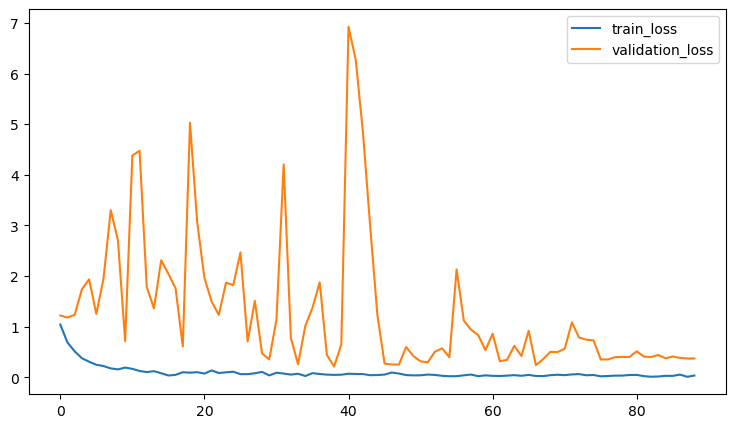

In [36]:
# plot the training history
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(len(train_loss))
plt.plot(epochs, train_loss, label="train_loss")
plt.plot(epochs, val_loss, label="validation_loss")
plt.legend()
plt.show()

In [37]:
# load the best model during the training
model = keras.models.load_model("cnn_hurst.keras", {
    "Conv1D_block": Conv1D_block,
})

In [38]:
results = model.evaluate(X_test, y_test)
print(f"testing loss: {results[0]}, testing accuracy: {results[1]}")

3/3 [==============================] - 0s 2ms/step - loss: 0.0528 - accuracy: 0.9863
testing loss: 0.05280143395066261, testing accuracy: 0.9863013625144958


In [39]:
# evaluate the model performance on training and testing data
train_pred = np.argmax(model.predict(X_train), axis=1)
target_names = ['Molino', 'Pachon', 'Surface']
print(classification_report(y_train, train_pred, target_names=target_names))
confusion_matrix(y_train, train_pred)

8/8 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

      Molino       1.00      1.00      1.00        79
      Pachon       1.00      1.00      1.00        79
     Surface       1.00      1.00      1.00        79

    accuracy                           1.00       237
   macro avg       1.00      1.00      1.00       237
weighted avg       1.00      1.00      1.00       237



array([[79,  0,  0],
       [ 0, 79,  0],
       [ 0,  0, 79]])

In [40]:
test_pred = np.argmax(model.predict(X_test), axis=1)
target_names = ['Molino', 'Pachon', 'Surface']
print(classification_report(y_test, test_pred, target_names=target_names))
confusion_matrix(y_test, test_pred)

3/3 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

      Molino       1.00      1.00      1.00        28
      Pachon       1.00      0.96      0.98        23
     Surface       0.96      1.00      0.98        22

    accuracy                           0.99        73
   macro avg       0.99      0.99      0.99        73
weighted avg       0.99      0.99      0.99        73



array([[28,  0,  0],
       [ 0, 22,  1],
       [ 0,  0, 22]])

In [46]:
def build_CNN(params):
    # build a CNN model
    input_d, output_d, kernel_size = params
    inputs = keras.Input(shape=(X_train.shape[1:]))
    conv1 = Conv1D_block(filters=4, kernel_size=kernel_size, pooling_size=2)
    x = conv1(inputs)
    conv2 = Conv1D_block(filters=8, kernel_size=kernel_size, pooling_size=2)
    x = conv2(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(output_d, activation="softmax")(x)
    cnn = keras.Model(inputs=inputs, outputs=outputs)
    
    # hyper params setting
    #lr = 0.01
    
    decay_steps = 800
    initial_learning_rate = 1e-2
    target_learning_rate = 1e-5
    
    lr_schedule = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate, decay_steps, alpha=target_learning_rate)
    
    optim = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule)
    cnn.compile(
        optimizer=optim,
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy'],
    )
    return cnn

args = [(275, 1), output_d, kernel_size]
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=90, verbose=1, restore_best_weights=True),
    #keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-7, verbose=1),
]



model_f = build_CNN

# random sampling and train a new model
# to more accurately test our model performace indepedent of particular samples
# Similar to the idea of K-fold cross validation
predictors = list(df.drop(labels='class', axis=1).columns)  # names of the features
res = repeat_sampling_and_trainingNN(model_f, args, df,
                                  'class', predictors, num_repeat=100, doMinMaxScaling=False,
                                     data_processing_f=balanced_nested_design_sampling,
                                  is_oversample=True, oversample_f=SMOTE_oversample,
                                    train_f = trainTFNN, test_f = testTFNN, epochs=250,
                                    callbacks=callbacks)

Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9839 - accuracy: 0.5432 - val_loss: 8.2067 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4954 - accuracy: 0.8313 - val_loss: 7.7607 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4371 - accuracy: 0.8230 - val_loss: 7.2319 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2678 - accuracy: 0.9383 - val_loss: 7.4348 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2382 - accuracy: 0.9465 - val_loss: 4.7304 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1493 - accuracy: 0.9794 - val_loss: 3.2147 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1930 - accuracy: 0.9300 - val_loss: 6.8605 - val_accuracy: 0.3103
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0318 - accuracy: 0.9918 - val_loss: 0.6842 - val_accuracy: 0.8448
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0303 - accuracy: 0.9918 - val_loss: 0.0735 - val_accuracy: 0.9828
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0348 - accuracy: 0.9918 - val_loss: 0.2678 - val_accuracy: 0.9310
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0242 - accuracy: 0.9918 - val_loss: 0.2250 - val_accuracy: 0.9655
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0227 - accuracy: 0.9959 - val_loss: 1.0327 - val_accuracy: 0.7759
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0293 - accuracy: 0.9918 - val_loss: 0.0831 - val_accuracy: 0.9828
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0718 - accuracy: 0.9794 - val_loss: 0.3077 - val_accuracy: 0.9655
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0184 - accuracy: 0.9918 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0499 - accuracy: 0.9794 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0263 - accuracy: 0.9959 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0218 - accuracy: 0.9918 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0425 - accuracy: 0.9877 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0267 - accuracy: 0.9918 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0236 - accuracy: 0.9877 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0103 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0305 - accuracy: 0.9959 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0281 - accuracy: 0.9918 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0294 - accuracy: 0.9918 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0242 - accuracy: 0.9918 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0505 - accuracy: 0.9794 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0225 - accuracy: 0.9959 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0372 - accuracy: 0.9877 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 234/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0208 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 235/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0230 - accuracy: 0.9959 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 236/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0371 - accuracy: 0.9877 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 237/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0184 - accuracy: 0.9959 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 238/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0175 - accuracy: 0.9959 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 239/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0287 - accuracy: 0.9918 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 240/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 22ms/step - loss: 0.7317 - accuracy: 0.6872 - val_loss: 5.8662 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4039 - accuracy: 0.8477 - val_loss: 6.7249 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2909 - accuracy: 0.9095 - val_loss: 4.9273 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2993 - accuracy: 0.8971 - val_loss: 6.1658 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1920 - accuracy: 0.9588 - val_loss: 7.4425 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1526 - accuracy: 0.9671 - val_loss: 5.3455 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1347 - accuracy: 0.9588 - val_loss: 7.2444 - val_accuracy: 0.3448
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0373 - accuracy: 0.9877 - val_loss: 1.0670 - val_accuracy: 0.7759
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0543 - accuracy: 0.9712 - val_loss: 1.7912 - val_accuracy: 0.6379
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0370 - accuracy: 0.9753 - val_loss: 0.8651 - val_accuracy: 0.7931
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0283 - accuracy: 0.9835 - val_loss: 2.4311 - val_accuracy: 0.6207
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0204 - accuracy: 0.9877 - val_loss: 0.2566 - val_accuracy: 0.9483
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0300 - accuracy: 0.9794 - val_loss: 0.4747 - val_accuracy: 0.8448
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0259 - accuracy: 0.9877 - val_loss: 0.0315 - val_accuracy: 0.9828
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0430 - accuracy: 0.9835 - val_loss: 0.0344 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0206 - accuracy: 0.9959 - val_loss: 0.0337 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0179 - accuracy: 0.9959 - val_loss: 0.0334 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0342 - accuracy: 0.9835 - val_loss: 0.0335 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0156 - accuracy: 0.9918 - val_loss: 0.0331 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0274 - accuracy: 0.9877 - val_loss: 0.0336 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0259 - accuracy: 0.9877 - val_loss: 0.0331 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0213 - accuracy: 0.9877 - val_loss: 0.0326 - val_accuracy: 0.9655
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0349 - accuracy: 0.9877 - val_loss: 0.0319 - val_accuracy: 0.9655
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0487 - accuracy: 0.9794 - val_loss: 0.0327 - val_accuracy: 0.9655
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0157 - accuracy: 0.9918 - val_loss: 0.0335 - val_accuracy: 0.9655
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0551 - accuracy: 0.9671 - val_loss: 0.0337 - val_accuracy: 0.9655
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0202 - accuracy: 0.9877 - val_loss: 0.0339 - val_accuracy: 0.9655
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0143 - accuracy: 0.9918 - val_loss: 0.0338 - val_accuracy: 0.9655
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0233 - accuracy: 0.9877 - val_loss: 0.0300 - val_accuracy: 0.9828
Epoch 234/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0357 - accuracy: 0.9794 - val_loss: 0.0304 - val_accuracy: 0.9828
Epoch 235/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0263 - accuracy: 0.9835 - val_loss: 0.0301 - val_accuracy: 0.9828
Epoch 236/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0502 - accuracy: 0.9712 - val_loss: 0.0295 - val_accuracy: 1.0000
Epoch 237/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0507 - accuracy: 0.9671 - val_loss: 0.0285 - val_accuracy: 1.0000
Epoch 238/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0255 - accuracy: 0.9918 - val_loss: 0.0279 - val_accuracy: 1.0000
Epoch 239/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0286 - accuracy: 0.9835 - val_loss: 0.0285 - val_accuracy: 1.0000
Epoch 240/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

9/9 [==============================] - 1s 20ms/step - loss: 1.1977 - accuracy: 0.4109 - val_loss: 1.2298 - val_accuracy: 0.3448
Epoch 2/250
9/9 [==============================] - 0s 6ms/step - loss: 0.5843 - accuracy: 0.7674 - val_loss: 3.0680 - val_accuracy: 0.3448
Epoch 3/250
9/9 [==============================] - 0s 6ms/step - loss: 0.3809 - accuracy: 0.8760 - val_loss: 4.8028 - val_accuracy: 0.3448
Epoch 4/250
9/9 [==============================] - 0s 6ms/step - loss: 0.3718 - accuracy: 0.8915 - val_loss: 5.0049 - val_accuracy: 0.3448
Epoch 5/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2513 - accuracy: 0.9302 - val_loss: 5.8975 - val_accuracy: 0.3448
Epoch 6/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2229 - accuracy: 0.9302 - val_loss: 7.6372 - val_accuracy: 0.3448
Epoch 7/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1802 - accuracy: 0.9380 - val_loss: 7.1899 - val_accuracy: 0.3448
Epoch 8/250
9/9 [=====================

9/9 [==============================] - 0s 7ms/step - loss: 0.0492 - accuracy: 0.9806 - val_loss: 1.9202 - val_accuracy: 0.5690
Epoch 60/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0458 - accuracy: 0.9767 - val_loss: 1.1594 - val_accuracy: 0.6724
Epoch 61/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0514 - accuracy: 0.9767 - val_loss: 0.9717 - val_accuracy: 0.7069
Epoch 62/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0600 - accuracy: 0.9767 - val_loss: 2.2079 - val_accuracy: 0.5862
Epoch 63/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0561 - accuracy: 0.9767 - val_loss: 1.1374 - val_accuracy: 0.6897
Epoch 64/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0471 - accuracy: 0.9767 - val_loss: 0.5710 - val_accuracy: 0.8448
Epoch 65/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0551 - accuracy: 0.9767 - val_loss: 1.6989 - val_accuracy: 0.6207
Epoch 66/250
9/9 [===============

9/9 [==============================] - 0s 6ms/step - loss: 0.0500 - accuracy: 0.9690 - val_loss: 0.0778 - val_accuracy: 0.9655
Epoch 118/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0369 - accuracy: 0.9806 - val_loss: 0.0768 - val_accuracy: 0.9655
Epoch 119/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0288 - accuracy: 0.9845 - val_loss: 0.0762 - val_accuracy: 0.9655
Epoch 120/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0930 - accuracy: 0.9729 - val_loss: 0.0763 - val_accuracy: 0.9655
Epoch 121/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0466 - accuracy: 0.9845 - val_loss: 0.0742 - val_accuracy: 0.9655
Epoch 122/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0474 - accuracy: 0.9806 - val_loss: 0.0728 - val_accuracy: 0.9655
Epoch 123/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0343 - accuracy: 0.9845 - val_loss: 0.0753 - val_accuracy: 0.9655
Epoch 124/250
9/9 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9551 - accuracy: 0.5691 - val_loss: 2.2580 - val_accuracy: 0.4655
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4502 - accuracy: 0.8293 - val_loss: 3.4627 - val_accuracy: 0.4655
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2895 - accuracy: 0.9187 - val_loss: 4.8680 - val_accuracy: 0.4655
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2123 - accuracy: 0.9431 - val_loss: 5.0676 - val_accuracy: 0.4655
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1983 - accuracy: 0.9228 - val_loss: 7.7256 - val_accuracy: 0.4655
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1660 - accuracy: 0.9512 - val_loss: 5.6123 - val_accuracy: 0.4655
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2589 - accuracy: 0.9106 - val_loss: 10.5743 - val_accuracy: 0.4655
Epoch 8/250
8/8 [====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0353 - accuracy: 0.9837 - val_loss: 3.6948 - val_accuracy: 0.7241
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0447 - accuracy: 0.9715 - val_loss: 5.3444 - val_accuracy: 0.5862
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0397 - accuracy: 0.9797 - val_loss: 11.6384 - val_accuracy: 0.4655
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0125 - accuracy: 0.9959 - val_loss: 8.8527 - val_accuracy: 0.4655
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0157 - accuracy: 0.9959 - val_loss: 8.3417 - val_accuracy: 0.4655
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0662 - accuracy: 0.9756 - val_loss: 7.2114 - val_accuracy: 0.4828
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0099 - accuracy: 0.9959 - val_loss: 6.4690 - val_accuracy: 0.5000
Epoch 66/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0353 - accuracy: 0.9837 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0381 - accuracy: 0.9797 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0336 - accuracy: 0.9837 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0409 - accuracy: 0.9756 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0237 - accuracy: 0.9878 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0344 - accuracy: 0.9919 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 175: early stopping
3/3 [==============================] - 0s 1ms/step
[[23  0  1]
 [ 1 28  0]
 [ 0  0 20]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9422 - accuracy: 0.5691 - val_loss: 3.3222 - val_accuracy: 0.2586
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4038 - accuracy: 0.8659 - val_loss: 5.8283 - val_accuracy: 0.2586
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3061 - accuracy: 0.9024 - val_loss: 5.3045 - val_accuracy: 0.2586
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2273 - accuracy: 0.9431 - val_loss: 6.8570 - val_accuracy: 0.2586
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1675 - accuracy: 0.9634 - val_loss: 6.6596 - val_accuracy: 0.2586
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1703 - accuracy: 0.9472 - val_loss: 8.4690 - val_accuracy: 0.2586
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1712 - accuracy: 0.9146 - val_loss: 8.7109 - val_accuracy: 0.2586
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0496 - accuracy: 0.9756 - val_loss: 0.0936 - val_accuracy: 0.9655
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0247 - accuracy: 0.9837 - val_loss: 0.0623 - val_accuracy: 0.9828
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0192 - accuracy: 0.9878 - val_loss: 0.0630 - val_accuracy: 0.9828
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0429 - accuracy: 0.9675 - val_loss: 0.0917 - val_accuracy: 0.9655
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0500 - accuracy: 0.9715 - val_loss: 0.2634 - val_accuracy: 0.9138
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0195 - accuracy: 0.9878 - val_loss: 0.1535 - val_accuracy: 0.9483
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0287 - accuracy: 0.9878 - val_loss: 0.1662 - val_accuracy: 0.9483
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0298 - accuracy: 0.9797 - val_loss: 0.0217 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0263 - accuracy: 0.9878 - val_loss: 0.0217 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0311 - accuracy: 0.9878 - val_loss: 0.0215 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0360 - accuracy: 0.9756 - val_loss: 0.0215 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0372 - accuracy: 0.9715 - val_loss: 0.0218 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0192 - accuracy: 0.9878 - val_loss: 0.0217 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0279 - accuracy: 0.9837 - val_loss: 0.0216 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 24ms/step - loss: 0.8170 - accuracy: 0.6255 - val_loss: 2.0964 - val_accuracy: 0.3966
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4364 - accuracy: 0.8436 - val_loss: 3.0282 - val_accuracy: 0.3966
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3249 - accuracy: 0.8724 - val_loss: 4.1700 - val_accuracy: 0.3966
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2963 - accuracy: 0.8848 - val_loss: 3.3160 - val_accuracy: 0.3966
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1696 - accuracy: 0.9547 - val_loss: 4.1432 - val_accuracy: 0.3966
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1406 - accuracy: 0.9671 - val_loss: 5.7286 - val_accuracy: 0.3966
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1714 - accuracy: 0.9383 - val_loss: 5.1608 - val_accuracy: 0.3966
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0254 - accuracy: 0.9918 - val_loss: 1.4203 - val_accuracy: 0.6897
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0318 - accuracy: 0.9835 - val_loss: 0.1484 - val_accuracy: 0.9310
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0125 - accuracy: 0.9959 - val_loss: 0.1268 - val_accuracy: 0.9310
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.0902 - val_accuracy: 0.9483
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0336 - accuracy: 0.9918 - val_loss: 1.5053 - val_accuracy: 0.6552
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0522 - accuracy: 0.9588 - val_loss: 0.1434 - val_accuracy: 0.9483
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0237 - accuracy: 0.9918 - val_loss: 0.0968 - val_accuracy: 0.9655
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0172 - accuracy: 0.9877 - val_loss: 0.0259 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0082 - accuracy: 0.9959 - val_loss: 0.0263 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0297 - accuracy: 0.9794 - val_loss: 0.0266 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0387 - accuracy: 0.9794 - val_loss: 0.0266 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0357 - accuracy: 0.9794 - val_loss: 0.0261 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0293 - accuracy: 0.9918 - val_loss: 0.0259 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0283 - accuracy: 0.9794 - val_loss: 0.0259 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0373 - accuracy: 0.9712 - val_loss: 0.0296 - val_accuracy: 0.9828
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0273 - accuracy: 0.9918 - val_loss: 0.0298 - val_accuracy: 0.9828
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0292 - accuracy: 0.9835 - val_loss: 0.0304 - val_accuracy: 0.9828
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0192 - accuracy: 0.9835 - val_loss: 0.0304 - val_accuracy: 0.9828
Epoch 178: early stopping
3/3 [==============================] - 0s 1ms/step
[[26  0  0]
 [ 0 22  1]
 [ 0  0 24]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9722 - accuracy: 0.5350 - val_loss: 11.4264 - val_accuracy: 0.3966
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4579 - accuracy: 0.8272 - val_loss: 11.6417 - val_accuracy: 0.3966
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3272 - accuracy: 0.8930 - val_loss: 14.9235 - val_accuracy: 0.3966
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2458 - accuracy: 0.9342 - val_loss: 12.7177 - val_accuracy: 0.3966
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1836 - accuracy: 0.9588 - val_loss: 6.5559 - val_accuracy: 0.3966
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1716 - accuracy: 0.9588 - val_loss: 5.6329 - val_accuracy: 0.3966
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1117 - accuracy: 0.9835 - val_loss: 21.8486 - val_accuracy: 0.3966
Epoch 8/250
8/8 [================

8/8 [==============================] - 0s 8ms/step - loss: 0.0333 - accuracy: 0.9877 - val_loss: 0.1795 - val_accuracy: 0.9483
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0580 - accuracy: 0.9753 - val_loss: 0.0470 - val_accuracy: 0.9828
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0393 - accuracy: 0.9835 - val_loss: 0.0537 - val_accuracy: 0.9828
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0487 - accuracy: 0.9794 - val_loss: 0.0766 - val_accuracy: 0.9828
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0330 - accuracy: 0.9877 - val_loss: 0.1111 - val_accuracy: 0.9655
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0585 - accuracy: 0.9753 - val_loss: 0.0190 - val_accuracy: 1.0000
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0203 - accuracy: 0.9918 - val_loss: 0.0190 - val_accuracy: 1.0000
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0303 - accuracy: 0.9877 - val_loss: 0.0230 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0165 - accuracy: 0.9959 - val_loss: 0.0228 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0397 - accuracy: 0.9835 - val_loss: 0.0227 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 0.0224 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0182 - accuracy: 0.9918 - val_loss: 0.0218 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0194 - accuracy: 0.9959 - val_loss: 0.0215 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0287 - accuracy: 0.9918 - val_loss: 0.0211 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9567 - accuracy: 0.5894 - val_loss: 2.9082 - val_accuracy: 0.4138
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4865 - accuracy: 0.8659 - val_loss: 3.9366 - val_accuracy: 0.4138
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3416 - accuracy: 0.8943 - val_loss: 5.8183 - val_accuracy: 0.4138
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2308 - accuracy: 0.9350 - val_loss: 5.5909 - val_accuracy: 0.4138
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2042 - accuracy: 0.9187 - val_loss: 4.5866 - val_accuracy: 0.4138
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1648 - accuracy: 0.9390 - val_loss: 6.1412 - val_accuracy: 0.4138
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1124 - accuracy: 0.9837 - val_loss: 6.2695 - val_accuracy: 0.4138
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0299 - accuracy: 0.9797 - val_loss: 4.0584 - val_accuracy: 0.6724
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0455 - accuracy: 0.9715 - val_loss: 1.3934 - val_accuracy: 0.8276
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0308 - accuracy: 0.9919 - val_loss: 0.5525 - val_accuracy: 0.8966
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0316 - accuracy: 0.9878 - val_loss: 1.0102 - val_accuracy: 0.8276
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0254 - accuracy: 0.9878 - val_loss: 0.7802 - val_accuracy: 0.8793
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0383 - accuracy: 0.9919 - val_loss: 2.6311 - val_accuracy: 0.7414
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0495 - accuracy: 0.9715 - val_loss: 5.7188 - val_accuracy: 0.6724
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0286 - accuracy: 0.9837 - val_loss: 0.0415 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0534 - accuracy: 0.9756 - val_loss: 0.0405 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0362 - accuracy: 0.9837 - val_loss: 0.0401 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0215 - accuracy: 0.9919 - val_loss: 0.0394 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0348 - accuracy: 0.9797 - val_loss: 0.0390 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0113 - accuracy: 0.9919 - val_loss: 0.0383 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0215 - accuracy: 0.9878 - val_loss: 0.0381 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0306 - accuracy: 0.9878 - val_loss: 0.0356 - val_accuracy: 0.9828
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0227 - accuracy: 0.9878 - val_loss: 0.0355 - val_accuracy: 0.9828
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0304 - accuracy: 0.9756 - val_loss: 0.0361 - val_accuracy: 0.9828
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0426 - accuracy: 0.9715 - val_loss: 0.0361 - val_accuracy: 0.9828
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0195 - accuracy: 0.9837 - val_loss: 0.0364 - val_accuracy: 0.9828
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0164 - accuracy: 0.9878 - val_loss: 0.0367 - val_accuracy: 0.9828
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0410 - accuracy: 0.9675 - val_loss: 0.0365 - val_accuracy: 0.9828
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0272 - accuracy: 0.9837 - val_loss: 0.0372 - val_accuracy: 0.9828
Epoch 234/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0224 - accuracy: 0.9959 - val_loss: 0.0377 - val_accuracy: 0.9828
Epoch 235/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0343 - accuracy: 0.9878 - val_loss: 0.0374 - val_accuracy: 0.9828
Epoch 236/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0345 - accuracy: 0.9797 - val_loss: 0.0371 - val_accuracy: 0.9828
Epoch 237/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0257 - accuracy: 0.9878 - val_loss: 0.0370 - val_accuracy: 0.9828
Epoch 238/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0362 - accuracy: 0.9756 - val_loss: 0.0369 - val_accuracy: 0.9828
Epoch 239/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0318 - accuracy: 0.9837 - val_loss: 0.0370 - val_accuracy: 0.9828
Epoch 240/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9321 - accuracy: 0.5597 - val_loss: 1.9708 - val_accuracy: 0.3621
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4453 - accuracy: 0.8436 - val_loss: 2.1530 - val_accuracy: 0.3621
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3409 - accuracy: 0.8971 - val_loss: 2.8936 - val_accuracy: 0.3621
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2587 - accuracy: 0.9259 - val_loss: 3.8742 - val_accuracy: 0.3621
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2370 - accuracy: 0.9259 - val_loss: 4.3449 - val_accuracy: 0.3621
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1583 - accuracy: 0.9588 - val_loss: 4.1048 - val_accuracy: 0.3621
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1333 - accuracy: 0.9712 - val_loss: 5.1653 - val_accuracy: 0.3621
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0293 - accuracy: 0.9877 - val_loss: 0.4529 - val_accuracy: 0.8793
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0147 - accuracy: 0.9877 - val_loss: 2.2154 - val_accuracy: 0.5862
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0409 - accuracy: 0.9712 - val_loss: 0.3932 - val_accuracy: 0.8448
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0241 - accuracy: 0.9835 - val_loss: 0.7311 - val_accuracy: 0.7931
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0418 - accuracy: 0.9835 - val_loss: 5.1844 - val_accuracy: 0.5345
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0156 - accuracy: 0.9959 - val_loss: 4.2215 - val_accuracy: 0.5862
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0456 - accuracy: 0.9794 - val_loss: 3.6918 - val_accuracy: 0.6379
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0578 - accuracy: 0.9671 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0365 - accuracy: 0.9835 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0196 - accuracy: 0.9877 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0219 - accuracy: 0.9959 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0294 - accuracy: 0.9918 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0274 - accuracy: 0.9918 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0260 - accuracy: 0.9877 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0309 - accuracy: 0.9877 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0188 - accuracy: 0.9794 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0187 - accuracy: 0.9877 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0252 - accuracy: 0.9877 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0138 - accuracy: 0.9918 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0077 - accuracy: 0.9959 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0378 - accuracy: 0.9835 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 182/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8270 - accuracy: 0.6414 - val_loss: 3.8916 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4217 - accuracy: 0.8734 - val_loss: 7.1356 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3181 - accuracy: 0.8987 - val_loss: 7.3958 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2581 - accuracy: 0.9325 - val_loss: 7.4176 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1965 - accuracy: 0.9409 - val_loss: 6.8025 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1941 - accuracy: 0.9283 - val_loss: 9.2500 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1465 - accuracy: 0.9620 - val_loss: 8.6595 - val_accuracy: 0.3448
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0288 - accuracy: 0.9873 - val_loss: 11.0140 - val_accuracy: 0.5000
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0544 - accuracy: 0.9747 - val_loss: 0.2066 - val_accuracy: 0.9483
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 0.0864 - val_accuracy: 0.9655
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0575 - accuracy: 0.9747 - val_loss: 0.6857 - val_accuracy: 0.7759
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0365 - accuracy: 0.9789 - val_loss: 0.5796 - val_accuracy: 0.8276
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0310 - accuracy: 0.9789 - val_loss: 0.3274 - val_accuracy: 0.8966
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0186 - accuracy: 0.9916 - val_loss: 0.1902 - val_accuracy: 0.9655
Epoch 66/250
8/8 [==============

Epoch 117/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0461 - accuracy: 0.9662 - val_loss: 1.3734e-04 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0144 - accuracy: 0.9916 - val_loss: 1.3795e-04 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0246 - accuracy: 0.9873 - val_loss: 1.3879e-04 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0785 - accuracy: 0.9662 - val_loss: 1.3274e-04 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0346 - accuracy: 0.9747 - val_loss: 1.3310e-04 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0385 - accuracy: 0.9705 - val_loss: 1.3659e-04 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0213 - accuracy: 0.9916 - val_loss: 1.3149e-04 - val_ac

8/8 [==============================] - 0s 6ms/step - loss: 0.0302 - accuracy: 0.9789 - val_loss: 1.1469e-04 - val_accuracy: 1.0000
Epoch 174/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0460 - accuracy: 0.9789 - val_loss: 1.1457e-04 - val_accuracy: 1.0000
Epoch 175/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0499 - accuracy: 0.9747 - val_loss: 1.1511e-04 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0375 - accuracy: 0.9747 - val_loss: 1.1780e-04 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0101 - accuracy: 0.9916 - val_loss: 1.1596e-04 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0189 - accuracy: 0.9873 - val_loss: 1.2087e-04 - val_accuracy: 1.0000
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0112 - accuracy: 0.9916 - val_loss: 1.2020e-04 - val_accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0310 - accuracy: 0.9831 - val_loss: 1.2274e-04 - val_accuracy: 1.0000
Epoch 230/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0265 - accuracy: 0.9831 - val_loss: 1.1866e-04 - val_accuracy: 1.0000
Epoch 231/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0445 - accuracy: 0.9705 - val_loss: 1.1838e-04 - val_accuracy: 1.0000
Epoch 232/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0148 - accuracy: 0.9916 - val_loss: 1.1530e-04 - val_accuracy: 1.0000
Epoch 233/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0285 - accuracy: 0.9831 - val_loss: 1.1560e-04 - val_accuracy: 1.0000
Epoch 234/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0416 - accuracy: 0.9705 - val_loss: 1.1437e-04 - val_accuracy: 1.0000
Epoch 235/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0385 - accuracy: 0.9831 - val_loss: 1.1675e-04 - val_accuracy: 1.0000

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 1/250
8/8 [==============================] - 1s 23ms/step - loss: 0.8226 - accuracy: 0.6214 - val_loss: 3.6729 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3784 - accuracy: 0.8683 - val_loss: 3.9464 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2745 - accuracy: 0.9218 - val_loss: 3.9050 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2790 - accuracy: 0.9053 - val_loss: 4.2785 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2369 - accuracy: 0.9095 - val_loss: 2.1344 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1791 - accuracy: 0.9342 - val_loss: 5.2088 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1437 - accuracy: 0.9712 - val_loss: 4.0824 - val_accuracy: 0.3448
Epoch 8/250
8/8 [=========

8/8 [==============================] - 0s 7ms/step - loss: 0.0617 - accuracy: 0.9671 - val_loss: 1.6475 - val_accuracy: 0.5862
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0956 - accuracy: 0.9671 - val_loss: 0.0288 - val_accuracy: 0.9828
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0350 - accuracy: 0.9794 - val_loss: 6.3600 - val_accuracy: 0.3621
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0516 - accuracy: 0.9712 - val_loss: 10.4611 - val_accuracy: 0.3276
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0312 - accuracy: 0.9794 - val_loss: 7.6987 - val_accuracy: 0.3448
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0328 - accuracy: 0.9835 - val_loss: 7.8352 - val_accuracy: 0.3448
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0518 - accuracy: 0.9671 - val_loss: 0.5493 - val_accuracy: 0.8448
Epoch 66/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0456 - accuracy: 0.9671 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0276 - accuracy: 0.9918 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0843 - accuracy: 0.9630 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0236 - accuracy: 0.9877 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0236 - accuracy: 0.9918 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0230 - accuracy: 0.9918 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0238 - accuracy: 0.9918 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0385 - accuracy: 0.9753 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0331 - accuracy: 0.9835 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0407 - accuracy: 0.9835 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0248 - accuracy: 0.9835 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0193 - accuracy: 0.9835 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0253 - accuracy: 0.9835 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0419 - accuracy: 0.9794 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 182/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.0331 - accuracy: 0.5610 - val_loss: 1.1095 - val_accuracy: 0.2759
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.5264 - accuracy: 0.8252 - val_loss: 1.5994 - val_accuracy: 0.2759
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3295 - accuracy: 0.9106 - val_loss: 3.6675 - val_accuracy: 0.2759
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2751 - accuracy: 0.9187 - val_loss: 3.7365 - val_accuracy: 0.2759
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1678 - accuracy: 0.9797 - val_loss: 4.9388 - val_accuracy: 0.2759
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1690 - accuracy: 0.9675 - val_loss: 4.6406 - val_accuracy: 0.2759
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1429 - accuracy: 0.9593 - val_loss: 6.4470 - val_accuracy: 0.2759
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0356 - accuracy: 0.9837 - val_loss: 5.9764 - val_accuracy: 0.5000
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0350 - accuracy: 0.9878 - val_loss: 2.4322 - val_accuracy: 0.6379
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0653 - accuracy: 0.9797 - val_loss: 3.5627 - val_accuracy: 0.6207
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0438 - accuracy: 0.9878 - val_loss: 2.3847 - val_accuracy: 0.6897
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0435 - accuracy: 0.9837 - val_loss: 2.1115 - val_accuracy: 0.6897
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0264 - accuracy: 0.9878 - val_loss: 1.7905 - val_accuracy: 0.7069
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.3341 - val_accuracy: 0.7241
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0243 - accuracy: 0.9878 - val_loss: 0.1558 - val_accuracy: 0.9310
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0433 - accuracy: 0.9837 - val_loss: 0.1551 - val_accuracy: 0.9310
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0303 - accuracy: 0.9837 - val_loss: 0.1547 - val_accuracy: 0.9310
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0359 - accuracy: 0.9837 - val_loss: 0.1541 - val_accuracy: 0.9310
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0266 - accuracy: 0.9919 - val_loss: 0.1539 - val_accuracy: 0.9310
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0524 - accuracy: 0.9715 - val_loss: 0.1535 - val_accuracy: 0.9310
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0248 - accuracy: 0.9919 - val_loss: 0.1532 - val_accuracy: 0.9310
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0152 - accuracy: 0.9959 - val_loss: 0.1500 - val_accuracy: 0.9310
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0208 - accuracy: 0.9919 - val_loss: 0.1502 - val_accuracy: 0.9310
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0237 - accuracy: 0.9919 - val_loss: 0.1502 - val_accuracy: 0.9310
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0201 - accuracy: 0.9959 - val_loss: 0.1500 - val_accuracy: 0.9310
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0195 - accuracy: 0.9959 - val_loss: 0.1502 - val_accuracy: 0.9310
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0655 - accuracy: 0.9715 - val_loss: 0.1502 - val_accuracy: 0.9310
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0439 - accuracy: 0.9797 - val_loss: 0.1503 - val_accuracy: 0.9310
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0276 - accuracy: 0.9878 - val_loss: 0.1504 - val_accuracy: 0.9310
Epoch 234/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0198 - accuracy: 0.9919 - val_loss: 0.1506 - val_accuracy: 0.9310
Epoch 235/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.1504 - val_accuracy: 0.9310
Epoch 236/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0230 - accuracy: 0.9919 - val_loss: 0.1504 - val_accuracy: 0.9310
Epoch 237/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0189 - accuracy: 0.9919 - val_loss: 0.1503 - val_accuracy: 0.9310
Epoch 238/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0460 - accuracy: 0.9878 - val_loss: 0.1503 - val_accuracy: 0.9310
Epoch 239/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0216 - accuracy: 0.9919 - val_loss: 0.1503 - val_accuracy: 0.9310
Epoch 240/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.0743 - accuracy: 0.5556 - val_loss: 2.1021 - val_accuracy: 0.2759
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4953 - accuracy: 0.8333 - val_loss: 3.0829 - val_accuracy: 0.2759
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3535 - accuracy: 0.8968 - val_loss: 5.0181 - val_accuracy: 0.2759
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1950 - accuracy: 0.9643 - val_loss: 5.3463 - val_accuracy: 0.2759
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1886 - accuracy: 0.9484 - val_loss: 8.3522 - val_accuracy: 0.2759
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1696 - accuracy: 0.9405 - val_loss: 4.9752 - val_accuracy: 0.2759
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1401 - accuracy: 0.9405 - val_loss: 5.9477 - val_accuracy: 0.2759
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0431 - accuracy: 0.9802 - val_loss: 4.0608 - val_accuracy: 0.6207
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0426 - accuracy: 0.9762 - val_loss: 3.0222 - val_accuracy: 0.6897
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0345 - accuracy: 0.9762 - val_loss: 0.4968 - val_accuracy: 0.9310
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0234 - accuracy: 0.9881 - val_loss: 0.3263 - val_accuracy: 0.9655
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0254 - accuracy: 0.9841 - val_loss: 0.9265 - val_accuracy: 0.8966
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0354 - accuracy: 0.9881 - val_loss: 0.7212 - val_accuracy: 0.9138
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0396 - accuracy: 0.9802 - val_loss: 0.1030 - val_accuracy: 0.9828
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0185 - accuracy: 0.9960 - val_loss: 0.0873 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0304 - accuracy: 0.9841 - val_loss: 0.0852 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0256 - accuracy: 0.9881 - val_loss: 0.0830 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0339 - accuracy: 0.9802 - val_loss: 0.0812 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0295 - accuracy: 0.9841 - val_loss: 0.0797 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0458 - accuracy: 0.9762 - val_loss: 0.0781 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0422 - accuracy: 0.9762 - val_loss: 0.0766 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8878 - accuracy: 0.6345 - val_loss: 3.7028 - val_accuracy: 0.3966
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3986 - accuracy: 0.8675 - val_loss: 4.5620 - val_accuracy: 0.3966
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3156 - accuracy: 0.8956 - val_loss: 5.4372 - val_accuracy: 0.3966
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2037 - accuracy: 0.9317 - val_loss: 6.1682 - val_accuracy: 0.3966
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1992 - accuracy: 0.9558 - val_loss: 8.1390 - val_accuracy: 0.3966
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1601 - accuracy: 0.9438 - val_loss: 9.4733 - val_accuracy: 0.3966
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1409 - accuracy: 0.9598 - val_loss: 8.2996 - val_accuracy: 0.3966
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0182 - accuracy: 0.9880 - val_loss: 2.6867 - val_accuracy: 0.7069
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0406 - accuracy: 0.9839 - val_loss: 3.9387 - val_accuracy: 0.6897
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0155 - accuracy: 0.9920 - val_loss: 3.7651 - val_accuracy: 0.6897
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0443 - accuracy: 0.9759 - val_loss: 2.5552 - val_accuracy: 0.6897
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0554 - accuracy: 0.9719 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0708 - accuracy: 0.9799 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0385 - accuracy: 0.9880 - val_loss: 1.8778 - val_accuracy: 0.6034
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0316 - accuracy: 0.9880 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0315 - accuracy: 0.9839 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0453 - accuracy: 0.9839 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0195 - accuracy: 0.9880 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0521 - accuracy: 0.9839 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0176 - accuracy: 0.9880 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0258 - accuracy: 0.9880 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8154 - accuracy: 0.6208 - val_loss: 4.6458 - val_accuracy: 0.2931
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4522 - accuracy: 0.8125 - val_loss: 4.2870 - val_accuracy: 0.2931
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3311 - accuracy: 0.8958 - val_loss: 6.7709 - val_accuracy: 0.2931
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2455 - accuracy: 0.9292 - val_loss: 7.3846 - val_accuracy: 0.2931
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2133 - accuracy: 0.9417 - val_loss: 8.8414 - val_accuracy: 0.2931
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1871 - accuracy: 0.9292 - val_loss: 8.8398 - val_accuracy: 0.2931
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1443 - accuracy: 0.9625 - val_loss: 7.4881 - val_accuracy: 0.2931
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0601 - accuracy: 0.9667 - val_loss: 4.0774 - val_accuracy: 0.5000
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0593 - accuracy: 0.9625 - val_loss: 5.0519 - val_accuracy: 0.4483
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0391 - accuracy: 0.9708 - val_loss: 1.2272 - val_accuracy: 0.7414
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0346 - accuracy: 0.9708 - val_loss: 0.9223 - val_accuracy: 0.8103
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0611 - accuracy: 0.9500 - val_loss: 0.0768 - val_accuracy: 0.9655
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0210 - accuracy: 0.9875 - val_loss: 0.0884 - val_accuracy: 0.9828
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0287 - accuracy: 0.9875 - val_loss: 0.0844 - val_accuracy: 0.9828
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0181 - accuracy: 0.9792 - val_loss: 0.0480 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0262 - accuracy: 0.9875 - val_loss: 0.0479 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0296 - accuracy: 0.9792 - val_loss: 0.0479 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0274 - accuracy: 0.9708 - val_loss: 0.0479 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0359 - accuracy: 0.9750 - val_loss: 0.0479 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0511 - accuracy: 0.9667 - val_loss: 0.0478 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0564 - accuracy: 0.9708 - val_loss: 0.0479 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0169 - accuracy: 0.9875 - val_loss: 0.0480 - val_accuracy: 0.9655
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0346 - accuracy: 0.9750 - val_loss: 0.0479 - val_accuracy: 0.9655
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0370 - accuracy: 0.9750 - val_loss: 0.0477 - val_accuracy: 0.9655
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0476 - accuracy: 0.9750 - val_loss: 0.0477 - val_accuracy: 0.9655
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0331 - accuracy: 0.9792 - val_loss: 0.0479 - val_accuracy: 0.9655
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0562 - accuracy: 0.9708 - val_loss: 0.0482 - val_accuracy: 0.9655
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0400 - accuracy: 0.9833 - val_loss: 0.0481 - val_accuracy: 0.9655
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0598 - accuracy: 0.9708 - val_loss: 0.0478 - val_accuracy: 0.9655
Epoch 234/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0306 - accuracy: 0.9708 - val_loss: 0.0477 - val_accuracy: 0.9655
Epoch 235/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0722 - accuracy: 0.9583 - val_loss: 0.0478 - val_accuracy: 0.9655
Epoch 236/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0524 - accuracy: 0.9708 - val_loss: 0.0479 - val_accuracy: 0.9655
Epoch 237/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0327 - accuracy: 0.9792 - val_loss: 0.0478 - val_accuracy: 0.9655
Epoch 238/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0327 - accuracy: 0.9750 - val_loss: 0.0477 - val_accuracy: 0.9655
Epoch 239/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0405 - accuracy: 0.9708 - val_loss: 0.0478 - val_accuracy: 0.9655
Epoch 240/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 49ms/step - loss: 0.8936 - accuracy: 0.5875 - val_loss: 2.8872 - val_accuracy: 0.3966
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4374 - accuracy: 0.8458 - val_loss: 3.2040 - val_accuracy: 0.3966
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3237 - accuracy: 0.8875 - val_loss: 3.7875 - val_accuracy: 0.3966
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2242 - accuracy: 0.9333 - val_loss: 3.2572 - val_accuracy: 0.3966
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1925 - accuracy: 0.9625 - val_loss: 3.6289 - val_accuracy: 0.3966
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2032 - accuracy: 0.9250 - val_loss: 5.3829 - val_accuracy: 0.3966
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0914 - accuracy: 0.9792 - val_loss: 5.7174 - val_accuracy: 0.3966
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0380 - accuracy: 0.9833 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0447 - accuracy: 0.9708 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0459 - accuracy: 0.9750 - val_loss: 0.0976 - val_accuracy: 0.9483
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0241 - accuracy: 0.9875 - val_loss: 0.0207 - val_accuracy: 0.9828
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0252 - accuracy: 0.9875 - val_loss: 0.0136 - val_accuracy: 1.0000
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0179 - accuracy: 0.9875 - val_loss: 0.0122 - val_accuracy: 1.0000
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0292 - accuracy: 0.9792 - val_loss: 5.2052 - val_accuracy: 0.5690
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0309 - accuracy: 0.9750 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0175 - accuracy: 0.9875 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0316 - accuracy: 0.9792 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0156 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0345 - accuracy: 0.9750 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0143 - accuracy: 0.9917 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0633 - accuracy: 0.9625 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0357 - accuracy: 0.9833 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0381 - accuracy: 0.9792 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0095 - accuracy: 0.9958 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0197 - accuracy: 0.9917 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0314 - accuracy: 0.9875 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0238 - accuracy: 0.9958 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0216 - accuracy: 0.9875 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0206 - accuracy: 0.9833 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 234/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0200 - accuracy: 0.9958 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 235/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0229 - accuracy: 0.9875 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 236/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0486 - accuracy: 0.9667 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 237/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0296 - accuracy: 0.9833 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 238/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0368 - accuracy: 0.9750 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 239/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0282 - accuracy: 0.9833 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 240/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9494 - accuracy: 0.5885 - val_loss: 2.3755 - val_accuracy: 0.3621
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4346 - accuracy: 0.8354 - val_loss: 2.9443 - val_accuracy: 0.3621
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3031 - accuracy: 0.8971 - val_loss: 2.8496 - val_accuracy: 0.3621
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2024 - accuracy: 0.9506 - val_loss: 4.2914 - val_accuracy: 0.3621
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1990 - accuracy: 0.9383 - val_loss: 5.1815 - val_accuracy: 0.3621
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1145 - accuracy: 0.9671 - val_loss: 8.5733 - val_accuracy: 0.3621
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1041 - accuracy: 0.9753 - val_loss: 5.4601 - val_accuracy: 0.3621
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0324 - accuracy: 0.9877 - val_loss: 3.1767 - val_accuracy: 0.5172
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0461 - accuracy: 0.9835 - val_loss: 4.5114 - val_accuracy: 0.4310
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0268 - accuracy: 0.9877 - val_loss: 5.2005 - val_accuracy: 0.4310
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0212 - accuracy: 0.9918 - val_loss: 15.7971 - val_accuracy: 0.3621
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0253 - accuracy: 0.9877 - val_loss: 11.3722 - val_accuracy: 0.3793
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0129 - accuracy: 0.9959 - val_loss: 8.6757 - val_accuracy: 0.4138
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0222 - accuracy: 0.9877 - val_loss: 12.7547 - val_accuracy: 0.3793
Epoch 66/250
8/8 [============

8/8 [==============================] - 0s 7ms/step - loss: 0.0338 - accuracy: 0.9877 - val_loss: 0.0470 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0548 - accuracy: 0.9712 - val_loss: 0.0467 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0359 - accuracy: 0.9835 - val_loss: 0.0475 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0594 - accuracy: 0.9671 - val_loss: 0.0482 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0333 - accuracy: 0.9835 - val_loss: 0.0485 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0313 - accuracy: 0.9835 - val_loss: 0.0487 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0301 - accuracy: 0.9918 - val_loss: 0.0485 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0649 - accuracy: 0.9712 - val_loss: 0.0500 - val_accuracy: 0.9828
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0286 - accuracy: 0.9835 - val_loss: 0.0499 - val_accuracy: 0.9828
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0181 - accuracy: 0.9918 - val_loss: 0.0499 - val_accuracy: 0.9828
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0413 - accuracy: 0.9794 - val_loss: 0.0500 - val_accuracy: 0.9828
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0328 - accuracy: 0.9877 - val_loss: 0.0502 - val_accuracy: 0.9828
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0193 - accuracy: 0.9918 - val_loss: 0.0502 - val_accuracy: 0.9828
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0459 - accuracy: 0.9794 - val_loss: 0.0508 - val_accuracy: 0.9828
Epoch 182/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8900 - accuracy: 0.6504 - val_loss: 2.3149 - val_accuracy: 0.3276
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4538 - accuracy: 0.8618 - val_loss: 3.5415 - val_accuracy: 0.3276
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2976 - accuracy: 0.9187 - val_loss: 3.8732 - val_accuracy: 0.3276
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2204 - accuracy: 0.9553 - val_loss: 4.5852 - val_accuracy: 0.3276
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2824 - accuracy: 0.9024 - val_loss: 5.6314 - val_accuracy: 0.3276
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1509 - accuracy: 0.9675 - val_loss: 5.4622 - val_accuracy: 0.3276
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1829 - accuracy: 0.9309 - val_loss: 5.7864 - val_accuracy: 0.3276
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0417 - accuracy: 0.9878 - val_loss: 0.2969 - val_accuracy: 0.8621
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0202 - accuracy: 0.9959 - val_loss: 0.3545 - val_accuracy: 0.8966
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0211 - accuracy: 0.9959 - val_loss: 0.3195 - val_accuracy: 0.9310
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0299 - accuracy: 0.9919 - val_loss: 0.6463 - val_accuracy: 0.8621
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0132 - accuracy: 0.9959 - val_loss: 0.1421 - val_accuracy: 0.9655
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0495 - accuracy: 0.9837 - val_loss: 0.1775 - val_accuracy: 0.9655
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0350 - accuracy: 0.9878 - val_loss: 2.1582 - val_accuracy: 0.6897
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0236 - accuracy: 0.9959 - val_loss: 0.1039 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0316 - accuracy: 0.9919 - val_loss: 0.1043 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0362 - accuracy: 0.9878 - val_loss: 0.1049 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0665 - accuracy: 0.9756 - val_loss: 0.1060 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0205 - accuracy: 0.9959 - val_loss: 0.1065 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0507 - accuracy: 0.9837 - val_loss: 0.1069 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0241 - accuracy: 0.9919 - val_loss: 0.1071 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

Epoch 174: early stopping
3/3 [==============================] - 0s 1ms/step
[[27  1  0]
 [ 0 23  0]
 [ 0  0 22]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.1310 - accuracy: 0.4815 - val_loss: 1.0837 - val_accuracy: 0.3621
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.5535 - accuracy: 0.7942 - val_loss: 1.1828 - val_accuracy: 0.3621
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3901 - accuracy: 0.8477 - val_loss: 1.4810 - val_accuracy: 0.3621
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3168 - accuracy: 0.8848 - val_loss: 2.2500 - val_accuracy: 0.3621
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2140 - accuracy: 0.9547 - val_loss: 3.6333 - val_accuracy: 0.3621
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1592 - accuracy: 0.9588 - val_loss: 3.9629 - val_accuracy: 0.3621
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1055 - accuracy: 0.9835 - val_loss: 5.0369 - val_accuracy: 0.3621
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0072 - accuracy: 0.9959 - val_loss: 2.7340 - val_accuracy: 0.5862
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0417 - accuracy: 0.9794 - val_loss: 1.1718 - val_accuracy: 0.8103
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0511 - accuracy: 0.9794 - val_loss: 0.4592 - val_accuracy: 0.8966
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0255 - accuracy: 0.9835 - val_loss: 0.4219 - val_accuracy: 0.9138
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0517 - accuracy: 0.9753 - val_loss: 0.5364 - val_accuracy: 0.8966
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0505 - accuracy: 0.9794 - val_loss: 0.2099 - val_accuracy: 0.8966
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0421 - accuracy: 0.9835 - val_loss: 0.1724 - val_accuracy: 0.8966
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0184 - accuracy: 0.9959 - val_loss: 0.2485 - val_accuracy: 0.9310
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0277 - accuracy: 0.9835 - val_loss: 0.2495 - val_accuracy: 0.9310
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0232 - accuracy: 0.9918 - val_loss: 0.2488 - val_accuracy: 0.9310
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0428 - accuracy: 0.9877 - val_loss: 0.2485 - val_accuracy: 0.9310
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0430 - accuracy: 0.9794 - val_loss: 0.2436 - val_accuracy: 0.9310
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0117 - accuracy: 0.9959 - val_loss: 0.2406 - val_accuracy: 0.9310
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0522 - accuracy: 0.9753 - val_loss: 0.2417 - val_accuracy: 0.9310
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 24ms/step - loss: 1.0651 - accuracy: 0.5691 - val_loss: 1.1114 - val_accuracy: 0.3276
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4907 - accuracy: 0.8293 - val_loss: 1.1378 - val_accuracy: 0.3276
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3122 - accuracy: 0.9268 - val_loss: 1.2128 - val_accuracy: 0.3621
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2440 - accuracy: 0.9309 - val_loss: 1.3157 - val_accuracy: 0.2931
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1616 - accuracy: 0.9634 - val_loss: 1.4158 - val_accuracy: 0.2931
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1355 - accuracy: 0.9797 - val_loss: 1.7591 - val_accuracy: 0.2931
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1253 - accuracy: 0.9634 - val_loss: 1.7555 - val_accuracy: 0.2931
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0604 - accuracy: 0.9797 - val_loss: 4.7609 - val_accuracy: 0.4655
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0515 - accuracy: 0.9837 - val_loss: 7.0694 - val_accuracy: 0.4138
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0300 - accuracy: 0.9919 - val_loss: 6.2232 - val_accuracy: 0.4483
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0471 - accuracy: 0.9797 - val_loss: 4.5843 - val_accuracy: 0.4655
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 3.6038 - val_accuracy: 0.5172
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0226 - accuracy: 0.9959 - val_loss: 2.7570 - val_accuracy: 0.6034
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0722 - accuracy: 0.9593 - val_loss: 0.1184 - val_accuracy: 0.9483
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0521 - accuracy: 0.9756 - val_loss: 0.0736 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0488 - accuracy: 0.9715 - val_loss: 0.0732 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0138 - accuracy: 0.9959 - val_loss: 0.0730 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0163 - accuracy: 1.0000 - val_loss: 0.0726 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0326 - accuracy: 0.9837 - val_loss: 0.0727 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0219 - accuracy: 0.9959 - val_loss: 0.0724 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0417 - accuracy: 0.9797 - val_loss: 0.0725 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

9/9 [==============================] - 1s 21ms/step - loss: 0.9582 - accuracy: 0.5747 - val_loss: 5.2693 - val_accuracy: 0.3103
Epoch 2/250
9/9 [==============================] - 0s 6ms/step - loss: 0.3962 - accuracy: 0.8697 - val_loss: 4.5479 - val_accuracy: 0.3103
Epoch 3/250
9/9 [==============================] - 0s 6ms/step - loss: 0.3392 - accuracy: 0.8851 - val_loss: 5.6172 - val_accuracy: 0.3103
Epoch 4/250
9/9 [==============================] - 0s 6ms/step - loss: 0.2483 - accuracy: 0.9157 - val_loss: 6.6728 - val_accuracy: 0.3103
Epoch 5/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1982 - accuracy: 0.9540 - val_loss: 9.7084 - val_accuracy: 0.3103
Epoch 6/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1447 - accuracy: 0.9579 - val_loss: 10.4822 - val_accuracy: 0.3103
Epoch 7/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1486 - accuracy: 0.9693 - val_loss: 11.4003 - val_accuracy: 0.3103
Epoch 8/250
9/9 [===================

9/9 [==============================] - 0s 6ms/step - loss: 0.0474 - accuracy: 0.9808 - val_loss: 0.6027 - val_accuracy: 0.8966
Epoch 60/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0258 - accuracy: 0.9885 - val_loss: 0.5393 - val_accuracy: 0.8966
Epoch 61/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0275 - accuracy: 0.9923 - val_loss: 0.7042 - val_accuracy: 0.8793
Epoch 62/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0482 - accuracy: 0.9770 - val_loss: 0.2410 - val_accuracy: 0.9310
Epoch 63/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0364 - accuracy: 0.9885 - val_loss: 0.1239 - val_accuracy: 0.9483
Epoch 64/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0291 - accuracy: 0.9923 - val_loss: 0.1828 - val_accuracy: 0.9310
Epoch 65/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0624 - accuracy: 0.9732 - val_loss: 0.1363 - val_accuracy: 0.9483
Epoch 66/250
9/9 [===============

9/9 [==============================] - 0s 6ms/step - loss: 0.0194 - accuracy: 0.9885 - val_loss: 0.0649 - val_accuracy: 0.9828
Epoch 118/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0269 - accuracy: 0.9885 - val_loss: 0.0651 - val_accuracy: 0.9828
Epoch 119/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0365 - accuracy: 0.9885 - val_loss: 0.0657 - val_accuracy: 0.9828
Epoch 120/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0424 - accuracy: 0.9808 - val_loss: 0.0672 - val_accuracy: 0.9828
Epoch 121/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0251 - accuracy: 0.9923 - val_loss: 0.0650 - val_accuracy: 0.9828
Epoch 122/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0400 - accuracy: 0.9885 - val_loss: 0.0641 - val_accuracy: 0.9828
Epoch 123/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0517 - accuracy: 0.9770 - val_loss: 0.0646 - val_accuracy: 0.9828
Epoch 124/250
9/9 [========

9/9 [==============================] - 0s 6ms/step - loss: 0.0651 - accuracy: 0.9808 - val_loss: 0.0625 - val_accuracy: 0.9828
Epoch 176/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0358 - accuracy: 0.9885 - val_loss: 0.0629 - val_accuracy: 0.9828
Epoch 177/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0458 - accuracy: 0.9847 - val_loss: 0.0626 - val_accuracy: 0.9828
Epoch 178/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0259 - accuracy: 0.9923 - val_loss: 0.0618 - val_accuracy: 0.9828
Epoch 179/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0515 - accuracy: 0.9732 - val_loss: 0.0623 - val_accuracy: 0.9828
Epoch 180/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1016 - accuracy: 0.9770 - val_loss: 0.0641 - val_accuracy: 0.9828
Epoch 181/250
9/9 [==============================] - 0s 6ms/step - loss: 0.1712 - accuracy: 0.9732 - val_loss: 0.0635 - val_accuracy: 0.9828
Epoch 182/250
9/9 [========

9/9 [==============================] - 0s 6ms/step - loss: 0.0482 - accuracy: 0.9808 - val_loss: 0.0595 - val_accuracy: 0.9655
Epoch 234/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0375 - accuracy: 0.9885 - val_loss: 0.0603 - val_accuracy: 0.9655
Epoch 235/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0233 - accuracy: 0.9885 - val_loss: 0.0599 - val_accuracy: 0.9655
Epoch 236/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0710 - accuracy: 0.9808 - val_loss: 0.0584 - val_accuracy: 0.9655
Epoch 237/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0732 - accuracy: 0.9847 - val_loss: 0.0572 - val_accuracy: 0.9655
Epoch 238/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0189 - accuracy: 0.9962 - val_loss: 0.0584 - val_accuracy: 0.9655
Epoch 239/250
9/9 [==============================] - 0s 6ms/step - loss: 0.0239 - accuracy: 0.9923 - val_loss: 0.0600 - val_accuracy: 0.9655
Epoch 240/250
9/9 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 1/250
8/8 [==============================] - 1s 23ms/step - loss: 1.0122 - accuracy: 0.5267 - val_loss: 3.2732 - val_accuracy: 0.2759
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.5097 - accuracy: 0.8107 - val_loss: 6.4259 - val_accuracy: 0.2759
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3386 - accuracy: 0.8807 - val_loss: 6.5010 - val_accuracy: 0.2759
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2617 - accuracy: 0.9259 - val_loss: 7.0943 - val_accuracy: 0.2759
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2539 - accuracy: 0.9053 - val_loss: 9.1587 - val_accuracy: 0.2759
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2303 - accuracy: 0.9012 - val_loss: 12.0792 - val_accuracy: 0.2759
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1425 - accuracy: 0.9588 - val_loss: 11.7268 - val_accuracy: 0.2759
Epoch 8/250
8/8 [=======

8/8 [==============================] - 0s 6ms/step - loss: 0.0250 - accuracy: 0.9918 - val_loss: 3.1922 - val_accuracy: 0.5862
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0290 - accuracy: 0.9918 - val_loss: 1.0618 - val_accuracy: 0.7414
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0293 - accuracy: 0.9959 - val_loss: 0.1575 - val_accuracy: 0.9483
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0167 - accuracy: 0.9918 - val_loss: 0.0499 - val_accuracy: 0.9828
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0546 - accuracy: 0.9753 - val_loss: 3.2665 - val_accuracy: 0.6552
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0245 - accuracy: 0.9877 - val_loss: 2.7321 - val_accuracy: 0.6724
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0456 - accuracy: 0.9753 - val_loss: 3.5977 - val_accuracy: 0.7069
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0267 - accuracy: 0.9959 - val_loss: 0.0081 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0419 - accuracy: 0.9794 - val_loss: 0.0087 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0326 - accuracy: 0.9877 - val_loss: 0.0087 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0202 - accuracy: 0.9918 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0271 - accuracy: 0.9918 - val_loss: 0.0093 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0426 - accuracy: 0.9794 - val_loss: 0.0093 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0129 - accuracy: 0.9959 - val_loss: 0.0092 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0228 - accuracy: 0.9959 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0202 - accuracy: 0.9918 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0248 - accuracy: 0.9918 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0285 - accuracy: 0.9877 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0541 - accuracy: 0.9835 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0322 - accuracy: 0.9877 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 181/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0664 - accuracy: 0.9712 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 182/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.0011 - accuracy: 0.5333 - val_loss: 1.1134 - val_accuracy: 0.4310
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.5441 - accuracy: 0.8208 - val_loss: 1.2689 - val_accuracy: 0.4310
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3282 - accuracy: 0.8875 - val_loss: 1.8689 - val_accuracy: 0.4310
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2796 - accuracy: 0.9250 - val_loss: 2.9827 - val_accuracy: 0.4310
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2988 - accuracy: 0.9000 - val_loss: 5.3681 - val_accuracy: 0.4310
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1726 - accuracy: 0.9417 - val_loss: 6.4766 - val_accuracy: 0.4310
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1858 - accuracy: 0.9333 - val_loss: 6.5495 - val_accuracy: 0.4310
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0491 - accuracy: 0.9750 - val_loss: 1.9166 - val_accuracy: 0.6897
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0165 - accuracy: 0.9958 - val_loss: 1.6916 - val_accuracy: 0.7241
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0390 - accuracy: 0.9792 - val_loss: 1.3138 - val_accuracy: 0.7241
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0184 - accuracy: 0.9917 - val_loss: 1.8006 - val_accuracy: 0.7241
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0403 - accuracy: 0.9792 - val_loss: 1.1351 - val_accuracy: 0.7414
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0337 - accuracy: 0.9750 - val_loss: 0.1259 - val_accuracy: 0.9483
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0428 - accuracy: 0.9833 - val_loss: 0.9890 - val_accuracy: 0.7931
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0314 - accuracy: 0.9792 - val_loss: 0.2350 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0396 - accuracy: 0.9833 - val_loss: 0.2359 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0292 - accuracy: 0.9875 - val_loss: 0.2374 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0346 - accuracy: 0.9792 - val_loss: 0.2375 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0670 - accuracy: 0.9792 - val_loss: 0.2412 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0298 - accuracy: 0.9917 - val_loss: 0.2439 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0323 - accuracy: 0.9917 - val_loss: 0.2429 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9407 - accuracy: 0.5542 - val_loss: 1.9865 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4715 - accuracy: 0.8625 - val_loss: 2.3015 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3545 - accuracy: 0.9042 - val_loss: 2.7260 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2639 - accuracy: 0.9333 - val_loss: 4.6370 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2238 - accuracy: 0.9292 - val_loss: 6.5089 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1686 - accuracy: 0.9458 - val_loss: 5.8374 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1645 - accuracy: 0.9417 - val_loss: 4.4672 - val_accuracy: 0.3103
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0360 - accuracy: 0.9750 - val_loss: 1.3339 - val_accuracy: 0.8276
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0445 - accuracy: 0.9833 - val_loss: 1.4582 - val_accuracy: 0.8276
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0217 - accuracy: 0.9917 - val_loss: 0.9003 - val_accuracy: 0.8621
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0264 - accuracy: 0.9875 - val_loss: 1.2869 - val_accuracy: 0.7586
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0316 - accuracy: 0.9875 - val_loss: 3.7497 - val_accuracy: 0.5690
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0441 - accuracy: 0.9750 - val_loss: 0.2846 - val_accuracy: 0.9138
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0375 - accuracy: 0.9833 - val_loss: 0.3998 - val_accuracy: 0.8793
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0446 - accuracy: 0.9833 - val_loss: 0.1020 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0362 - accuracy: 0.9792 - val_loss: 0.1026 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0224 - accuracy: 0.9792 - val_loss: 0.1041 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0154 - accuracy: 0.9875 - val_loss: 0.1044 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0387 - accuracy: 0.9875 - val_loss: 0.1036 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0479 - accuracy: 0.9667 - val_loss: 0.1043 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0364 - accuracy: 0.9750 - val_loss: 0.1040 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.0501 - accuracy: 0.5401 - val_loss: 2.3778 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4497 - accuracy: 0.8523 - val_loss: 2.4380 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3790 - accuracy: 0.8608 - val_loss: 4.3400 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2350 - accuracy: 0.9409 - val_loss: 5.6779 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2646 - accuracy: 0.9030 - val_loss: 3.6688 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1722 - accuracy: 0.9578 - val_loss: 3.2794 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1272 - accuracy: 0.9662 - val_loss: 4.8166 - val_accuracy: 0.3448
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0773 - accuracy: 0.9662 - val_loss: 8.6227 - val_accuracy: 0.4138
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0339 - accuracy: 0.9831 - val_loss: 4.4293 - val_accuracy: 0.5172
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0268 - accuracy: 0.9831 - val_loss: 3.5636 - val_accuracy: 0.5345
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0544 - accuracy: 0.9705 - val_loss: 0.5385 - val_accuracy: 0.8793
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0326 - accuracy: 0.9789 - val_loss: 0.2399 - val_accuracy: 0.9310
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0537 - accuracy: 0.9831 - val_loss: 0.5708 - val_accuracy: 0.8793
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0604 - accuracy: 0.9789 - val_loss: 0.2544 - val_accuracy: 0.9310
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0287 - accuracy: 0.9831 - val_loss: 0.1169 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0313 - accuracy: 0.9873 - val_loss: 0.1167 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0183 - accuracy: 0.9916 - val_loss: 0.1160 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0331 - accuracy: 0.9873 - val_loss: 0.1160 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0277 - accuracy: 0.9916 - val_loss: 0.1159 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0089 - accuracy: 0.9958 - val_loss: 0.1154 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0239 - accuracy: 0.9873 - val_loss: 0.1154 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0282 - accuracy: 0.9789 - val_loss: 0.1129 - val_accuracy: 0.9828
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0465 - accuracy: 0.9620 - val_loss: 0.1130 - val_accuracy: 0.9828
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0148 - accuracy: 0.9916 - val_loss: 0.1128 - val_accuracy: 0.9828
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0358 - accuracy: 0.9747 - val_loss: 0.1130 - val_accuracy: 0.9828
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0532 - accuracy: 0.9789 - val_loss: 0.1124 - val_accuracy: 0.9655
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2152 - accuracy: 0.9494 - val_loss: 0.1119 - val_accuracy: 0.9655
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0208 - accuracy: 0.9873 - val_loss: 0.1122 - val_accuracy: 0.9655
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0160 - accuracy: 0.9958 - val_loss: 0.1121 - val_accuracy: 0.9655
Epoch 234/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0233 - accuracy: 0.9916 - val_loss: 0.1117 - val_accuracy: 0.9655
Epoch 235/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0219 - accuracy: 0.9916 - val_loss: 0.1120 - val_accuracy: 0.9655
Epoch 236/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0357 - accuracy: 0.9831 - val_loss: 0.1119 - val_accuracy: 0.9655
Epoch 237/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0270 - accuracy: 0.9873 - val_loss: 0.1125 - val_accuracy: 0.9655
Epoch 238/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0259 - accuracy: 0.9873 - val_loss: 0.1126 - val_accuracy: 0.9828
Epoch 239/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0259 - accuracy: 0.9873 - val_loss: 0.1126 - val_accuracy: 0.9828
Epoch 240/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9668 - accuracy: 0.5391 - val_loss: 2.8452 - val_accuracy: 0.3793
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4085 - accuracy: 0.8642 - val_loss: 6.1365 - val_accuracy: 0.3793
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2788 - accuracy: 0.9259 - val_loss: 5.5854 - val_accuracy: 0.3793
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2347 - accuracy: 0.9300 - val_loss: 7.3552 - val_accuracy: 0.3793
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1466 - accuracy: 0.9630 - val_loss: 8.5870 - val_accuracy: 0.3793
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1317 - accuracy: 0.9547 - val_loss: 6.4351 - val_accuracy: 0.3793
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1654 - accuracy: 0.9465 - val_loss: 9.0348 - val_accuracy: 0.3793
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0518 - accuracy: 0.9794 - val_loss: 5.2249 - val_accuracy: 0.6379
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0319 - accuracy: 0.9877 - val_loss: 3.8723 - val_accuracy: 0.6724
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0369 - accuracy: 0.9835 - val_loss: 5.6923 - val_accuracy: 0.5862
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0123 - accuracy: 0.9959 - val_loss: 2.8386 - val_accuracy: 0.6552
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0203 - accuracy: 0.9877 - val_loss: 1.5962 - val_accuracy: 0.7414
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0183 - accuracy: 0.9959 - val_loss: 0.2123 - val_accuracy: 0.9138
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0307 - accuracy: 0.9877 - val_loss: 1.2531 - val_accuracy: 0.7586
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0301 - accuracy: 0.9835 - val_loss: 9.1161e-04 - val_accuracy: 1.0000
Epoch 117/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0320 - accuracy: 0.9835 - val_loss: 9.4594e-04 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0235 - accuracy: 0.9877 - val_loss: 9.4671e-04 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0079 - accuracy: 0.9959 - val_loss: 9.8199e-04 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0175 - accuracy: 0.9877 - val_loss: 9.8521e-04 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0378 - accuracy: 0.9794 - val_loss: 9.3977e-04 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0355 - accuracy: 0.9835 - val_loss: 9.4647e-04 - val_accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0272 - accuracy: 0.9835 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 174/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0492 - accuracy: 0.9794 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 175/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0289 - accuracy: 0.9835 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0305 - accuracy: 0.9877 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0273 - accuracy: 0.9835 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0350 - accuracy: 0.9835 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 178: early stopping
3/3 [==============================] - 0s 1ms/step
[[22  0  1]
 [ 0 27  0]
 [ 0  0 23]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7785 - accuracy: 0.6667 - val_loss: 3.6758 - val_accuracy: 0.3276
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3689 - accuracy: 0.8821 - val_loss: 4.2507 - val_accuracy: 0.3276
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2889 - accuracy: 0.9106 - val_loss: 4.9998 - val_accuracy: 0.3276
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2539 - accuracy: 0.9187 - val_loss: 6.4229 - val_accuracy: 0.3276
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1501 - accuracy: 0.9634 - val_loss: 6.0165 - val_accuracy: 0.3276
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2060 - accuracy: 0.9268 - val_loss: 3.3643 - val_accuracy: 0.3276
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1258 - accuracy: 0.9634 - val_loss: 8.6826 - val_accuracy: 0.3276
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0802 - accuracy: 0.9593 - val_loss: 4.4535 - val_accuracy: 0.5345
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0322 - accuracy: 0.9878 - val_loss: 4.8220 - val_accuracy: 0.5345
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0413 - accuracy: 0.9837 - val_loss: 6.7143 - val_accuracy: 0.5000
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0294 - accuracy: 0.9756 - val_loss: 6.1728 - val_accuracy: 0.5172
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0236 - accuracy: 0.9837 - val_loss: 2.4686 - val_accuracy: 0.6724
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0513 - accuracy: 0.9593 - val_loss: 3.2857 - val_accuracy: 0.6034
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0102 - accuracy: 0.9959 - val_loss: 2.5007 - val_accuracy: 0.6724
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0503 - accuracy: 0.9756 - val_loss: 1.0576e-05 - val_accuracy: 1.0000
Epoch 117/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0359 - accuracy: 0.9756 - val_loss: 1.0630e-05 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0501 - accuracy: 0.9675 - val_loss: 1.0562e-05 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0174 - accuracy: 0.9919 - val_loss: 1.0578e-05 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0215 - accuracy: 0.9959 - val_loss: 1.0360e-05 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0221 - accuracy: 0.9919 - val_loss: 1.0313e-05 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0385 - accuracy: 0.9715 - val_loss: 1.0192e-05 - val_accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0310 - accuracy: 0.9837 - val_loss: 9.6843e-06 - val_accuracy: 1.0000
Epoch 173/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0306 - accuracy: 0.9878 - val_loss: 9.7891e-06 - val_accuracy: 1.0000
Epoch 174/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0255 - accuracy: 0.9919 - val_loss: 9.8282e-06 - val_accuracy: 1.0000
Epoch 175/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0259 - accuracy: 0.9837 - val_loss: 9.8857e-06 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0305 - accuracy: 0.9837 - val_loss: 9.9042e-06 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0307 - accuracy: 0.9837 - val_loss: 9.7439e-06 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0210 - accuracy: 0.9837 - val_loss: 9.7665e-06 - val_accuracy: 1.0000

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9278 - accuracy: 0.6214 - val_loss: 3.0244 - val_accuracy: 0.2586
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3978 - accuracy: 0.8765 - val_loss: 5.1772 - val_accuracy: 0.2586
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2862 - accuracy: 0.9053 - val_loss: 5.0225 - val_accuracy: 0.2586
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2527 - accuracy: 0.9300 - val_loss: 5.1972 - val_accuracy: 0.2586
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1406 - accuracy: 0.9835 - val_loss: 6.5704 - val_accuracy: 0.2586
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1277 - accuracy: 0.9753 - val_loss: 7.7360 - val_accuracy: 0.2586
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1658 - accuracy: 0.9424 - val_loss: 4.9022 - val_accuracy: 0.2586
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0169 - accuracy: 0.9918 - val_loss: 0.6268 - val_accuracy: 0.8966
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0389 - accuracy: 0.9794 - val_loss: 0.7606 - val_accuracy: 0.8621
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0376 - accuracy: 0.9712 - val_loss: 0.7073 - val_accuracy: 0.8966
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0172 - accuracy: 0.9959 - val_loss: 0.8329 - val_accuracy: 0.8966
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0122 - accuracy: 0.9959 - val_loss: 0.7940 - val_accuracy: 0.8621
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0276 - accuracy: 0.9877 - val_loss: 1.4492 - val_accuracy: 0.7931
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0423 - accuracy: 0.9753 - val_loss: 1.7313 - val_accuracy: 0.8103
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0371 - accuracy: 0.9794 - val_loss: 0.1679 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0231 - accuracy: 0.9918 - val_loss: 0.1653 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0316 - accuracy: 0.9835 - val_loss: 0.1623 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0278 - accuracy: 0.9794 - val_loss: 0.1595 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0428 - accuracy: 0.9794 - val_loss: 0.1558 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0161 - accuracy: 0.9918 - val_loss: 0.1540 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0292 - accuracy: 0.9794 - val_loss: 0.1521 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0404 - accuracy: 0.9753 - val_loss: 0.1334 - val_accuracy: 0.9655
Epoch 176/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0318 - accuracy: 0.9918 - val_loss: 0.1346 - val_accuracy: 0.9655
Epoch 177/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0293 - accuracy: 0.9877 - val_loss: 0.1355 - val_accuracy: 0.9655
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0376 - accuracy: 0.9877 - val_loss: 0.1352 - val_accuracy: 0.9655
Epoch 179/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0204 - accuracy: 0.9877 - val_loss: 0.1354 - val_accuracy: 0.9655
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0055 - accuracy: 0.9959 - val_loss: 0.1352 - val_accuracy: 0.9655
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: 0.1349 - val_accuracy: 0.9655
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0342 - accuracy: 0.9753 - val_loss: 0.1355 - val_accuracy: 0.9655
Epoch 234/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0345 - accuracy: 0.9794 - val_loss: 0.1362 - val_accuracy: 0.9655
Epoch 235/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0173 - accuracy: 0.9877 - val_loss: 0.1358 - val_accuracy: 0.9655
Epoch 236/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0306 - accuracy: 0.9835 - val_loss: 0.1351 - val_accuracy: 0.9655
Epoch 237/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0180 - accuracy: 0.9918 - val_loss: 0.1343 - val_accuracy: 0.9655
Epoch 238/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0282 - accuracy: 0.9835 - val_loss: 0.1338 - val_accuracy: 0.9655
Epoch 239/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0209 - accuracy: 0.9877 - val_loss: 0.1345 - val_accuracy: 0.9655
Epoch 240/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9649 - accuracy: 0.5823 - val_loss: 1.4941 - val_accuracy: 0.3793
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4222 - accuracy: 0.8608 - val_loss: 2.2837 - val_accuracy: 0.3793
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3086 - accuracy: 0.9283 - val_loss: 3.1218 - val_accuracy: 0.3793
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2370 - accuracy: 0.9283 - val_loss: 2.7938 - val_accuracy: 0.3793
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2086 - accuracy: 0.9325 - val_loss: 4.3689 - val_accuracy: 0.3793
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1359 - accuracy: 0.9705 - val_loss: 4.2209 - val_accuracy: 0.3793
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1287 - accuracy: 0.9578 - val_loss: 3.7676 - val_accuracy: 0.3793
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0180 - accuracy: 1.0000 - val_loss: 6.2705 - val_accuracy: 0.5000
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0328 - accuracy: 0.9831 - val_loss: 6.5204 - val_accuracy: 0.4483
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0475 - accuracy: 0.9789 - val_loss: 4.6713 - val_accuracy: 0.5000
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0654 - accuracy: 0.9873 - val_loss: 4.3722 - val_accuracy: 0.5000
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0419 - accuracy: 0.9831 - val_loss: 3.5657 - val_accuracy: 0.5345
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0334 - accuracy: 0.9873 - val_loss: 3.0004 - val_accuracy: 0.5862
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0483 - accuracy: 0.9747 - val_loss: 1.8031 - val_accuracy: 0.6379
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0249 - accuracy: 0.9916 - val_loss: 0.2052 - val_accuracy: 0.9483
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0271 - accuracy: 0.9958 - val_loss: 0.2050 - val_accuracy: 0.9483
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0331 - accuracy: 0.9873 - val_loss: 0.2045 - val_accuracy: 0.9483
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0281 - accuracy: 0.9873 - val_loss: 0.2044 - val_accuracy: 0.9483
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0463 - accuracy: 0.9789 - val_loss: 0.2045 - val_accuracy: 0.9483
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0269 - accuracy: 0.9873 - val_loss: 0.2044 - val_accuracy: 0.9483
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0447 - accuracy: 0.9789 - val_loss: 0.2044 - val_accuracy: 0.9483
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9941 - accuracy: 0.5720 - val_loss: 1.3160 - val_accuracy: 0.3793
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.5438 - accuracy: 0.7860 - val_loss: 2.0749 - val_accuracy: 0.3793
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2917 - accuracy: 0.9218 - val_loss: 2.1620 - val_accuracy: 0.3793
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1998 - accuracy: 0.9630 - val_loss: 3.2207 - val_accuracy: 0.3793
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2429 - accuracy: 0.9053 - val_loss: 2.9078 - val_accuracy: 0.3793
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1728 - accuracy: 0.9506 - val_loss: 3.8143 - val_accuracy: 0.3793
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1410 - accuracy: 0.9588 - val_loss: 3.4754 - val_accuracy: 0.3793
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0424 - accuracy: 0.9877 - val_loss: 1.1763 - val_accuracy: 0.7586
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0359 - accuracy: 0.9835 - val_loss: 0.1406 - val_accuracy: 0.9655
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0182 - accuracy: 1.0000 - val_loss: 3.5440 - val_accuracy: 0.5862
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0261 - accuracy: 0.9835 - val_loss: 3.5347 - val_accuracy: 0.5862
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0271 - accuracy: 0.9835 - val_loss: 3.7798 - val_accuracy: 0.5690
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0381 - accuracy: 0.9794 - val_loss: 4.2728 - val_accuracy: 0.5345
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0321 - accuracy: 0.9877 - val_loss: 4.4119 - val_accuracy: 0.5345
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0359 - accuracy: 0.9835 - val_loss: 0.0717 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0298 - accuracy: 0.9794 - val_loss: 0.0719 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0371 - accuracy: 0.9835 - val_loss: 0.0719 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0263 - accuracy: 0.9877 - val_loss: 0.0721 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0244 - accuracy: 0.9794 - val_loss: 0.0720 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0230 - accuracy: 0.9918 - val_loss: 0.0722 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0344 - accuracy: 0.9877 - val_loss: 0.0724 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8929 - accuracy: 0.5792 - val_loss: 2.3604 - val_accuracy: 0.2759
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4312 - accuracy: 0.8500 - val_loss: 5.6028 - val_accuracy: 0.2759
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3589 - accuracy: 0.8750 - val_loss: 6.1842 - val_accuracy: 0.2759
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2575 - accuracy: 0.9167 - val_loss: 6.3542 - val_accuracy: 0.2759
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1692 - accuracy: 0.9458 - val_loss: 8.4238 - val_accuracy: 0.2759
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1611 - accuracy: 0.9542 - val_loss: 5.1225 - val_accuracy: 0.2759
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1220 - accuracy: 0.9750 - val_loss: 7.8001 - val_accuracy: 0.2759
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.2156 - val_accuracy: 0.9138
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0570 - accuracy: 0.9708 - val_loss: 0.0898 - val_accuracy: 0.9655
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0362 - accuracy: 0.9917 - val_loss: 0.8065 - val_accuracy: 0.7759
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0381 - accuracy: 0.9875 - val_loss: 0.2989 - val_accuracy: 0.8793
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0196 - accuracy: 0.9958 - val_loss: 0.1929 - val_accuracy: 0.9138
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0165 - accuracy: 1.0000 - val_loss: 0.6336 - val_accuracy: 0.8276
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0437 - accuracy: 0.9833 - val_loss: 0.1062 - val_accuracy: 0.9483
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0450 - accuracy: 0.9833 - val_loss: 0.1944 - val_accuracy: 0.9310
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0296 - accuracy: 0.9917 - val_loss: 0.1960 - val_accuracy: 0.9310
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0278 - accuracy: 0.9917 - val_loss: 0.1978 - val_accuracy: 0.9310
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0197 - accuracy: 0.9958 - val_loss: 0.1972 - val_accuracy: 0.9310
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0398 - accuracy: 0.9833 - val_loss: 0.1991 - val_accuracy: 0.9310
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0292 - accuracy: 0.9833 - val_loss: 0.1998 - val_accuracy: 0.9310
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0370 - accuracy: 0.9833 - val_loss: 0.2001 - val_accuracy: 0.9310
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0283 - accuracy: 0.9875 - val_loss: 0.2121 - val_accuracy: 0.9310
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0415 - accuracy: 0.9833 - val_loss: 0.2137 - val_accuracy: 0.9310
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0317 - accuracy: 0.9875 - val_loss: 0.2142 - val_accuracy: 0.9310
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0353 - accuracy: 0.9875 - val_loss: 0.2149 - val_accuracy: 0.9310
Epoch 178: early stopping
3/3 [==============================] - 0s 1ms/step
[[25  0  0]
 [ 0 22  1]
 [ 0  1 24]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9299 - accuracy: 0.6167 - val_loss: 2.7975 - val_accuracy: 0.3793
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4240 - accuracy: 0.8750 - val_loss: 3.9538 - val_accuracy: 0.3793
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3325 - accuracy: 0.8833 - val_loss: 4.4910 - val_accuracy: 0.3793
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2736 - accuracy: 0.9250 - val_loss: 4.7359 - val_accuracy: 0.3793
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1714 - accuracy: 0.9667 - val_loss: 5.4221 - val_accuracy: 0.3793
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1923 - accuracy: 0.9500 - val_loss: 4.4441 - val_accuracy: 0.3793
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1537 - accuracy: 0.9583 - val_loss: 4.0398 - val_accuracy: 0.3793
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0200 - accuracy: 0.9917 - val_loss: 1.0977 - val_accuracy: 0.6724
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0460 - accuracy: 0.9792 - val_loss: 0.0871 - val_accuracy: 0.9483
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0383 - accuracy: 0.9833 - val_loss: 0.0443 - val_accuracy: 0.9655
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0421 - accuracy: 0.9792 - val_loss: 0.0464 - val_accuracy: 0.9655
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0387 - accuracy: 0.9792 - val_loss: 0.0690 - val_accuracy: 0.9828
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0607 - accuracy: 0.9792 - val_loss: 0.0955 - val_accuracy: 0.9483
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0359 - accuracy: 0.9875 - val_loss: 0.1028 - val_accuracy: 0.9483
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0446 - accuracy: 0.9833 - val_loss: 0.0662 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0309 - accuracy: 0.9917 - val_loss: 0.0672 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0411 - accuracy: 0.9875 - val_loss: 0.0680 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0260 - accuracy: 0.9875 - val_loss: 0.0704 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0254 - accuracy: 0.9875 - val_loss: 0.0721 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0420 - accuracy: 0.9833 - val_loss: 0.0712 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0371 - accuracy: 0.9792 - val_loss: 0.0703 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 8ms/step - loss: 0.0358 - accuracy: 0.9792 - val_loss: 0.0780 - val_accuracy: 0.9828
Epoch 175: early stopping
3/3 [==============================] - 0s 1ms/step
[[31  0  0]
 [ 0 23  0]
 [ 1  0 18]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.0183 - accuracy: 0.5105 - val_loss: 1.0777 - val_accuracy: 0.4138
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.5396 - accuracy: 0.8101 - val_loss: 1.1508 - val_accuracy: 0.4138
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3367 - accuracy: 0.8819 - val_loss: 1.4642 - val_accuracy: 0.4138
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2862 - accuracy: 0.9156 - val_loss: 1.7861 - val_accuracy: 0.4138
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1885 - accuracy: 0.9705 - val_loss: 2.3285 - val_accuracy: 0.4138
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1607 - accuracy: 0.9409 - val_loss: 2.9734 - val_accuracy: 0.4138
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1159 - accuracy: 0.9662 - val_loss: 2.7637 - val_accuracy: 0.4655
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0226 - accuracy: 0.9958 - val_loss: 0.0528 - val_accuracy: 0.9828
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0322 - accuracy: 0.9873 - val_loss: 3.7551 - val_accuracy: 0.6379
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0436 - accuracy: 0.9873 - val_loss: 10.2561 - val_accuracy: 0.4655
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0277 - accuracy: 0.9789 - val_loss: 10.4959 - val_accuracy: 0.4483
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0455 - accuracy: 0.9831 - val_loss: 11.1310 - val_accuracy: 0.4828
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0271 - accuracy: 0.9831 - val_loss: 10.0086 - val_accuracy: 0.5000
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0209 - accuracy: 0.9916 - val_loss: 8.5736 - val_accuracy: 0.5172
Epoch 66/250
8/8 [===========

8/8 [==============================] - 0s 7ms/step - loss: 0.0377 - accuracy: 0.9873 - val_loss: 0.0846 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0269 - accuracy: 0.9916 - val_loss: 0.0855 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0294 - accuracy: 0.9873 - val_loss: 0.0861 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0206 - accuracy: 0.9873 - val_loss: 0.0867 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0499 - accuracy: 0.9662 - val_loss: 0.0878 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0354 - accuracy: 0.9873 - val_loss: 0.0889 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0205 - accuracy: 0.9916 - val_loss: 0.0895 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8216 - accuracy: 0.6549 - val_loss: 2.3455 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3654 - accuracy: 0.8627 - val_loss: 2.3739 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2752 - accuracy: 0.9255 - val_loss: 2.3299 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2117 - accuracy: 0.9608 - val_loss: 4.4610 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1515 - accuracy: 0.9804 - val_loss: 5.9307 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1209 - accuracy: 0.9843 - val_loss: 3.3161 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1647 - accuracy: 0.9294 - val_loss: 6.1956 - val_accuracy: 0.3448
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0211 - accuracy: 0.9882 - val_loss: 6.5209 - val_accuracy: 0.5345
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0329 - accuracy: 0.9843 - val_loss: 5.0430 - val_accuracy: 0.6207
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0224 - accuracy: 0.9922 - val_loss: 4.4931 - val_accuracy: 0.6379
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0199 - accuracy: 0.9922 - val_loss: 1.9187 - val_accuracy: 0.7069
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0172 - accuracy: 1.0000 - val_loss: 1.6247 - val_accuracy: 0.7586
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0217 - accuracy: 0.9961 - val_loss: 0.3764 - val_accuracy: 0.9138
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0454 - accuracy: 0.9765 - val_loss: 0.9087 - val_accuracy: 0.8621
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0468 - accuracy: 0.9765 - val_loss: 0.5322 - val_accuracy: 0.9310
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0401 - accuracy: 0.9804 - val_loss: 0.5330 - val_accuracy: 0.9310
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0152 - accuracy: 0.9922 - val_loss: 0.5336 - val_accuracy: 0.9310
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0591 - accuracy: 0.9765 - val_loss: 0.5335 - val_accuracy: 0.9310
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0468 - accuracy: 0.9725 - val_loss: 0.5335 - val_accuracy: 0.9310
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0410 - accuracy: 0.9843 - val_loss: 0.5336 - val_accuracy: 0.9310
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0281 - accuracy: 0.9843 - val_loss: 0.5336 - val_accuracy: 0.9310
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8441 - accuracy: 0.6625 - val_loss: 6.3620 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3942 - accuracy: 0.8750 - val_loss: 5.2994 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3155 - accuracy: 0.8792 - val_loss: 8.1509 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1788 - accuracy: 0.9417 - val_loss: 10.9136 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2028 - accuracy: 0.9250 - val_loss: 6.4283 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1333 - accuracy: 0.9542 - val_loss: 8.3919 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1082 - accuracy: 0.9667 - val_loss: 14.0237 - val_accuracy: 0.3103
Epoch 8/250
8/8 [===================

8/8 [==============================] - 0s 6ms/step - loss: 0.0230 - accuracy: 0.9917 - val_loss: 10.1600 - val_accuracy: 0.5862
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0268 - accuracy: 0.9875 - val_loss: 8.3519 - val_accuracy: 0.6034
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0234 - accuracy: 0.9958 - val_loss: 9.2709 - val_accuracy: 0.5862
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0224 - accuracy: 0.9917 - val_loss: 8.4183 - val_accuracy: 0.5690
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0329 - accuracy: 0.9792 - val_loss: 15.9387 - val_accuracy: 0.3793
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0377 - accuracy: 0.9792 - val_loss: 12.5850 - val_accuracy: 0.4138
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0434 - accuracy: 0.9875 - val_loss: 0.0709 - val_accuracy: 0.9655
Epoch 66/250
8/8 [============

Epoch 117/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0292 - accuracy: 0.9792 - val_loss: 2.7729e-04 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0266 - accuracy: 1.0000 - val_loss: 2.8567e-04 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0301 - accuracy: 0.9917 - val_loss: 2.8126e-04 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0237 - accuracy: 0.9875 - val_loss: 2.8241e-04 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0481 - accuracy: 0.9750 - val_loss: 2.7578e-04 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0343 - accuracy: 0.9833 - val_loss: 2.8567e-04 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0085 - accuracy: 0.9958 - val_loss: 2.9194e-04 - val_ac

8/8 [==============================] - 0s 6ms/step - loss: 0.0292 - accuracy: 0.9792 - val_loss: 2.6642e-04 - val_accuracy: 1.0000
Epoch 174/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0310 - accuracy: 0.9917 - val_loss: 2.5867e-04 - val_accuracy: 1.0000
Epoch 175/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0161 - accuracy: 0.9958 - val_loss: 2.6839e-04 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0385 - accuracy: 0.9875 - val_loss: 2.7852e-04 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0381 - accuracy: 0.9833 - val_loss: 2.9218e-04 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0300 - accuracy: 0.9833 - val_loss: 2.9217e-04 - val_accuracy: 1.0000
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0638 - accuracy: 0.9833 - val_loss: 3.0177e-04 - val_accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0387 - accuracy: 0.9750 - val_loss: 3.2147e-04 - val_accuracy: 1.0000
Epoch 230/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0440 - accuracy: 0.9750 - val_loss: 3.0064e-04 - val_accuracy: 1.0000
Epoch 231/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0254 - accuracy: 0.9833 - val_loss: 2.9341e-04 - val_accuracy: 1.0000
Epoch 232/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0217 - accuracy: 0.9917 - val_loss: 2.9173e-04 - val_accuracy: 1.0000
Epoch 233/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0360 - accuracy: 0.9833 - val_loss: 3.1246e-04 - val_accuracy: 1.0000
Epoch 234/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0292 - accuracy: 0.9833 - val_loss: 3.2042e-04 - val_accuracy: 1.0000
Epoch 235/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0224 - accuracy: 0.9958 - val_loss: 3.0907e-04 - val_accuracy: 1.0000

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9304 - accuracy: 0.5833 - val_loss: 10.2766 - val_accuracy: 0.3621
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4306 - accuracy: 0.8452 - val_loss: 7.5097 - val_accuracy: 0.3621
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3773 - accuracy: 0.8770 - val_loss: 7.1947 - val_accuracy: 0.3621
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2557 - accuracy: 0.9087 - val_loss: 8.2382 - val_accuracy: 0.3621
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1956 - accuracy: 0.9484 - val_loss: 9.6391 - val_accuracy: 0.3621
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1638 - accuracy: 0.9484 - val_loss: 7.8669 - val_accuracy: 0.3621
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1407 - accuracy: 0.9563 - val_loss: 6.8257 - val_accuracy: 0.3621
Epoch 8/250
8/8 [====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0375 - accuracy: 0.9802 - val_loss: 7.7580 - val_accuracy: 0.5517
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0114 - accuracy: 0.9960 - val_loss: 6.8288 - val_accuracy: 0.5517
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0344 - accuracy: 0.9841 - val_loss: 6.9234 - val_accuracy: 0.5517
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0338 - accuracy: 0.9802 - val_loss: 1.3403 - val_accuracy: 0.7414
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0210 - accuracy: 0.9921 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0398 - accuracy: 0.9762 - val_loss: 7.7955e-04 - val_accuracy: 1.0000
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0781 - accuracy: 0.9643 - val_loss: 0.0077 - val_accuracy: 1.0000
Epoch 66/250
8/8 [===========

8/8 [==============================] - 0s 6ms/step - loss: 0.0238 - accuracy: 0.9881 - val_loss: 2.7861e-04 - val_accuracy: 1.0000
Epoch 117/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0187 - accuracy: 0.9960 - val_loss: 2.7723e-04 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0421 - accuracy: 0.9722 - val_loss: 2.7560e-04 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0680 - accuracy: 0.9643 - val_loss: 2.7136e-04 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0233 - accuracy: 0.9881 - val_loss: 2.7305e-04 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0327 - accuracy: 0.9841 - val_loss: 2.7655e-04 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0277 - accuracy: 0.9841 - val_loss: 2.7923e-04 - val_accuracy: 1.0000

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.0951 - accuracy: 0.5181 - val_loss: 1.2370 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4730 - accuracy: 0.8112 - val_loss: 2.2846 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2674 - accuracy: 0.9478 - val_loss: 3.6877 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2287 - accuracy: 0.9438 - val_loss: 3.9515 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1967 - accuracy: 0.9357 - val_loss: 5.3817 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1266 - accuracy: 0.9679 - val_loss: 4.6745 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1603 - accuracy: 0.9478 - val_loss: 3.6486 - val_accuracy: 0.3448
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0270 - accuracy: 0.9960 - val_loss: 2.7062 - val_accuracy: 0.6207
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0417 - accuracy: 0.9839 - val_loss: 0.9957 - val_accuracy: 0.7931
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0115 - accuracy: 0.9960 - val_loss: 0.5451 - val_accuracy: 0.8103
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0269 - accuracy: 0.9920 - val_loss: 1.3516 - val_accuracy: 0.6724
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0299 - accuracy: 0.9839 - val_loss: 2.1125 - val_accuracy: 0.6552
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0408 - accuracy: 0.9839 - val_loss: 2.8743 - val_accuracy: 0.6034
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0256 - accuracy: 0.9920 - val_loss: 2.2347 - val_accuracy: 0.6552
Epoch 66/250
8/8 [===============

Epoch 117/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0132 - accuracy: 0.9960 - val_loss: 6.0579e-04 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0575 - accuracy: 0.9799 - val_loss: 6.0447e-04 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0346 - accuracy: 0.9880 - val_loss: 6.0533e-04 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0126 - accuracy: 1.0000 - val_loss: 6.0406e-04 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0277 - accuracy: 0.9960 - val_loss: 6.0334e-04 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0368 - accuracy: 0.9880 - val_loss: 6.0374e-04 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0204 - accuracy: 0.9920 - val_loss: 6.0220e-04 - val_ac

8/8 [==============================] - 0s 7ms/step - loss: 0.0386 - accuracy: 0.9799 - val_loss: 6.0464e-04 - val_accuracy: 1.0000
Epoch 174/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0199 - accuracy: 1.0000 - val_loss: 6.0622e-04 - val_accuracy: 1.0000
Epoch 175/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0281 - accuracy: 0.9880 - val_loss: 6.0523e-04 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0323 - accuracy: 0.9880 - val_loss: 6.0539e-04 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0249 - accuracy: 0.9920 - val_loss: 6.0288e-04 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0138 - accuracy: 1.0000 - val_loss: 5.9910e-04 - val_accuracy: 1.0000
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0208 - accuracy: 0.9960 - val_loss: 6.0125e-04 - val_accuracy: 1.0000

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 24ms/step - loss: 1.1243 - accuracy: 0.5062 - val_loss: 1.2841 - val_accuracy: 0.2759
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4034 - accuracy: 0.8765 - val_loss: 2.3321 - val_accuracy: 0.2759
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3193 - accuracy: 0.9095 - val_loss: 3.8874 - val_accuracy: 0.2759
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2342 - accuracy: 0.9424 - val_loss: 3.9629 - val_accuracy: 0.2759
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1782 - accuracy: 0.9671 - val_loss: 4.7816 - val_accuracy: 0.2759
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1671 - accuracy: 0.9547 - val_loss: 6.0588 - val_accuracy: 0.2759
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1444 - accuracy: 0.9424 - val_loss: 7.3794 - val_accuracy: 0.2759
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0605 - accuracy: 0.9877 - val_loss: 8.1838 - val_accuracy: 0.4483
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0272 - accuracy: 0.9918 - val_loss: 8.7821 - val_accuracy: 0.4138
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0276 - accuracy: 0.9877 - val_loss: 8.3717 - val_accuracy: 0.4310
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0402 - accuracy: 0.9835 - val_loss: 9.4223 - val_accuracy: 0.3966
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0380 - accuracy: 0.9712 - val_loss: 7.8630 - val_accuracy: 0.4828
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0360 - accuracy: 0.9835 - val_loss: 7.9637 - val_accuracy: 0.4655
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0252 - accuracy: 0.9918 - val_loss: 4.8258 - val_accuracy: 0.5862
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0362 - accuracy: 0.9835 - val_loss: 0.0548 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0379 - accuracy: 0.9794 - val_loss: 0.0550 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0224 - accuracy: 0.9918 - val_loss: 0.0547 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0301 - accuracy: 0.9959 - val_loss: 0.0547 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0312 - accuracy: 0.9918 - val_loss: 0.0543 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0205 - accuracy: 0.9918 - val_loss: 0.0537 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0265 - accuracy: 0.9877 - val_loss: 0.0537 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0225 - accuracy: 0.9918 - val_loss: 0.0539 - val_accuracy: 0.9828
Epoch 176/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0493 - accuracy: 0.9753 - val_loss: 0.0533 - val_accuracy: 0.9828
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0461 - accuracy: 0.9753 - val_loss: 0.0526 - val_accuracy: 0.9828
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0259 - accuracy: 0.9877 - val_loss: 0.0531 - val_accuracy: 0.9828
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0170 - accuracy: 0.9918 - val_loss: 0.0524 - val_accuracy: 0.9828
Epoch 180/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0392 - accuracy: 0.9835 - val_loss: 0.0521 - val_accuracy: 0.9828
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0327 - accuracy: 0.9877 - val_loss: 0.0522 - val_accuracy: 0.9828
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0373 - accuracy: 0.9877 - val_loss: 0.0521 - val_accuracy: 0.9828
Epoch 234/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0390 - accuracy: 0.9835 - val_loss: 0.0520 - val_accuracy: 0.9828
Epoch 235/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0474 - accuracy: 0.9794 - val_loss: 0.0514 - val_accuracy: 0.9828
Epoch 236/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0104 - accuracy: 0.9959 - val_loss: 0.0509 - val_accuracy: 0.9828
Epoch 237/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0375 - accuracy: 0.9753 - val_loss: 0.0507 - val_accuracy: 0.9828
Epoch 238/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0131 - accuracy: 0.9918 - val_loss: 0.0513 - val_accuracy: 0.9828
Epoch 239/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0536 - accuracy: 0.9753 - val_loss: 0.0515 - val_accuracy: 0.9828
Epoch 240/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9406 - accuracy: 0.5679 - val_loss: 6.1028 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4622 - accuracy: 0.8354 - val_loss: 6.4325 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2723 - accuracy: 0.9465 - val_loss: 7.6727 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2341 - accuracy: 0.9300 - val_loss: 7.4786 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2144 - accuracy: 0.9342 - val_loss: 10.8067 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1513 - accuracy: 0.9424 - val_loss: 12.0752 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0986 - accuracy: 0.9794 - val_loss: 12.9124 - val_accuracy: 0.3103
Epoch 8/250
8/8 [==================

8/8 [==============================] - 0s 7ms/step - loss: 0.0246 - accuracy: 0.9877 - val_loss: 9.5910 - val_accuracy: 0.4483
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0397 - accuracy: 0.9877 - val_loss: 2.1164 - val_accuracy: 0.6379
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0282 - accuracy: 0.9835 - val_loss: 2.5487 - val_accuracy: 0.6207
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0561 - accuracy: 0.9712 - val_loss: 0.6855 - val_accuracy: 0.8276
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0409 - accuracy: 0.9835 - val_loss: 0.0613 - val_accuracy: 0.9828
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0361 - accuracy: 0.9794 - val_loss: 0.0959 - val_accuracy: 0.9655
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0131 - accuracy: 0.9918 - val_loss: 0.0683 - val_accuracy: 0.9828
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0294 - accuracy: 0.9835 - val_loss: 0.0785 - val_accuracy: 0.9483
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0412 - accuracy: 0.9794 - val_loss: 0.0782 - val_accuracy: 0.9483
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0326 - accuracy: 0.9794 - val_loss: 0.0793 - val_accuracy: 0.9483
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0380 - accuracy: 0.9712 - val_loss: 0.0783 - val_accuracy: 0.9483
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0241 - accuracy: 0.9877 - val_loss: 0.0792 - val_accuracy: 0.9483
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0305 - accuracy: 0.9877 - val_loss: 0.0801 - val_accuracy: 0.9483
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0164 - accuracy: 0.9835 - val_loss: 0.0812 - val_accuracy: 0.9483
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9179 - accuracy: 0.6049 - val_loss: 6.2625 - val_accuracy: 0.2759
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4401 - accuracy: 0.8313 - val_loss: 6.3420 - val_accuracy: 0.2759
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3535 - accuracy: 0.8807 - val_loss: 8.2182 - val_accuracy: 0.2759
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2603 - accuracy: 0.9342 - val_loss: 8.4839 - val_accuracy: 0.2759
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1719 - accuracy: 0.9712 - val_loss: 11.5163 - val_accuracy: 0.2759
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2033 - accuracy: 0.9342 - val_loss: 6.3053 - val_accuracy: 0.2759
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1591 - accuracy: 0.9588 - val_loss: 7.7447 - val_accuracy: 0.2759
Epoch 8/250
8/8 [====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0366 - accuracy: 0.9877 - val_loss: 8.8829 - val_accuracy: 0.3621
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0198 - accuracy: 0.9959 - val_loss: 7.8660 - val_accuracy: 0.3621
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0197 - accuracy: 0.9918 - val_loss: 1.5215 - val_accuracy: 0.7241
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0517 - accuracy: 0.9794 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0206 - accuracy: 0.9918 - val_loss: 0.0483 - val_accuracy: 0.9828
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0424 - accuracy: 0.9835 - val_loss: 0.9231 - val_accuracy: 0.7759
Epoch 65/250
8/8 [==============================] - 0s 8ms/step - loss: 0.0369 - accuracy: 0.9918 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0374 - accuracy: 0.9918 - val_loss: 0.0150 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0433 - accuracy: 0.9794 - val_loss: 0.0146 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0307 - accuracy: 0.9877 - val_loss: 0.0146 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0192 - accuracy: 0.9959 - val_loss: 0.0146 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0319 - accuracy: 0.9877 - val_loss: 0.0142 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0272 - accuracy: 0.9959 - val_loss: 0.0143 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0183 - accuracy: 0.9959 - val_loss: 0.0150 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 25ms/step - loss: 1.0244 - accuracy: 0.5208 - val_loss: 2.3204 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4765 - accuracy: 0.8333 - val_loss: 4.1555 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3688 - accuracy: 0.8458 - val_loss: 4.6608 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2581 - accuracy: 0.9375 - val_loss: 3.8053 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2048 - accuracy: 0.9500 - val_loss: 4.3696 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2235 - accuracy: 0.9292 - val_loss: 6.8919 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1782 - accuracy: 0.9500 - val_loss: 9.0193 - val_accuracy: 0.3448
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0712 - accuracy: 0.9750 - val_loss: 0.0566 - val_accuracy: 0.9655
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0127 - accuracy: 0.9958 - val_loss: 0.0533 - val_accuracy: 0.9655
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0166 - accuracy: 1.0000 - val_loss: 0.0527 - val_accuracy: 0.9655
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0539 - accuracy: 0.9750 - val_loss: 0.3683 - val_accuracy: 0.9310
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0162 - accuracy: 1.0000 - val_loss: 0.2606 - val_accuracy: 0.9483
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0371 - accuracy: 0.9792 - val_loss: 0.1721 - val_accuracy: 0.9483
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0513 - accuracy: 0.9708 - val_loss: 0.5979 - val_accuracy: 0.8621
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0487 - accuracy: 0.9708 - val_loss: 0.0349 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0391 - accuracy: 0.9792 - val_loss: 0.0352 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0375 - accuracy: 0.9750 - val_loss: 0.0356 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0391 - accuracy: 0.9833 - val_loss: 0.0358 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0449 - accuracy: 0.9792 - val_loss: 0.0359 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0313 - accuracy: 0.9875 - val_loss: 0.0359 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0330 - accuracy: 0.9833 - val_loss: 0.0358 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0476 - accuracy: 0.9833 - val_loss: 0.0350 - val_accuracy: 0.9828
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0289 - accuracy: 0.9833 - val_loss: 0.0347 - val_accuracy: 0.9828
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0180 - accuracy: 0.9958 - val_loss: 0.0348 - val_accuracy: 0.9828
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0322 - accuracy: 0.9875 - val_loss: 0.0349 - val_accuracy: 0.9828
Epoch 178: early stopping
3/3 [==============================] - 0s 1ms/step
[[24  1  0]
 [ 0 23  0]
 [ 0  0 25]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.0302 - accuracy: 0.5583 - val_loss: 1.1155 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.5663 - accuracy: 0.7500 - val_loss: 1.3385 - val_accuracy: 0.2759
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4422 - accuracy: 0.8250 - val_loss: 1.7362 - val_accuracy: 0.2759
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2959 - accuracy: 0.9167 - val_loss: 2.5096 - val_accuracy: 0.2759
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2075 - accuracy: 0.9542 - val_loss: 4.7585 - val_accuracy: 0.2759
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2221 - accuracy: 0.9042 - val_loss: 10.3656 - val_accuracy: 0.2759
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1795 - accuracy: 0.9458 - val_loss: 8.6378 - val_accuracy: 0.2759
Epoch 8/250
8/8 [====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0203 - accuracy: 0.9875 - val_loss: 0.2735 - val_accuracy: 0.9483
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0372 - accuracy: 0.9833 - val_loss: 1.1782 - val_accuracy: 0.6897
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0339 - accuracy: 0.9792 - val_loss: 0.7751 - val_accuracy: 0.7931
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0359 - accuracy: 0.9750 - val_loss: 1.3055 - val_accuracy: 0.6897
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0405 - accuracy: 0.9792 - val_loss: 0.8947 - val_accuracy: 0.8276
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0211 - accuracy: 0.9958 - val_loss: 0.9220 - val_accuracy: 0.8103
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0359 - accuracy: 0.9750 - val_loss: 0.6782 - val_accuracy: 0.8448
Epoch 66/250
8/8 [===============

Epoch 117/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0465 - accuracy: 0.9708 - val_loss: 7.5674e-04 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0394 - accuracy: 0.9667 - val_loss: 7.5111e-04 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0534 - accuracy: 0.9625 - val_loss: 7.7533e-04 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0352 - accuracy: 0.9833 - val_loss: 8.0038e-04 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0279 - accuracy: 0.9875 - val_loss: 7.8909e-04 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0365 - accuracy: 0.9667 - val_loss: 7.9729e-04 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0236 - accuracy: 0.9917 - val_loss: 8.2130e-04 - val_ac

8/8 [==============================] - 0s 6ms/step - loss: 0.0255 - accuracy: 0.9875 - val_loss: 9.4826e-04 - val_accuracy: 1.0000
Epoch 174/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0497 - accuracy: 0.9833 - val_loss: 9.5371e-04 - val_accuracy: 1.0000
Epoch 175/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0417 - accuracy: 0.9750 - val_loss: 9.6511e-04 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0091 - accuracy: 0.9958 - val_loss: 9.8916e-04 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0337 - accuracy: 0.9875 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0470 - accuracy: 0.9667 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0344 - accuracy: 0.9875 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 180/2

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 24ms/step - loss: 0.9868 - accuracy: 0.5382 - val_loss: 3.1359 - val_accuracy: 0.2931
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4065 - accuracy: 0.8554 - val_loss: 6.4548 - val_accuracy: 0.2931
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3326 - accuracy: 0.8715 - val_loss: 8.1202 - val_accuracy: 0.2931
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2160 - accuracy: 0.9357 - val_loss: 6.9943 - val_accuracy: 0.2931
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1639 - accuracy: 0.9639 - val_loss: 7.5624 - val_accuracy: 0.2931
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2092 - accuracy: 0.9438 - val_loss: 7.4032 - val_accuracy: 0.2931
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1393 - accuracy: 0.9598 - val_loss: 7.7891 - val_accuracy: 0.2931
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 4.3076 - val_accuracy: 0.5172
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0438 - accuracy: 0.9839 - val_loss: 3.4918 - val_accuracy: 0.5690
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0326 - accuracy: 0.9839 - val_loss: 1.2356 - val_accuracy: 0.7414
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0463 - accuracy: 0.9799 - val_loss: 0.2141 - val_accuracy: 0.9483
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0197 - accuracy: 0.9960 - val_loss: 0.3028 - val_accuracy: 0.9138
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0318 - accuracy: 0.9880 - val_loss: 0.0262 - val_accuracy: 0.9828
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0303 - accuracy: 0.9920 - val_loss: 0.0216 - val_accuracy: 0.9828
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0265 - accuracy: 0.9880 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0212 - accuracy: 0.9960 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0181 - accuracy: 0.9960 - val_loss: 0.0081 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0439 - accuracy: 0.9839 - val_loss: 0.0081 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0219 - accuracy: 0.9920 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0355 - accuracy: 0.9880 - val_loss: 0.0079 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0383 - accuracy: 0.9839 - val_loss: 0.0078 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 24ms/step - loss: 0.9562 - accuracy: 0.6292 - val_loss: 9.3105 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4242 - accuracy: 0.8292 - val_loss: 4.2635 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3471 - accuracy: 0.8542 - val_loss: 7.9827 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3025 - accuracy: 0.8875 - val_loss: 5.6512 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1996 - accuracy: 0.9500 - val_loss: 3.3766 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1428 - accuracy: 0.9708 - val_loss: 7.0348 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1390 - accuracy: 0.9458 - val_loss: 4.8748 - val_accuracy: 0.3103
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0362 - accuracy: 0.9917 - val_loss: 4.4147 - val_accuracy: 0.4138
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0239 - accuracy: 0.9958 - val_loss: 1.2858 - val_accuracy: 0.6897
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0380 - accuracy: 0.9875 - val_loss: 1.1167 - val_accuracy: 0.7414
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0478 - accuracy: 0.9833 - val_loss: 0.0808 - val_accuracy: 0.9828
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0336 - accuracy: 0.9958 - val_loss: 10.5431 - val_accuracy: 0.3621
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0409 - accuracy: 0.9833 - val_loss: 20.1627 - val_accuracy: 0.3621
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0377 - accuracy: 0.9875 - val_loss: 11.4121 - val_accuracy: 0.3621
Epoch 66/250
8/8 [============

8/8 [==============================] - 0s 7ms/step - loss: 0.0405 - accuracy: 0.9833 - val_loss: 0.0420 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0173 - accuracy: 0.9958 - val_loss: 0.0413 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 0.0406 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0541 - accuracy: 0.9833 - val_loss: 0.0401 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.0386 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0236 - accuracy: 0.9917 - val_loss: 0.0379 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.0380 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0259 - accuracy: 0.9917 - val_loss: 0.0325 - val_accuracy: 0.9828
Epoch 176/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0482 - accuracy: 0.9833 - val_loss: 0.0318 - val_accuracy: 0.9828
Epoch 177/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0504 - accuracy: 0.9833 - val_loss: 0.0326 - val_accuracy: 0.9828
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0325 - accuracy: 0.9917 - val_loss: 0.0331 - val_accuracy: 0.9828
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.0336 - val_accuracy: 0.9828
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0306 - accuracy: 0.9917 - val_loss: 0.0340 - val_accuracy: 0.9828
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0238 - accuracy: 0.9917 - val_loss: 0.0344 - val_accuracy: 0.9828
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0409 - accuracy: 0.9875 - val_loss: 0.0315 - val_accuracy: 0.9828
Epoch 234/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0496 - accuracy: 0.9833 - val_loss: 0.0320 - val_accuracy: 0.9828
Epoch 235/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0199 - accuracy: 1.0000 - val_loss: 0.0324 - val_accuracy: 0.9828
Epoch 236/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.0318 - val_accuracy: 0.9828
Epoch 237/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0239 - accuracy: 0.9917 - val_loss: 0.0325 - val_accuracy: 0.9828
Epoch 238/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0434 - accuracy: 0.9875 - val_loss: 0.0333 - val_accuracy: 0.9828
Epoch 239/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0150 - accuracy: 0.9958 - val_loss: 0.0331 - val_accuracy: 0.9828
Epoch 240/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 1/250
8/8 [==============================] - 1s 23ms/step - loss: 0.9630 - accuracy: 0.5625 - val_loss: 2.9796 - val_accuracy: 0.3621
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4536 - accuracy: 0.8375 - val_loss: 5.7697 - val_accuracy: 0.3621
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2313 - accuracy: 0.9375 - val_loss: 6.4432 - val_accuracy: 0.3621
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2087 - accuracy: 0.9292 - val_loss: 6.6191 - val_accuracy: 0.3621
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1989 - accuracy: 0.9542 - val_loss: 6.0295 - val_accuracy: 0.3621
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1348 - accuracy: 0.9542 - val_loss: 7.3223 - val_accuracy: 0.3621
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1346 - accuracy: 0.9458 - val_loss: 6.4590 - val_accuracy: 0.3621
Epoch 8/250
8/8 [=========

8/8 [==============================] - 0s 6ms/step - loss: 0.0367 - accuracy: 0.9875 - val_loss: 0.0469 - val_accuracy: 0.9828
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0400 - accuracy: 0.9833 - val_loss: 3.2249 - val_accuracy: 0.4828
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0252 - accuracy: 0.9917 - val_loss: 0.0298 - val_accuracy: 0.9828
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0303 - accuracy: 0.9917 - val_loss: 0.0324 - val_accuracy: 0.9828
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0254 - accuracy: 0.9875 - val_loss: 0.0431 - val_accuracy: 0.9828
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0308 - accuracy: 0.9917 - val_loss: 1.9524 - val_accuracy: 0.5862
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0428 - accuracy: 0.9833 - val_loss: 12.7311 - val_accuracy: 0.3103
Epoch 66/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0370 - accuracy: 0.9833 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0393 - accuracy: 0.9875 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0200 - accuracy: 0.9958 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0341 - accuracy: 0.9875 - val_loss: 9.7895e-04 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0164 - accuracy: 0.9917 - val_loss: 9.5489e-04 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0717 - accuracy: 0.9708 - val_loss: 9.5145e-04 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0549 - accuracy: 0.9750 - val_loss: 9.4240e-04 - val_accuracy: 1.0000
Epoch 124/2

3/3 [==============================] - 0s 2ms/step
[[26  0  0]
 [ 0 20  0]
 [ 0  3 24]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8347 - accuracy: 0.6173 - val_loss: 9.1255 - val_accuracy: 0.2759
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4232 - accuracy: 0.8354 - val_loss: 9.0582 - val_accuracy: 0.2759
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3227 - accuracy: 0.9012 - val_loss: 7.7825 - val_accuracy: 0.2759
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2237 - accuracy: 0.9300 - val_loss: 7.6661 - val_accuracy: 0.2759
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1818 - accuracy: 0.9547 - val_loss: 11.1893 - val_accuracy: 0.2759
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1556 - accuracy: 0.9588 - val_loss: 3.0295 - val_accuracy: 0.2759
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2369 - accuracy: 0.9218 - val_loss: 6.7493 - val_accuracy: 0.2759
Epoch 8/250
8/8 [====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0162 - accuracy: 0.9918 - val_loss: 1.0354 - val_accuracy: 0.7931
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0314 - accuracy: 0.9835 - val_loss: 1.6438 - val_accuracy: 0.7414
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0310 - accuracy: 0.9835 - val_loss: 1.4113 - val_accuracy: 0.7759
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0153 - accuracy: 0.9918 - val_loss: 0.7964 - val_accuracy: 0.8793
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0389 - accuracy: 0.9794 - val_loss: 0.3244 - val_accuracy: 0.9310
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0511 - accuracy: 0.9794 - val_loss: 1.3748 - val_accuracy: 0.7759
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0383 - accuracy: 0.9835 - val_loss: 0.7033 - val_accuracy: 0.8793
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0281 - accuracy: 0.9877 - val_loss: 0.1027 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0241 - accuracy: 0.9877 - val_loss: 0.1028 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0261 - accuracy: 0.9835 - val_loss: 0.1028 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0304 - accuracy: 0.9794 - val_loss: 0.1027 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0581 - accuracy: 0.9753 - val_loss: 0.1028 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0178 - accuracy: 0.9918 - val_loss: 0.1028 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0226 - accuracy: 0.9835 - val_loss: 0.1028 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.0388 - accuracy: 0.5299 - val_loss: 4.9532 - val_accuracy: 0.3966
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4463 - accuracy: 0.8333 - val_loss: 4.5179 - val_accuracy: 0.3966
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3045 - accuracy: 0.9145 - val_loss: 8.7841 - val_accuracy: 0.3966
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2682 - accuracy: 0.9402 - val_loss: 7.9445 - val_accuracy: 0.3966
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2903 - accuracy: 0.8932 - val_loss: 8.3021 - val_accuracy: 0.3966
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1997 - accuracy: 0.9530 - val_loss: 8.4950 - val_accuracy: 0.3966
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1886 - accuracy: 0.9402 - val_loss: 7.9963 - val_accuracy: 0.3966
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0646 - accuracy: 0.9701 - val_loss: 0.6866 - val_accuracy: 0.8621
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0393 - accuracy: 0.9872 - val_loss: 0.6373 - val_accuracy: 0.8793
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0613 - accuracy: 0.9786 - val_loss: 0.0786 - val_accuracy: 0.9655
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1278 - accuracy: 0.9530 - val_loss: 2.5600 - val_accuracy: 0.6552
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0330 - accuracy: 0.9915 - val_loss: 2.3774 - val_accuracy: 0.6207
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0445 - accuracy: 0.9829 - val_loss: 3.5801 - val_accuracy: 0.6207
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0417 - accuracy: 0.9744 - val_loss: 3.0030 - val_accuracy: 0.6207
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0282 - accuracy: 0.9957 - val_loss: 0.0492 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0471 - accuracy: 0.9786 - val_loss: 0.0494 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0340 - accuracy: 0.9829 - val_loss: 0.0496 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0410 - accuracy: 0.9786 - val_loss: 0.0495 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0297 - accuracy: 0.9829 - val_loss: 0.0496 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0793 - accuracy: 0.9530 - val_loss: 0.0497 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0501 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8475 - accuracy: 0.6431 - val_loss: 5.6314 - val_accuracy: 0.1724
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3543 - accuracy: 0.8902 - val_loss: 6.6748 - val_accuracy: 0.1724
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2814 - accuracy: 0.9137 - val_loss: 8.0724 - val_accuracy: 0.1724
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1943 - accuracy: 0.9529 - val_loss: 9.4513 - val_accuracy: 0.1724
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2139 - accuracy: 0.9059 - val_loss: 12.3969 - val_accuracy: 0.1724
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1244 - accuracy: 0.9804 - val_loss: 11.7990 - val_accuracy: 0.1724
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0936 - accuracy: 0.9647 - val_loss: 11.1420 - val_accuracy: 0.1724
Epoch 8/250
8/8 [==================

8/8 [==============================] - 0s 7ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.9026 - val_accuracy: 0.8448
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 2.0850 - val_accuracy: 0.7414
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0593 - accuracy: 0.9725 - val_loss: 0.3329 - val_accuracy: 0.9483
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0170 - accuracy: 1.0000 - val_loss: 0.2783 - val_accuracy: 0.9483
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0209 - accuracy: 1.0000 - val_loss: 0.3094 - val_accuracy: 0.9483
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0427 - accuracy: 0.9882 - val_loss: 0.5266 - val_accuracy: 0.9310
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0176 - accuracy: 0.9922 - val_loss: 1.6016 - val_accuracy: 0.7759
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0425 - accuracy: 0.9804 - val_loss: 0.4223 - val_accuracy: 0.9138
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0222 - accuracy: 0.9922 - val_loss: 0.4213 - val_accuracy: 0.9138
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0209 - accuracy: 0.9922 - val_loss: 0.4206 - val_accuracy: 0.9138
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0409 - accuracy: 0.9804 - val_loss: 0.4198 - val_accuracy: 0.9138
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0214 - accuracy: 0.9922 - val_loss: 0.4190 - val_accuracy: 0.9138
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0153 - accuracy: 1.0000 - val_loss: 0.4181 - val_accuracy: 0.9138
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0425 - accuracy: 0.9843 - val_loss: 0.4170 - val_accuracy: 0.9138
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8419 - accuracy: 0.6466 - val_loss: 1.4553 - val_accuracy: 0.3966
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4541 - accuracy: 0.8474 - val_loss: 1.4683 - val_accuracy: 0.3966
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2944 - accuracy: 0.9157 - val_loss: 2.9159 - val_accuracy: 0.3966
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2438 - accuracy: 0.9357 - val_loss: 2.8030 - val_accuracy: 0.3966
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1618 - accuracy: 0.9478 - val_loss: 3.0125 - val_accuracy: 0.3966
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1501 - accuracy: 0.9478 - val_loss: 4.6235 - val_accuracy: 0.3966
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1298 - accuracy: 0.9598 - val_loss: 3.9017 - val_accuracy: 0.3966
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0280 - accuracy: 0.9839 - val_loss: 5.4459 - val_accuracy: 0.5690
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0411 - accuracy: 0.9719 - val_loss: 5.3512 - val_accuracy: 0.6034
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0274 - accuracy: 0.9920 - val_loss: 4.5371 - val_accuracy: 0.6207
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0436 - accuracy: 0.9759 - val_loss: 1.2804 - val_accuracy: 0.7931
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0386 - accuracy: 0.9799 - val_loss: 3.5363 - val_accuracy: 0.7069
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0189 - accuracy: 0.9839 - val_loss: 5.1490 - val_accuracy: 0.6724
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0358 - accuracy: 0.9759 - val_loss: 5.0546 - val_accuracy: 0.6724
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0238 - accuracy: 0.9839 - val_loss: 0.0823 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0829 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0374 - accuracy: 0.9799 - val_loss: 0.0836 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0306 - accuracy: 0.9880 - val_loss: 0.0839 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0147 - accuracy: 0.9920 - val_loss: 0.0846 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0242 - accuracy: 0.9880 - val_loss: 0.0851 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0442 - accuracy: 0.9799 - val_loss: 0.0853 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0483 - accuracy: 0.9719 - val_loss: 0.0923 - val_accuracy: 0.9655
Epoch 176/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0123 - accuracy: 0.9880 - val_loss: 0.0921 - val_accuracy: 0.9655
Epoch 177/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0395 - accuracy: 0.9839 - val_loss: 0.0925 - val_accuracy: 0.9655
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0297 - accuracy: 0.9839 - val_loss: 0.0924 - val_accuracy: 0.9655
Epoch 179/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0399 - accuracy: 0.9839 - val_loss: 0.0922 - val_accuracy: 0.9655
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0182 - accuracy: 0.9920 - val_loss: 0.0922 - val_accuracy: 0.9655
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0284 - accuracy: 0.9839 - val_loss: 0.0921 - val_accuracy: 0.9655
Epoch 182/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 53ms/step - loss: 1.0415 - accuracy: 0.5556 - val_loss: 1.8759 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.5013 - accuracy: 0.8056 - val_loss: 3.8054 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3417 - accuracy: 0.9048 - val_loss: 2.9958 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2760 - accuracy: 0.9365 - val_loss: 5.7128 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2073 - accuracy: 0.9246 - val_loss: 6.8266 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1823 - accuracy: 0.9603 - val_loss: 10.2148 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1686 - accuracy: 0.9524 - val_loss: 8.3827 - val_accuracy: 0.3103
Epoch 8/250
8/8 [====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0440 - accuracy: 0.9762 - val_loss: 11.6636 - val_accuracy: 0.3448
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0485 - accuracy: 0.9802 - val_loss: 13.3575 - val_accuracy: 0.3448
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0306 - accuracy: 0.9841 - val_loss: 12.4364 - val_accuracy: 0.3448
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0318 - accuracy: 0.9841 - val_loss: 20.9649 - val_accuracy: 0.3276
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0291 - accuracy: 0.9921 - val_loss: 18.4829 - val_accuracy: 0.3448
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0427 - accuracy: 0.9802 - val_loss: 14.0912 - val_accuracy: 0.3448
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0154 - accuracy: 0.9921 - val_loss: 13.5175 - val_accuracy: 0.3448
Epoch 66/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0273 - accuracy: 0.9841 - val_loss: 0.1224 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0282 - accuracy: 0.9841 - val_loss: 0.1218 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.1210 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0354 - accuracy: 0.9802 - val_loss: 0.1204 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0172 - accuracy: 0.9921 - val_loss: 0.1197 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0243 - accuracy: 0.9802 - val_loss: 0.1193 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0231 - accuracy: 0.9881 - val_loss: 0.1186 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0378 - accuracy: 0.9841 - val_loss: 0.1131 - val_accuracy: 0.9655
Epoch 176/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0304 - accuracy: 0.9841 - val_loss: 0.1129 - val_accuracy: 0.9655
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0125 - accuracy: 0.9960 - val_loss: 0.1130 - val_accuracy: 0.9655
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0276 - accuracy: 0.9921 - val_loss: 0.1130 - val_accuracy: 0.9655
Epoch 179/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0402 - accuracy: 0.9802 - val_loss: 0.1129 - val_accuracy: 0.9655
Epoch 180/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0198 - accuracy: 0.9960 - val_loss: 0.1128 - val_accuracy: 0.9655
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0249 - accuracy: 0.9960 - val_loss: 0.1129 - val_accuracy: 0.9655
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0147 - accuracy: 0.9960 - val_loss: 0.1141 - val_accuracy: 0.9655
Epoch 234/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0411 - accuracy: 0.9841 - val_loss: 0.1139 - val_accuracy: 0.9655
Epoch 235/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0191 - accuracy: 0.9921 - val_loss: 0.1141 - val_accuracy: 0.9655
Epoch 236/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0461 - accuracy: 0.9683 - val_loss: 0.1141 - val_accuracy: 0.9655
Epoch 237/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0455 - accuracy: 0.9643 - val_loss: 0.1142 - val_accuracy: 0.9655
Epoch 238/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0303 - accuracy: 0.9881 - val_loss: 0.1140 - val_accuracy: 0.9655
Epoch 239/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0062 - accuracy: 0.9960 - val_loss: 0.1142 - val_accuracy: 0.9655
Epoch 240/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.0537 - accuracy: 0.5190 - val_loss: 1.4626 - val_accuracy: 0.4655
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.5346 - accuracy: 0.7975 - val_loss: 4.9847 - val_accuracy: 0.4310
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3828 - accuracy: 0.8776 - val_loss: 4.5826 - val_accuracy: 0.4310
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2482 - accuracy: 0.9198 - val_loss: 7.0708 - val_accuracy: 0.4310
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2419 - accuracy: 0.9198 - val_loss: 6.5877 - val_accuracy: 0.4310
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1625 - accuracy: 0.9367 - val_loss: 6.2325 - val_accuracy: 0.4310
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1563 - accuracy: 0.9367 - val_loss: 8.3578 - val_accuracy: 0.4310
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0232 - accuracy: 0.9916 - val_loss: 0.1117 - val_accuracy: 0.9483
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0623 - accuracy: 0.9662 - val_loss: 0.2747 - val_accuracy: 0.9483
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0886 - accuracy: 0.9662 - val_loss: 0.6194 - val_accuracy: 0.8966
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0254 - accuracy: 0.9873 - val_loss: 0.5957 - val_accuracy: 0.8966
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0556 - accuracy: 0.9747 - val_loss: 0.1736 - val_accuracy: 0.9483
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0502 - accuracy: 0.9747 - val_loss: 0.2145 - val_accuracy: 0.9483
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0547 - accuracy: 0.9747 - val_loss: 0.2432 - val_accuracy: 0.9483
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0319 - accuracy: 0.9873 - val_loss: 0.1119 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2424 - accuracy: 0.9662 - val_loss: 0.1115 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0500 - accuracy: 0.9747 - val_loss: 0.1118 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0153 - accuracy: 0.9958 - val_loss: 0.1121 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0425 - accuracy: 0.9873 - val_loss: 0.1124 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0343 - accuracy: 0.9831 - val_loss: 0.1129 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0313 - accuracy: 0.9916 - val_loss: 0.1129 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.0350 - accuracy: 0.5391 - val_loss: 1.1083 - val_accuracy: 0.3621
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.5468 - accuracy: 0.7819 - val_loss: 1.4690 - val_accuracy: 0.3621
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3886 - accuracy: 0.8765 - val_loss: 2.4821 - val_accuracy: 0.3621
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3068 - accuracy: 0.9053 - val_loss: 3.7805 - val_accuracy: 0.3621
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2409 - accuracy: 0.9177 - val_loss: 5.4327 - val_accuracy: 0.3621
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1976 - accuracy: 0.9383 - val_loss: 4.8849 - val_accuracy: 0.3621
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2060 - accuracy: 0.9177 - val_loss: 6.7921 - val_accuracy: 0.3621
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0278 - accuracy: 0.9918 - val_loss: 0.8408 - val_accuracy: 0.8276
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0537 - accuracy: 0.9753 - val_loss: 0.2287 - val_accuracy: 0.9310
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0344 - accuracy: 0.9794 - val_loss: 0.1116 - val_accuracy: 0.9483
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0258 - accuracy: 0.9877 - val_loss: 0.1296 - val_accuracy: 0.9310
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0513 - accuracy: 0.9877 - val_loss: 0.0287 - val_accuracy: 0.9828
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0549 - accuracy: 0.9794 - val_loss: 0.2439 - val_accuracy: 0.9138
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0242 - accuracy: 0.9877 - val_loss: 0.2408 - val_accuracy: 0.9138
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0611 - accuracy: 0.9712 - val_loss: 0.0152 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0263 - accuracy: 0.9877 - val_loss: 0.0151 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0336 - accuracy: 0.9835 - val_loss: 0.0150 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0399 - accuracy: 0.9835 - val_loss: 0.0153 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0828 - accuracy: 0.9753 - val_loss: 0.0153 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0360 - accuracy: 0.9794 - val_loss: 0.0157 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0276 - accuracy: 0.9835 - val_loss: 0.0161 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.0427 - accuracy: 0.5171 - val_loss: 3.1715 - val_accuracy: 0.2931
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4898 - accuracy: 0.8889 - val_loss: 4.1999 - val_accuracy: 0.2931
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3227 - accuracy: 0.9402 - val_loss: 3.2248 - val_accuracy: 0.2931
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2352 - accuracy: 0.9530 - val_loss: 5.1635 - val_accuracy: 0.2931
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2370 - accuracy: 0.9231 - val_loss: 5.7565 - val_accuracy: 0.2931
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1993 - accuracy: 0.9444 - val_loss: 7.9134 - val_accuracy: 0.2931
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1290 - accuracy: 0.9615 - val_loss: 6.2264 - val_accuracy: 0.2931
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0334 - accuracy: 0.9829 - val_loss: 0.1217 - val_accuracy: 0.9483
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0339 - accuracy: 0.9872 - val_loss: 0.1166 - val_accuracy: 0.9655
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0406 - accuracy: 0.9915 - val_loss: 0.1195 - val_accuracy: 0.9483
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0347 - accuracy: 0.9872 - val_loss: 0.1108 - val_accuracy: 0.9310
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0342 - accuracy: 0.9872 - val_loss: 0.1288 - val_accuracy: 0.9310
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0484 - accuracy: 0.9872 - val_loss: 0.1996 - val_accuracy: 0.9483
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0162 - accuracy: 0.9957 - val_loss: 0.3562 - val_accuracy: 0.8793
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0222 - accuracy: 0.9915 - val_loss: 0.2019 - val_accuracy: 0.9483
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.2038 - val_accuracy: 0.9483
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0415 - accuracy: 0.9829 - val_loss: 0.2023 - val_accuracy: 0.9483
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0520 - accuracy: 0.9829 - val_loss: 0.2028 - val_accuracy: 0.9483
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0282 - accuracy: 0.9872 - val_loss: 0.2042 - val_accuracy: 0.9483
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0170 - accuracy: 0.9957 - val_loss: 0.2055 - val_accuracy: 0.9483
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0241 - accuracy: 0.9957 - val_loss: 0.2062 - val_accuracy: 0.9483
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8928 - accuracy: 0.5894 - val_loss: 2.0359 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4431 - accuracy: 0.8455 - val_loss: 2.7449 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3213 - accuracy: 0.9228 - val_loss: 4.9510 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2546 - accuracy: 0.9228 - val_loss: 6.1031 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1627 - accuracy: 0.9512 - val_loss: 5.3274 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1309 - accuracy: 0.9837 - val_loss: 5.7669 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1218 - accuracy: 0.9634 - val_loss: 8.8068 - val_accuracy: 0.3448
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0317 - accuracy: 0.9837 - val_loss: 6.7459 - val_accuracy: 0.5345
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0124 - accuracy: 0.9959 - val_loss: 5.4410 - val_accuracy: 0.5862
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0443 - accuracy: 0.9715 - val_loss: 3.6072 - val_accuracy: 0.5862
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0418 - accuracy: 0.9878 - val_loss: 3.5135 - val_accuracy: 0.6379
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0179 - accuracy: 0.9959 - val_loss: 2.1265 - val_accuracy: 0.6552
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0452 - accuracy: 0.9797 - val_loss: 1.1642 - val_accuracy: 0.7759
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0361 - accuracy: 0.9878 - val_loss: 0.5449 - val_accuracy: 0.8793
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0230 - accuracy: 0.9919 - val_loss: 0.0489 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0490 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0294 - accuracy: 0.9919 - val_loss: 0.0489 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0330 - accuracy: 0.9837 - val_loss: 0.0488 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0483 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0299 - accuracy: 0.9878 - val_loss: 0.0477 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0255 - accuracy: 0.9919 - val_loss: 0.0476 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.0845 - accuracy: 0.4875 - val_loss: 6.5564 - val_accuracy: 0.2931
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.5218 - accuracy: 0.8583 - val_loss: 5.9917 - val_accuracy: 0.2931
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4061 - accuracy: 0.8917 - val_loss: 10.6671 - val_accuracy: 0.2931
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3436 - accuracy: 0.8958 - val_loss: 9.6670 - val_accuracy: 0.2931
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2628 - accuracy: 0.9375 - val_loss: 12.4916 - val_accuracy: 0.2931
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2428 - accuracy: 0.9250 - val_loss: 14.4123 - val_accuracy: 0.2931
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2068 - accuracy: 0.9417 - val_loss: 11.4228 - val_accuracy: 0.2931
Epoch 8/250
8/8 [=================

8/8 [==============================] - 0s 6ms/step - loss: 0.0422 - accuracy: 0.9833 - val_loss: 0.3513 - val_accuracy: 0.8448
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0761 - accuracy: 0.9750 - val_loss: 0.1052 - val_accuracy: 0.9828
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0320 - accuracy: 0.9917 - val_loss: 0.1088 - val_accuracy: 0.9828
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0153 - accuracy: 0.9958 - val_loss: 0.0982 - val_accuracy: 0.9828
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0461 - accuracy: 0.9833 - val_loss: 0.1417 - val_accuracy: 0.9655
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0340 - accuracy: 0.9917 - val_loss: 2.0334 - val_accuracy: 0.6034
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0302 - accuracy: 0.9958 - val_loss: 1.1621 - val_accuracy: 0.7586
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0235 - accuracy: 0.9917 - val_loss: 2.4061e-04 - val_accuracy: 1.0000
Epoch 117/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0473 - accuracy: 0.9833 - val_loss: 2.4217e-04 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0311 - accuracy: 0.9875 - val_loss: 2.3898e-04 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0663 - accuracy: 0.9750 - val_loss: 2.3573e-04 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0325 - accuracy: 0.9917 - val_loss: 2.2618e-04 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0296 - accuracy: 0.9917 - val_loss: 2.3144e-04 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0350 - accuracy: 0.9875 - val_loss: 2.2961e-04 - val_accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0260 - accuracy: 0.9917 - val_loss: 2.2656e-04 - val_accuracy: 1.0000
Epoch 173/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0533 - accuracy: 0.9833 - val_loss: 2.2945e-04 - val_accuracy: 1.0000
Epoch 174/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0283 - accuracy: 0.9875 - val_loss: 2.3332e-04 - val_accuracy: 1.0000
Epoch 175/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0283 - accuracy: 0.9917 - val_loss: 2.3452e-04 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 2.3077e-04 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0332 - accuracy: 0.9875 - val_loss: 2.3254e-04 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0243 - accuracy: 0.9875 - val_loss: 2.3899e-04 - val_accuracy: 1.0000

8/8 [==============================] - 0s 6ms/step - loss: 0.0314 - accuracy: 0.9917 - val_loss: 2.2276e-04 - val_accuracy: 1.0000
Epoch 229/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0171 - accuracy: 0.9958 - val_loss: 2.2542e-04 - val_accuracy: 1.0000
Epoch 230/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0170 - accuracy: 0.9958 - val_loss: 2.2695e-04 - val_accuracy: 1.0000
Epoch 231/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0217 - accuracy: 0.9917 - val_loss: 2.1387e-04 - val_accuracy: 1.0000
Epoch 232/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0356 - accuracy: 0.9875 - val_loss: 2.1757e-04 - val_accuracy: 1.0000
Epoch 233/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0307 - accuracy: 0.9875 - val_loss: 2.2126e-04 - val_accuracy: 1.0000
Epoch 234/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0384 - accuracy: 0.9833 - val_loss: 2.2457e-04 - val_accuracy: 1.0000

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9607 - accuracy: 0.5813 - val_loss: 2.5033 - val_accuracy: 0.4483
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4388 - accuracy: 0.8252 - val_loss: 4.0825 - val_accuracy: 0.2759
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3620 - accuracy: 0.8780 - val_loss: 4.2191 - val_accuracy: 0.2759
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2399 - accuracy: 0.9228 - val_loss: 5.6726 - val_accuracy: 0.2759
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2010 - accuracy: 0.9390 - val_loss: 6.6659 - val_accuracy: 0.2759
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1981 - accuracy: 0.9512 - val_loss: 7.9581 - val_accuracy: 0.2759
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1613 - accuracy: 0.9472 - val_loss: 8.6184 - val_accuracy: 0.2759
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0642 - accuracy: 0.9756 - val_loss: 1.8131 - val_accuracy: 0.6897
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0242 - accuracy: 0.9797 - val_loss: 3.2539 - val_accuracy: 0.6207
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0296 - accuracy: 0.9878 - val_loss: 4.3869 - val_accuracy: 0.6207
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0545 - accuracy: 0.9634 - val_loss: 4.8715 - val_accuracy: 0.6207
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0452 - accuracy: 0.9797 - val_loss: 2.4780 - val_accuracy: 0.6207
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0428 - accuracy: 0.9756 - val_loss: 1.6155 - val_accuracy: 0.7069
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0258 - accuracy: 0.9878 - val_loss: 0.2713 - val_accuracy: 0.8966
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0212 - accuracy: 0.9919 - val_loss: 0.1057 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0207 - accuracy: 0.9878 - val_loss: 0.1058 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0324 - accuracy: 0.9756 - val_loss: 0.1054 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0163 - accuracy: 1.0000 - val_loss: 0.1047 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0619 - accuracy: 0.9715 - val_loss: 0.1054 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0257 - accuracy: 0.9878 - val_loss: 0.1047 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0303 - accuracy: 0.9878 - val_loss: 0.1044 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.1283 - accuracy: 0.4557 - val_loss: 1.0976 - val_accuracy: 0.2241
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.7699 - accuracy: 0.6878 - val_loss: 1.1475 - val_accuracy: 0.2241
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.5467 - accuracy: 0.7932 - val_loss: 1.5392 - val_accuracy: 0.2241
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4296 - accuracy: 0.8608 - val_loss: 4.2588 - val_accuracy: 0.2241
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3567 - accuracy: 0.8819 - val_loss: 5.1469 - val_accuracy: 0.2241
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2499 - accuracy: 0.9241 - val_loss: 6.2109 - val_accuracy: 0.2241
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2226 - accuracy: 0.9451 - val_loss: 6.6068 - val_accuracy: 0.2241
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0503 - accuracy: 0.9705 - val_loss: 2.0427 - val_accuracy: 0.7241
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0334 - accuracy: 0.9873 - val_loss: 0.7905 - val_accuracy: 0.7931
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0272 - accuracy: 0.9873 - val_loss: 1.6343 - val_accuracy: 0.7586
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0299 - accuracy: 0.9831 - val_loss: 1.3479 - val_accuracy: 0.7759
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0445 - accuracy: 0.9705 - val_loss: 0.1118 - val_accuracy: 0.9655
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0463 - accuracy: 0.9747 - val_loss: 0.1210 - val_accuracy: 0.9483
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0642 - accuracy: 0.9831 - val_loss: 0.8645 - val_accuracy: 0.7931
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0301 - accuracy: 0.9831 - val_loss: 0.2386 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0368 - accuracy: 0.9873 - val_loss: 0.2388 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0142 - accuracy: 0.9958 - val_loss: 0.2385 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0265 - accuracy: 0.9831 - val_loss: 0.2386 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.2387 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0133 - accuracy: 0.9958 - val_loss: 0.2385 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0151 - accuracy: 0.9873 - val_loss: 0.2389 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 24ms/step - loss: 0.9560 - accuracy: 0.5473 - val_loss: 2.7938 - val_accuracy: 0.4655
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4717 - accuracy: 0.7984 - val_loss: 5.6188 - val_accuracy: 0.4655
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3689 - accuracy: 0.8971 - val_loss: 5.3257 - val_accuracy: 0.4655
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2354 - accuracy: 0.9383 - val_loss: 3.3643 - val_accuracy: 0.4655
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2163 - accuracy: 0.9218 - val_loss: 5.4484 - val_accuracy: 0.4655
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1675 - accuracy: 0.9465 - val_loss: 6.5268 - val_accuracy: 0.4655
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1549 - accuracy: 0.9424 - val_loss: 7.1689 - val_accuracy: 0.4655
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0274 - accuracy: 0.9835 - val_loss: 8.0544 - val_accuracy: 0.4655
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0431 - accuracy: 0.9753 - val_loss: 5.6234 - val_accuracy: 0.5172
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0660 - accuracy: 0.9671 - val_loss: 1.3112 - val_accuracy: 0.7586
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0413 - accuracy: 0.9712 - val_loss: 0.4460 - val_accuracy: 0.9138
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0500 - accuracy: 0.9712 - val_loss: 1.7588 - val_accuracy: 0.6552
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0489 - accuracy: 0.9712 - val_loss: 0.9589 - val_accuracy: 0.7759
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0337 - accuracy: 0.9877 - val_loss: 0.9986 - val_accuracy: 0.7414
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0247 - accuracy: 0.9835 - val_loss: 0.0815 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0830 - accuracy: 0.9753 - val_loss: 0.0813 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0631 - accuracy: 0.9630 - val_loss: 0.0814 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0212 - accuracy: 0.9835 - val_loss: 0.0813 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0361 - accuracy: 0.9794 - val_loss: 0.0812 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0272 - accuracy: 0.9877 - val_loss: 0.0811 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0357 - accuracy: 0.9753 - val_loss: 0.0810 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.0314 - accuracy: 0.5244 - val_loss: 1.5226 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4895 - accuracy: 0.8008 - val_loss: 2.5477 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3358 - accuracy: 0.8659 - val_loss: 3.2138 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2546 - accuracy: 0.9228 - val_loss: 4.9197 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2160 - accuracy: 0.9268 - val_loss: 5.1144 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1826 - accuracy: 0.9350 - val_loss: 5.1988 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1357 - accuracy: 0.9715 - val_loss: 6.5074 - val_accuracy: 0.3448
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0387 - accuracy: 0.9756 - val_loss: 0.0896 - val_accuracy: 0.9655
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0362 - accuracy: 0.9756 - val_loss: 0.0656 - val_accuracy: 0.9655
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0456 - accuracy: 0.9756 - val_loss: 0.2206 - val_accuracy: 0.9138
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0451 - accuracy: 0.9797 - val_loss: 0.0912 - val_accuracy: 0.9655
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0274 - accuracy: 0.9797 - val_loss: 0.4019 - val_accuracy: 0.8966
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0333 - accuracy: 0.9797 - val_loss: 0.1661 - val_accuracy: 0.9310
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0250 - accuracy: 0.9878 - val_loss: 0.0831 - val_accuracy: 0.9655
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0286 - accuracy: 0.9878 - val_loss: 0.0809 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0135 - accuracy: 0.9878 - val_loss: 0.0811 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0251 - accuracy: 0.9797 - val_loss: 0.0814 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0459 - accuracy: 0.9797 - val_loss: 0.0814 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0314 - accuracy: 0.9837 - val_loss: 0.0811 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0350 - accuracy: 0.9878 - val_loss: 0.0814 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0230 - accuracy: 0.9959 - val_loss: 0.0811 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9989 - accuracy: 0.5529 - val_loss: 1.8237 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4830 - accuracy: 0.8157 - val_loss: 3.1794 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3148 - accuracy: 0.8941 - val_loss: 4.8757 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2768 - accuracy: 0.9137 - val_loss: 5.2483 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2604 - accuracy: 0.9059 - val_loss: 6.1717 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1316 - accuracy: 0.9647 - val_loss: 9.1684 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1524 - accuracy: 0.9529 - val_loss: 7.6488 - val_accuracy: 0.3103
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0303 - accuracy: 0.9843 - val_loss: 0.5537 - val_accuracy: 0.8448
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0418 - accuracy: 0.9686 - val_loss: 3.2862 - val_accuracy: 0.6034
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0152 - accuracy: 0.9961 - val_loss: 2.9047 - val_accuracy: 0.6552
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0424 - accuracy: 0.9843 - val_loss: 3.5624 - val_accuracy: 0.6034
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0333 - accuracy: 0.9804 - val_loss: 6.5845 - val_accuracy: 0.5345
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0155 - accuracy: 0.9922 - val_loss: 7.2177 - val_accuracy: 0.5000
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0274 - accuracy: 0.9882 - val_loss: 6.2161 - val_accuracy: 0.5000
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0178 - accuracy: 0.9922 - val_loss: 0.0386 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - accuracy: 0.9882 - val_loss: 0.0390 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0436 - accuracy: 0.9804 - val_loss: 0.0394 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0248 - accuracy: 0.9882 - val_loss: 0.0398 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0316 - accuracy: 0.9843 - val_loss: 0.0398 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0224 - accuracy: 0.9843 - val_loss: 0.0400 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0436 - accuracy: 0.9765 - val_loss: 0.0401 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0425 - accuracy: 0.9725 - val_loss: 0.0426 - val_accuracy: 0.9828
Epoch 176/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0398 - accuracy: 0.9843 - val_loss: 0.0426 - val_accuracy: 0.9828
Epoch 177/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0357 - accuracy: 0.9843 - val_loss: 0.0426 - val_accuracy: 0.9828
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0378 - accuracy: 0.9804 - val_loss: 0.0427 - val_accuracy: 0.9828
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0239 - accuracy: 0.9882 - val_loss: 0.0426 - val_accuracy: 0.9828
Epoch 180/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0258 - accuracy: 0.9882 - val_loss: 0.0426 - val_accuracy: 0.9828
Epoch 181/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0188 - accuracy: 0.9882 - val_loss: 0.0426 - val_accuracy: 0.9828
Epoch 181: early stopping
3

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8962 - accuracy: 0.6026 - val_loss: 1.5306 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4715 - accuracy: 0.8120 - val_loss: 1.9563 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3757 - accuracy: 0.8718 - val_loss: 2.6557 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3207 - accuracy: 0.8547 - val_loss: 3.3680 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2416 - accuracy: 0.9145 - val_loss: 3.6589 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1943 - accuracy: 0.9402 - val_loss: 3.9415 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1315 - accuracy: 0.9573 - val_loss: 4.1507 - val_accuracy: 0.3448
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0215 - accuracy: 0.9915 - val_loss: 13.2720 - val_accuracy: 0.3448
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0451 - accuracy: 0.9786 - val_loss: 13.1691 - val_accuracy: 0.3448
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0460 - accuracy: 0.9915 - val_loss: 7.7747 - val_accuracy: 0.4483
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0641 - accuracy: 0.9744 - val_loss: 6.3263 - val_accuracy: 0.5000
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0500 - accuracy: 0.9829 - val_loss: 3.9654 - val_accuracy: 0.5517
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0293 - accuracy: 0.9915 - val_loss: 2.9117 - val_accuracy: 0.5690
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0372 - accuracy: 0.9872 - val_loss: 1.2463 - val_accuracy: 0.6897
Epoch 66/250
8/8 [=============

8/8 [==============================] - 0s 6ms/step - loss: 0.0440 - accuracy: 0.9786 - val_loss: 0.1043 - val_accuracy: 0.9310
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0478 - accuracy: 0.9744 - val_loss: 0.1035 - val_accuracy: 0.9310
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0541 - accuracy: 0.9786 - val_loss: 0.1039 - val_accuracy: 0.9310
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0126 - accuracy: 0.9957 - val_loss: 0.1029 - val_accuracy: 0.9310
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0183 - accuracy: 0.9915 - val_loss: 0.1036 - val_accuracy: 0.9310
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0237 - accuracy: 0.9957 - val_loss: 0.1043 - val_accuracy: 0.9310
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0305 - accuracy: 0.9872 - val_loss: 0.1033 - val_accuracy: 0.9310
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Epoch 1/250
8/8 [==============================] - 1s 23ms/step - loss: 1.0440 - accuracy: 0.5447 - val_loss: 3.5329 - val_accuracy: 0.3276
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4404 - accuracy: 0.8211 - val_loss: 4.7447 - val_accuracy: 0.3276
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2983 - accuracy: 0.9024 - val_loss: 4.1810 - val_accuracy: 0.3276
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2427 - accuracy: 0.9268 - val_loss: 3.8790 - val_accuracy: 0.3276
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1782 - accuracy: 0.9472 - val_loss: 5.6559 - val_accuracy: 0.3276
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1476 - accuracy: 0.9390 - val_loss: 5.4714 - val_accuracy: 0.3276
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1763 - accuracy: 0.9228 - val_loss: 5.9315 - val_accuracy: 0.3276
Epoch 8/250
8/8 [=========

8/8 [==============================] - 0s 6ms/step - loss: 0.0067 - accuracy: 0.9959 - val_loss: 0.2451 - val_accuracy: 0.9310
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0369 - accuracy: 0.9837 - val_loss: 2.9817 - val_accuracy: 0.6724
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0152 - accuracy: 0.9919 - val_loss: 3.4521 - val_accuracy: 0.6724
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0195 - accuracy: 0.9919 - val_loss: 3.8642 - val_accuracy: 0.6379
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0307 - accuracy: 0.9878 - val_loss: 3.0309 - val_accuracy: 0.6552
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0326 - accuracy: 0.9878 - val_loss: 1.0422 - val_accuracy: 0.8276
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0600 - accuracy: 0.9756 - val_loss: 9.2657 - val_accuracy: 0.5690
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0353 - accuracy: 0.9837 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0401 - accuracy: 0.9756 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0326 - accuracy: 0.9756 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0290 - accuracy: 0.9837 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0454 - accuracy: 0.9797 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0263 - accuracy: 0.9878 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0367 - accuracy: 0.9797 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0325 - accuracy: 0.9797 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0247 - accuracy: 0.9878 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0248 - accuracy: 0.9959 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0151 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 179/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0278 - accuracy: 0.9878 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 180/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0187 - accuracy: 0.9919 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 181/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0309 - accuracy: 0.9756 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 182/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8848 - accuracy: 0.6104 - val_loss: 2.3506 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3649 - accuracy: 0.8554 - val_loss: 2.9783 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3074 - accuracy: 0.9157 - val_loss: 4.1603 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 8ms/step - loss: 0.2324 - accuracy: 0.9317 - val_loss: 4.3953 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1428 - accuracy: 0.9679 - val_loss: 5.1224 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1665 - accuracy: 0.9438 - val_loss: 8.4032 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1330 - accuracy: 0.9478 - val_loss: 8.3720 - val_accuracy: 0.3448
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0266 - accuracy: 0.9880 - val_loss: 0.1849 - val_accuracy: 0.9655
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0530 - accuracy: 0.9719 - val_loss: 0.2967 - val_accuracy: 0.9483
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0506 - accuracy: 0.9920 - val_loss: 0.3925 - val_accuracy: 0.9483
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0487 - accuracy: 0.9639 - val_loss: 0.2732 - val_accuracy: 0.9655
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0448 - accuracy: 0.9799 - val_loss: 2.5995 - val_accuracy: 0.6724
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0541 - accuracy: 0.9719 - val_loss: 1.7659 - val_accuracy: 0.6552
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0200 - accuracy: 0.9880 - val_loss: 1.5774 - val_accuracy: 0.6724
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0392 - accuracy: 0.9759 - val_loss: 0.1696 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0135 - accuracy: 0.9960 - val_loss: 0.1694 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0381 - accuracy: 0.9839 - val_loss: 0.1693 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0263 - accuracy: 0.9920 - val_loss: 0.1699 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0306 - accuracy: 0.9799 - val_loss: 0.1696 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0273 - accuracy: 0.9880 - val_loss: 0.1696 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0320 - accuracy: 0.9839 - val_loss: 0.1698 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.0139 - accuracy: 0.5725 - val_loss: 6.0750 - val_accuracy: 0.3276
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4680 - accuracy: 0.8000 - val_loss: 4.8118 - val_accuracy: 0.3276
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2933 - accuracy: 0.9255 - val_loss: 5.4154 - val_accuracy: 0.3276
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2580 - accuracy: 0.9333 - val_loss: 6.3574 - val_accuracy: 0.3276
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2233 - accuracy: 0.9294 - val_loss: 6.1782 - val_accuracy: 0.3276
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1823 - accuracy: 0.9451 - val_loss: 6.2034 - val_accuracy: 0.3276
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1576 - accuracy: 0.9373 - val_loss: 6.4780 - val_accuracy: 0.3276
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0268 - accuracy: 0.9843 - val_loss: 1.8855 - val_accuracy: 0.7069
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0416 - accuracy: 0.9804 - val_loss: 0.1038 - val_accuracy: 0.9483
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0323 - accuracy: 0.9804 - val_loss: 0.1444 - val_accuracy: 0.9483
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0282 - accuracy: 0.9804 - val_loss: 0.0561 - val_accuracy: 0.9828
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0285 - accuracy: 0.9804 - val_loss: 7.4028 - val_accuracy: 0.4655
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0268 - accuracy: 0.9882 - val_loss: 6.5547 - val_accuracy: 0.4655
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0276 - accuracy: 0.9804 - val_loss: 5.8549 - val_accuracy: 0.4828
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0194 - accuracy: 1.0000 - val_loss: 0.0543 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0256 - accuracy: 0.9882 - val_loss: 0.0541 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0353 - accuracy: 0.9882 - val_loss: 0.0540 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 8ms/step - loss: 0.0294 - accuracy: 0.9843 - val_loss: 0.0539 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.0538 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0475 - accuracy: 0.9725 - val_loss: 0.0537 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0430 - accuracy: 0.9804 - val_loss: 0.0536 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0217 - accuracy: 0.9882 - val_loss: 0.0530 - val_accuracy: 0.9828
Epoch 176/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0291 - accuracy: 0.9804 - val_loss: 0.0530 - val_accuracy: 0.9828
Epoch 177/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0259 - accuracy: 0.9922 - val_loss: 0.0531 - val_accuracy: 0.9828
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0308 - accuracy: 0.9922 - val_loss: 0.0531 - val_accuracy: 0.9828
Epoch 179/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0256 - accuracy: 0.9922 - val_loss: 0.0531 - val_accuracy: 0.9828
Epoch 180/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0352 - accuracy: 0.9843 - val_loss: 0.0530 - val_accuracy: 0.9828
Epoch 181/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0479 - accuracy: 0.9725 - val_loss: 0.0529 - val_accuracy: 0.9828
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0378 - accuracy: 0.9804 - val_loss: 0.0528 - val_accuracy: 0.9828
Epoch 234/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0406 - accuracy: 0.9765 - val_loss: 0.0529 - val_accuracy: 0.9828
Epoch 235/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0322 - accuracy: 0.9843 - val_loss: 0.0529 - val_accuracy: 0.9828
Epoch 236/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0502 - accuracy: 0.9804 - val_loss: 0.0528 - val_accuracy: 0.9828
Epoch 237/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0230 - accuracy: 0.9882 - val_loss: 0.0529 - val_accuracy: 0.9828
Epoch 238/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0315 - accuracy: 0.9804 - val_loss: 0.0529 - val_accuracy: 0.9828
Epoch 239/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0413 - accuracy: 0.9725 - val_loss: 0.0529 - val_accuracy: 0.9828
Epoch 240/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9582 - accuracy: 0.5366 - val_loss: 3.5952 - val_accuracy: 0.2241
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4518 - accuracy: 0.8577 - val_loss: 6.1323 - val_accuracy: 0.2241
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3216 - accuracy: 0.8984 - val_loss: 6.5412 - val_accuracy: 0.2241
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2635 - accuracy: 0.9350 - val_loss: 8.1899 - val_accuracy: 0.2241
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1910 - accuracy: 0.9553 - val_loss: 8.3589 - val_accuracy: 0.2241
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1591 - accuracy: 0.9675 - val_loss: 9.1197 - val_accuracy: 0.2241
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1941 - accuracy: 0.9512 - val_loss: 8.6393 - val_accuracy: 0.2241
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0422 - accuracy: 0.9797 - val_loss: 20.9718 - val_accuracy: 0.2586
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0247 - accuracy: 0.9837 - val_loss: 6.2631 - val_accuracy: 0.3966
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0352 - accuracy: 0.9837 - val_loss: 4.2694 - val_accuracy: 0.4310
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0364 - accuracy: 0.9878 - val_loss: 0.5603 - val_accuracy: 0.8966
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0449 - accuracy: 0.9837 - val_loss: 0.5225 - val_accuracy: 0.8966
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0306 - accuracy: 0.9878 - val_loss: 0.3988 - val_accuracy: 0.9138
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0405 - accuracy: 0.9797 - val_loss: 0.0793 - val_accuracy: 0.9655
Epoch 66/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0584 - accuracy: 0.9797 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0339 - accuracy: 0.9878 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 8ms/step - loss: 0.0380 - accuracy: 0.9919 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0302 - accuracy: 0.9919 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0451 - accuracy: 0.9797 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0380 - accuracy: 0.9878 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0306 - accuracy: 0.9878 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0232 - accuracy: 0.9919 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0379 - accuracy: 0.9837 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0270 - accuracy: 0.9878 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0409 - accuracy: 0.9837 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 179/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0194 - accuracy: 0.9919 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 179: early stopping
3/3 [==============================] - 0s 1ms/step
[[26  0  0]
 [ 0 27  0]
 [ 0  0 20]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8779 - accuracy: 0.6138 - val_loss: 1.7904 - val_accuracy: 0.3966
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4130 - accuracy: 0.8659 - val_loss: 3.4097 - val_accuracy: 0.3966
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3155 - accuracy: 0.8984 - val_loss: 3.9434 - val_accuracy: 0.3966
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2344 - accuracy: 0.9228 - val_loss: 4.5949 - val_accuracy: 0.3966
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2342 - accuracy: 0.9268 - val_loss: 3.3011 - val_accuracy: 0.3966
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2121 - accuracy: 0.9390 - val_loss: 7.1202 - val_accuracy: 0.3966
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1325 - accuracy: 0.9634 - val_loss: 7.3277 - val_accuracy: 0.3966
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0597 - accuracy: 0.9797 - val_loss: 0.6306 - val_accuracy: 0.8621
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0499 - accuracy: 0.9715 - val_loss: 0.2623 - val_accuracy: 0.9310
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0241 - accuracy: 0.9878 - val_loss: 0.2924 - val_accuracy: 0.9310
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0530 - accuracy: 0.9837 - val_loss: 0.3877 - val_accuracy: 0.8793
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0638 - accuracy: 0.9675 - val_loss: 0.2751 - val_accuracy: 0.9138
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0479 - accuracy: 0.9756 - val_loss: 0.0150 - val_accuracy: 1.0000
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0285 - accuracy: 0.9837 - val_loss: 0.0244 - val_accuracy: 0.9828
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0372 - accuracy: 0.9837 - val_loss: 0.0194 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0293 - accuracy: 0.9837 - val_loss: 0.0192 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0323 - accuracy: 0.9878 - val_loss: 0.0193 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0241 - accuracy: 0.9878 - val_loss: 0.0189 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0184 - accuracy: 0.9878 - val_loss: 0.0188 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0302 - accuracy: 0.9878 - val_loss: 0.0187 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0300 - accuracy: 0.9878 - val_loss: 0.0188 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9619 - accuracy: 0.5726 - val_loss: 1.3998 - val_accuracy: 0.3793
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4767 - accuracy: 0.8333 - val_loss: 2.4457 - val_accuracy: 0.3793
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3758 - accuracy: 0.8889 - val_loss: 2.0475 - val_accuracy: 0.3793
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2753 - accuracy: 0.9103 - val_loss: 5.5111 - val_accuracy: 0.3793
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2647 - accuracy: 0.9145 - val_loss: 4.1174 - val_accuracy: 0.3793
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1800 - accuracy: 0.9402 - val_loss: 7.8977 - val_accuracy: 0.3793
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1490 - accuracy: 0.9530 - val_loss: 6.2671 - val_accuracy: 0.3793
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0226 - accuracy: 0.9872 - val_loss: 0.3334 - val_accuracy: 0.8966
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0383 - accuracy: 0.9786 - val_loss: 1.8347 - val_accuracy: 0.6724
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0353 - accuracy: 0.9829 - val_loss: 0.1469 - val_accuracy: 0.9483
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0264 - accuracy: 0.9872 - val_loss: 0.3040 - val_accuracy: 0.9138
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0410 - accuracy: 0.9744 - val_loss: 0.7200 - val_accuracy: 0.8103
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0219 - accuracy: 0.9915 - val_loss: 0.7213 - val_accuracy: 0.7931
Epoch 65/250
8/8 [==============================] - 0s 8ms/step - loss: 0.0174 - accuracy: 0.9872 - val_loss: 0.3856 - val_accuracy: 0.8621
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0294 - accuracy: 0.9872 - val_loss: 0.0826 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0206 - accuracy: 0.9915 - val_loss: 0.0815 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0216 - accuracy: 0.9829 - val_loss: 0.0808 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0130 - accuracy: 0.9957 - val_loss: 0.0803 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0136 - accuracy: 0.9915 - val_loss: 0.0804 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0300 - accuracy: 0.9872 - val_loss: 0.0799 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0491 - accuracy: 0.9701 - val_loss: 0.0807 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0355 - accuracy: 0.9744 - val_loss: 0.0823 - val_accuracy: 0.9828
Epoch 176/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0357 - accuracy: 0.9786 - val_loss: 0.0820 - val_accuracy: 0.9828
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0344 - accuracy: 0.9786 - val_loss: 0.0819 - val_accuracy: 0.9828
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0264 - accuracy: 0.9829 - val_loss: 0.0818 - val_accuracy: 0.9828
Epoch 178: early stopping
3/3 [==============================] - 0s 1ms/step
[[22  0  0]
 [ 3 21  0]
 [ 0  0 27]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7683 - accuracy: 0.6386 - val_loss: 10.0057 - val_accuracy: 0.2586
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4042 - accuracy: 0.8755 - val_loss: 7.6809 - val_accuracy: 0.2586
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3208 - accuracy: 0.9157 - val_loss: 15.5953 - val_accuracy: 0.2586
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2521 - accuracy: 0.8956 - val_loss: 8.4063 - val_accuracy: 0.2586
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1901 - accuracy: 0.9277 - val_loss: 11.7543 - val_accuracy: 0.2586
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1669 - accuracy: 0.9398 - val_loss: 14.3819 - val_accuracy: 0.2586
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2245 - accuracy: 0.8996 - val_loss: 10.2620 - val_accuracy: 0.2586
Epoch 8/250
8/8 [================

8/8 [==============================] - 0s 7ms/step - loss: 0.0278 - accuracy: 0.9880 - val_loss: 0.6678 - val_accuracy: 0.8276
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0235 - accuracy: 0.9920 - val_loss: 2.0212 - val_accuracy: 0.6897
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0325 - accuracy: 0.9920 - val_loss: 0.8515 - val_accuracy: 0.7931
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0147 - accuracy: 0.9960 - val_loss: 1.4618 - val_accuracy: 0.7241
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0576 - accuracy: 0.9639 - val_loss: 1.3261 - val_accuracy: 0.7069
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0324 - accuracy: 0.9920 - val_loss: 1.8716 - val_accuracy: 0.6724
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0527 - accuracy: 0.9759 - val_loss: 5.1053 - val_accuracy: 0.6034
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0239 - accuracy: 0.9880 - val_loss: 0.1485 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0223 - accuracy: 0.9839 - val_loss: 0.1492 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0344 - accuracy: 0.9839 - val_loss: 0.1497 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0489 - accuracy: 0.9799 - val_loss: 0.1496 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0128 - accuracy: 0.9960 - val_loss: 0.1498 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.1502 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0285 - accuracy: 0.9880 - val_loss: 0.1503 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9469 - accuracy: 0.5967 - val_loss: 6.4510 - val_accuracy: 0.3966
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4370 - accuracy: 0.8436 - val_loss: 6.9374 - val_accuracy: 0.3966
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3279 - accuracy: 0.8601 - val_loss: 8.9273 - val_accuracy: 0.3966
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2701 - accuracy: 0.8971 - val_loss: 7.4932 - val_accuracy: 0.3966
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1771 - accuracy: 0.9424 - val_loss: 8.5318 - val_accuracy: 0.3966
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1728 - accuracy: 0.9712 - val_loss: 1.9243 - val_accuracy: 0.3966
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1296 - accuracy: 0.9630 - val_loss: 9.1804 - val_accuracy: 0.3966
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0435 - accuracy: 0.9794 - val_loss: 1.9996 - val_accuracy: 0.6897
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0277 - accuracy: 0.9918 - val_loss: 1.9261 - val_accuracy: 0.6897
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0341 - accuracy: 0.9877 - val_loss: 0.1501 - val_accuracy: 0.9655
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0288 - accuracy: 0.9918 - val_loss: 0.1220 - val_accuracy: 0.9655
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0127 - accuracy: 0.9959 - val_loss: 0.0655 - val_accuracy: 0.9655
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0274 - accuracy: 0.9918 - val_loss: 0.0438 - val_accuracy: 0.9828
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0196 - accuracy: 1.0000 - val_loss: 1.0309 - val_accuracy: 0.7759
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - accuracy: 0.9959 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0515 - accuracy: 0.9712 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0394 - accuracy: 0.9794 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0194 - accuracy: 0.9959 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0410 - accuracy: 0.9835 - val_loss: 0.0092 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0329 - accuracy: 0.9877 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0534 - accuracy: 0.9753 - val_loss: 0.0093 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

3/3 [==============================] - 0s 2ms/step
[[26  0  0]
 [ 0 26  0]
 [ 0  0 21]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8051 - accuracy: 0.6545 - val_loss: 2.7298 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.4103 - accuracy: 0.8496 - val_loss: 3.8063 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3169 - accuracy: 0.8902 - val_loss: 2.6821 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2502 - accuracy: 0.9187 - val_loss: 4.5007 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1738 - accuracy: 0.9553 - val_loss: 4.1191 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1511 - accuracy: 0.9593 - val_loss: 5.1627 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1130 - accuracy: 0.9756 - val_loss: 4.3372 - val_accuracy: 0.3448
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0460 - accuracy: 0.9715 - val_loss: 6.5159 - val_accuracy: 0.4483
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0927 - accuracy: 0.9756 - val_loss: 3.9204 - val_accuracy: 0.5517
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0358 - accuracy: 0.9756 - val_loss: 2.9673 - val_accuracy: 0.6034
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0178 - accuracy: 0.9959 - val_loss: 3.9634 - val_accuracy: 0.5517
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0434 - accuracy: 0.9715 - val_loss: 6.7693 - val_accuracy: 0.4655
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0395 - accuracy: 0.9756 - val_loss: 3.7822 - val_accuracy: 0.5517
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0542 - accuracy: 0.9797 - val_loss: 5.8217 - val_accuracy: 0.5000
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0409 - accuracy: 0.9756 - val_loss: 5.3633e-04 - val_accuracy: 1.0000
Epoch 117/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0314 - accuracy: 0.9837 - val_loss: 5.4159e-04 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0288 - accuracy: 0.9919 - val_loss: 5.4560e-04 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0418 - accuracy: 0.9715 - val_loss: 5.4438e-04 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0448 - accuracy: 0.9797 - val_loss: 5.4575e-04 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0180 - accuracy: 0.9919 - val_loss: 5.4254e-04 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0303 - accuracy: 0.9797 - val_loss: 5.3669e-04 - val_accuracy: 1.0000

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9514 - accuracy: 0.5992 - val_loss: 1.4621 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4729 - accuracy: 0.8492 - val_loss: 2.1885 - val_accuracy: 0.2586
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3528 - accuracy: 0.9048 - val_loss: 3.8412 - val_accuracy: 0.2586
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2192 - accuracy: 0.9444 - val_loss: 5.4591 - val_accuracy: 0.2586
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1813 - accuracy: 0.9722 - val_loss: 4.4742 - val_accuracy: 0.2586
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1474 - accuracy: 0.9603 - val_loss: 7.4775 - val_accuracy: 0.2586
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1618 - accuracy: 0.9524 - val_loss: 6.7902 - val_accuracy: 0.2586
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0659 - accuracy: 0.9683 - val_loss: 21.3619 - val_accuracy: 0.3276
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0163 - accuracy: 0.9960 - val_loss: 16.6188 - val_accuracy: 0.3448
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0293 - accuracy: 0.9921 - val_loss: 9.9568 - val_accuracy: 0.4138
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0172 - accuracy: 0.9960 - val_loss: 8.9280 - val_accuracy: 0.4483
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0386 - accuracy: 0.9841 - val_loss: 12.7171 - val_accuracy: 0.3793
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0083 - accuracy: 0.9960 - val_loss: 1.4235 - val_accuracy: 0.7069
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0475 - accuracy: 0.9802 - val_loss: 6.3177 - val_accuracy: 0.4828
Epoch 66/250
8/8 [============

8/8 [==============================] - 0s 7ms/step - loss: 0.0272 - accuracy: 0.9841 - val_loss: 0.0712 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0246 - accuracy: 0.9921 - val_loss: 0.0704 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0375 - accuracy: 0.9841 - val_loss: 0.0698 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0211 - accuracy: 0.9921 - val_loss: 0.0695 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0325 - accuracy: 0.9881 - val_loss: 0.0690 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0340 - accuracy: 0.9841 - val_loss: 0.0682 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0471 - accuracy: 0.9802 - val_loss: 0.0680 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8958 - accuracy: 0.6000 - val_loss: 8.9032 - val_accuracy: 0.3621
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3993 - accuracy: 0.9250 - val_loss: 10.6698 - val_accuracy: 0.3621
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3249 - accuracy: 0.9125 - val_loss: 10.7341 - val_accuracy: 0.3621
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2608 - accuracy: 0.9333 - val_loss: 11.9326 - val_accuracy: 0.3621
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1958 - accuracy: 0.9583 - val_loss: 12.7721 - val_accuracy: 0.3621
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1535 - accuracy: 0.9583 - val_loss: 12.2557 - val_accuracy: 0.3621
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1099 - accuracy: 0.9667 - val_loss: 14.0743 - val_accuracy: 0.3621
Epoch 8/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0202 - accuracy: 0.9958 - val_loss: 0.5848 - val_accuracy: 0.8793
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0517 - accuracy: 0.9792 - val_loss: 0.6042 - val_accuracy: 0.8966
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0485 - accuracy: 0.9833 - val_loss: 0.4198 - val_accuracy: 0.8966
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0229 - accuracy: 0.9958 - val_loss: 0.2918 - val_accuracy: 0.8966
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0250 - accuracy: 0.9958 - val_loss: 0.3027 - val_accuracy: 0.8966
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0247 - accuracy: 0.9958 - val_loss: 0.2309 - val_accuracy: 0.9655
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0293 - accuracy: 0.9917 - val_loss: 0.2565 - val_accuracy: 0.9655
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0248 - accuracy: 0.9958 - val_loss: 0.1199 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0293 - accuracy: 0.9875 - val_loss: 0.1205 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0230 - accuracy: 0.9958 - val_loss: 0.1207 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0359 - accuracy: 0.9833 - val_loss: 0.1205 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0324 - accuracy: 0.9875 - val_loss: 0.1203 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0168 - accuracy: 0.9958 - val_loss: 0.1199 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0136 - accuracy: 0.9958 - val_loss: 0.1195 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8740 - accuracy: 0.5967 - val_loss: 5.1139 - val_accuracy: 0.2759
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4481 - accuracy: 0.8724 - val_loss: 7.9763 - val_accuracy: 0.2759
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3399 - accuracy: 0.8971 - val_loss: 11.0098 - val_accuracy: 0.2759
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2639 - accuracy: 0.9218 - val_loss: 11.0978 - val_accuracy: 0.2759
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2301 - accuracy: 0.9177 - val_loss: 13.5516 - val_accuracy: 0.2759
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1582 - accuracy: 0.9506 - val_loss: 11.5532 - val_accuracy: 0.2759
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1748 - accuracy: 0.9300 - val_loss: 11.8822 - val_accuracy: 0.2759
Epoch 8/250
8/8 [================

8/8 [==============================] - 0s 6ms/step - loss: 0.0438 - accuracy: 0.9753 - val_loss: 3.1507 - val_accuracy: 0.5000
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0100 - accuracy: 0.9959 - val_loss: 5.4713 - val_accuracy: 0.4138
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0539 - accuracy: 0.9712 - val_loss: 12.0996 - val_accuracy: 0.3276
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 9.1160 - val_accuracy: 0.3448
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0296 - accuracy: 0.9794 - val_loss: 5.5981 - val_accuracy: 0.4138
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0266 - accuracy: 0.9877 - val_loss: 4.3065 - val_accuracy: 0.4828
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0287 - accuracy: 0.9835 - val_loss: 5.4914 - val_accuracy: 0.4310
Epoch 66/250
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 0.0524 - accuracy: 0.9753 - val_loss: 0.1108 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0234 - accuracy: 0.9835 - val_loss: 0.1109 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0323 - accuracy: 0.9835 - val_loss: 0.1107 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0192 - accuracy: 0.9877 - val_loss: 0.1100 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0203 - accuracy: 1.0000 - val_loss: 0.1098 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0222 - accuracy: 0.9918 - val_loss: 0.1090 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0382 - accuracy: 0.9753 - val_loss: 0.1092 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8881 - accuracy: 0.5907 - val_loss: 3.2452 - val_accuracy: 0.2931
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.5276 - accuracy: 0.7595 - val_loss: 4.6828 - val_accuracy: 0.2931
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3332 - accuracy: 0.8945 - val_loss: 6.7044 - val_accuracy: 0.2931
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3037 - accuracy: 0.8903 - val_loss: 6.3708 - val_accuracy: 0.2931
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2060 - accuracy: 0.9578 - val_loss: 7.4609 - val_accuracy: 0.2931
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1853 - accuracy: 0.9283 - val_loss: 5.9656 - val_accuracy: 0.2931
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1749 - accuracy: 0.9494 - val_loss: 7.3179 - val_accuracy: 0.2931
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0254 - accuracy: 0.9873 - val_loss: 4.8821 - val_accuracy: 0.6207
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0399 - accuracy: 0.9831 - val_loss: 4.2107 - val_accuracy: 0.6379
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0305 - accuracy: 0.9916 - val_loss: 6.4435 - val_accuracy: 0.5345
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0152 - accuracy: 0.9958 - val_loss: 2.9215 - val_accuracy: 0.6724
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0614 - accuracy: 0.9747 - val_loss: 3.0640 - val_accuracy: 0.6724
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0376 - accuracy: 0.9831 - val_loss: 4.7711 - val_accuracy: 0.5345
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0176 - accuracy: 0.9958 - val_loss: 1.9118 - val_accuracy: 0.7414
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0610 - accuracy: 0.9789 - val_loss: 0.0123 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0269 - accuracy: 0.9873 - val_loss: 0.0119 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0819 - accuracy: 0.9705 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0317 - accuracy: 0.9831 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0334 - accuracy: 0.9916 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0346 - accuracy: 0.9831 - val_loss: 0.0126 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0236 - accuracy: 0.9958 - val_loss: 0.0126 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9478 - accuracy: 0.5608 - val_loss: 1.2840 - val_accuracy: 0.3793
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4233 - accuracy: 0.8941 - val_loss: 3.5794 - val_accuracy: 0.3793
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2756 - accuracy: 0.9333 - val_loss: 4.5862 - val_accuracy: 0.3793
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2039 - accuracy: 0.9529 - val_loss: 5.0666 - val_accuracy: 0.3793
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1981 - accuracy: 0.9412 - val_loss: 6.1400 - val_accuracy: 0.3793
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1478 - accuracy: 0.9490 - val_loss: 9.0777 - val_accuracy: 0.3793
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1237 - accuracy: 0.9608 - val_loss: 8.9979 - val_accuracy: 0.3793
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0167 - accuracy: 0.9961 - val_loss: 1.2746 - val_accuracy: 0.6552
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0476 - accuracy: 0.9843 - val_loss: 0.3369 - val_accuracy: 0.9310
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0151 - accuracy: 1.0000 - val_loss: 0.3289 - val_accuracy: 0.9138
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0221 - accuracy: 0.9922 - val_loss: 0.0501 - val_accuracy: 0.9828
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0455 - accuracy: 0.9804 - val_loss: 0.0898 - val_accuracy: 0.9655
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0359 - accuracy: 0.9843 - val_loss: 0.1050 - val_accuracy: 0.9655
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0231 - accuracy: 0.9922 - val_loss: 0.0901 - val_accuracy: 0.9655
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0255 - accuracy: 0.9922 - val_loss: 0.0703 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0263 - accuracy: 0.9882 - val_loss: 0.0714 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0356 - accuracy: 0.9843 - val_loss: 0.0714 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0444 - accuracy: 0.9804 - val_loss: 0.0716 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0281 - accuracy: 0.9922 - val_loss: 0.0718 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0723 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0395 - accuracy: 0.9843 - val_loss: 0.0723 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9300 - accuracy: 0.6032 - val_loss: 1.3066 - val_accuracy: 0.3966
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4349 - accuracy: 0.8651 - val_loss: 1.5245 - val_accuracy: 0.3966
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2737 - accuracy: 0.9325 - val_loss: 2.3326 - val_accuracy: 0.3966
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2872 - accuracy: 0.9286 - val_loss: 2.4048 - val_accuracy: 0.3966
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1911 - accuracy: 0.9484 - val_loss: 3.7033 - val_accuracy: 0.3966
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1646 - accuracy: 0.9524 - val_loss: 4.2694 - val_accuracy: 0.3966
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1507 - accuracy: 0.9722 - val_loss: 4.9476 - val_accuracy: 0.3966
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0264 - accuracy: 0.9921 - val_loss: 0.8384 - val_accuracy: 0.7241
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0287 - accuracy: 0.9841 - val_loss: 0.3844 - val_accuracy: 0.8448
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0292 - accuracy: 0.9881 - val_loss: 0.3435 - val_accuracy: 0.8448
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.1362 - val_accuracy: 0.9483
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0395 - accuracy: 0.9762 - val_loss: 0.0459 - val_accuracy: 0.9828
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0265 - accuracy: 0.9841 - val_loss: 0.0381 - val_accuracy: 0.9828
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 7.8070e-04 - accuracy: 1.0000 - val_loss: 0.0382 - val_accuracy: 0.9828
Epoch 66/250
8/8 [===========

8/8 [==============================] - 0s 6ms/step - loss: 0.0109 - accuracy: 0.9960 - val_loss: 0.0511 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0280 - accuracy: 0.9802 - val_loss: 0.0511 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0264 - accuracy: 0.9921 - val_loss: 0.0512 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0449 - accuracy: 0.9762 - val_loss: 0.0512 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0155 - accuracy: 0.9921 - val_loss: 0.0513 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0180 - accuracy: 0.9841 - val_loss: 0.0514 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0239 - accuracy: 0.9921 - val_loss: 0.0517 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 24ms/step - loss: 0.9390 - accuracy: 0.5458 - val_loss: 4.3482 - val_accuracy: 0.2069
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.5060 - accuracy: 0.8375 - val_loss: 6.1780 - val_accuracy: 0.2069
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3579 - accuracy: 0.9042 - val_loss: 5.9766 - val_accuracy: 0.2069
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2506 - accuracy: 0.9500 - val_loss: 6.6833 - val_accuracy: 0.2069
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2496 - accuracy: 0.9167 - val_loss: 6.5782 - val_accuracy: 0.2069
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2278 - accuracy: 0.9292 - val_loss: 9.2577 - val_accuracy: 0.2069
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1239 - accuracy: 0.9833 - val_loss: 7.9084 - val_accuracy: 0.2069
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0252 - accuracy: 0.9917 - val_loss: 6.5891 - val_accuracy: 0.4828
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0391 - accuracy: 0.9875 - val_loss: 6.4648 - val_accuracy: 0.5000
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0181 - accuracy: 0.9958 - val_loss: 5.7886 - val_accuracy: 0.5172
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0358 - accuracy: 0.9875 - val_loss: 5.4735 - val_accuracy: 0.5172
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0233 - accuracy: 0.9958 - val_loss: 6.1864 - val_accuracy: 0.5172
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 4.1021 - val_accuracy: 0.5172
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0215 - accuracy: 0.9958 - val_loss: 8.2746 - val_accuracy: 0.4310
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0388 - accuracy: 0.9875 - val_loss: 0.4274 - val_accuracy: 0.9483
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.4283 - val_accuracy: 0.9483
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0237 - accuracy: 0.9958 - val_loss: 0.4284 - val_accuracy: 0.9483
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0209 - accuracy: 0.9958 - val_loss: 0.4259 - val_accuracy: 0.9483
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0245 - accuracy: 0.9917 - val_loss: 0.4220 - val_accuracy: 0.9483
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0456 - accuracy: 0.9875 - val_loss: 0.4193 - val_accuracy: 0.9483
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0204 - accuracy: 0.9958 - val_loss: 0.4146 - val_accuracy: 0.9483
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.0672 - accuracy: 0.4650 - val_loss: 1.1053 - val_accuracy: 0.4310
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.5210 - accuracy: 0.7737 - val_loss: 2.0590 - val_accuracy: 0.4310
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3420 - accuracy: 0.8848 - val_loss: 2.6008 - val_accuracy: 0.4310
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2827 - accuracy: 0.9095 - val_loss: 3.4935 - val_accuracy: 0.4310
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1920 - accuracy: 0.9671 - val_loss: 4.1443 - val_accuracy: 0.4310
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1504 - accuracy: 0.9671 - val_loss: 4.9408 - val_accuracy: 0.4310
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1758 - accuracy: 0.9588 - val_loss: 7.2403 - val_accuracy: 0.4310
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0318 - accuracy: 0.9794 - val_loss: 1.8621 - val_accuracy: 0.7414
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0356 - accuracy: 0.9835 - val_loss: 0.5300 - val_accuracy: 0.8621
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0343 - accuracy: 0.9794 - val_loss: 0.0884 - val_accuracy: 0.9655
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0407 - accuracy: 0.9835 - val_loss: 0.5925 - val_accuracy: 0.8448
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0373 - accuracy: 0.9753 - val_loss: 0.1746 - val_accuracy: 0.9310
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0224 - accuracy: 0.9918 - val_loss: 1.7198 - val_accuracy: 0.7069
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0369 - accuracy: 0.9835 - val_loss: 3.4638 - val_accuracy: 0.6379
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0623 - accuracy: 0.9835 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0362 - accuracy: 0.9794 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0633 - accuracy: 0.9671 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0346 - accuracy: 0.9835 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0127 - accuracy: 0.9918 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0288 - accuracy: 0.9835 - val_loss: 0.0069 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0494 - accuracy: 0.9712 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.1003 - accuracy: 0.9753 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0120 - accuracy: 0.9918 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0330 - accuracy: 0.9835 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0401 - accuracy: 0.9753 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 179/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0334 - accuracy: 0.9712 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 180/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0259 - accuracy: 0.9835 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 181/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0323 - accuracy: 0.9753 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0308 - accuracy: 0.9794 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 234/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0226 - accuracy: 0.9877 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 235/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0243 - accuracy: 0.9918 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 236/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0424 - accuracy: 0.9794 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 237/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0125 - accuracy: 0.9918 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 238/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0214 - accuracy: 0.9835 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 239/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0301 - accuracy: 0.9918 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 240/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9385 - accuracy: 0.5865 - val_loss: 3.9058 - val_accuracy: 0.2931
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.5300 - accuracy: 0.8354 - val_loss: 6.2228 - val_accuracy: 0.2931
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3395 - accuracy: 0.9030 - val_loss: 6.0928 - val_accuracy: 0.2931
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2738 - accuracy: 0.9114 - val_loss: 7.4076 - val_accuracy: 0.2931
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2589 - accuracy: 0.9072 - val_loss: 7.8241 - val_accuracy: 0.2931
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1667 - accuracy: 0.9409 - val_loss: 8.8153 - val_accuracy: 0.2931
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1642 - accuracy: 0.9367 - val_loss: 5.1590 - val_accuracy: 0.2931
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0133 - accuracy: 0.9958 - val_loss: 0.9247 - val_accuracy: 0.7241
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0229 - accuracy: 0.9958 - val_loss: 2.0473 - val_accuracy: 0.5690
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0422 - accuracy: 0.9831 - val_loss: 2.5299 - val_accuracy: 0.5172
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0412 - accuracy: 0.9831 - val_loss: 0.0254 - val_accuracy: 1.0000
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0402 - accuracy: 0.9873 - val_loss: 4.4061 - val_accuracy: 0.5345
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0307 - accuracy: 0.9873 - val_loss: 4.2950 - val_accuracy: 0.5345
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0428 - accuracy: 0.9916 - val_loss: 4.2479 - val_accuracy: 0.5345
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 8ms/step - loss: 0.0202 - accuracy: 0.9958 - val_loss: 0.0578 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0347 - accuracy: 0.9873 - val_loss: 0.0571 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0651 - accuracy: 0.9705 - val_loss: 0.0580 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0212 - accuracy: 0.9916 - val_loss: 0.0576 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0219 - accuracy: 0.9916 - val_loss: 0.0578 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0317 - accuracy: 0.9958 - val_loss: 0.0569 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0391 - accuracy: 0.9873 - val_loss: 0.0566 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7827 - accuracy: 0.6508 - val_loss: 3.8431 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3706 - accuracy: 0.8690 - val_loss: 4.5862 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2714 - accuracy: 0.9246 - val_loss: 3.9405 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1992 - accuracy: 0.9603 - val_loss: 5.5855 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1546 - accuracy: 0.9683 - val_loss: 4.3566 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1186 - accuracy: 0.9524 - val_loss: 5.7486 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1128 - accuracy: 0.9603 - val_loss: 6.5205 - val_accuracy: 0.3448
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0477 - accuracy: 0.9841 - val_loss: 1.6879 - val_accuracy: 0.6724
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0168 - accuracy: 0.9881 - val_loss: 0.2647 - val_accuracy: 0.9138
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0342 - accuracy: 0.9722 - val_loss: 0.1974 - val_accuracy: 0.9138
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0190 - accuracy: 0.9921 - val_loss: 0.0727 - val_accuracy: 0.9655
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0091 - accuracy: 0.9921 - val_loss: 0.0429 - val_accuracy: 0.9828
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0232 - accuracy: 0.9921 - val_loss: 0.0260 - val_accuracy: 0.9828
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0055 - accuracy: 0.9960 - val_loss: 0.2432 - val_accuracy: 0.8793
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0196 - accuracy: 0.9921 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0254 - accuracy: 0.9841 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0273 - accuracy: 0.9762 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0276 - accuracy: 0.9841 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0282 - accuracy: 0.9802 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0276 - accuracy: 0.9802 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0278 - accuracy: 0.9881 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0472 - accuracy: 0.9643 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0367 - accuracy: 0.9762 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0812 - accuracy: 0.9643 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0211 - accuracy: 0.9960 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 179/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - accuracy: 0.9881 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 180/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0295 - accuracy: 0.9841 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0316 - accuracy: 0.9802 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 182/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.0802 - accuracy: 0.4708 - val_loss: 1.2146 - val_accuracy: 0.2586
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.5399 - accuracy: 0.8125 - val_loss: 1.6721 - val_accuracy: 0.2586
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3517 - accuracy: 0.8917 - val_loss: 2.0899 - val_accuracy: 0.2586
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2698 - accuracy: 0.9292 - val_loss: 2.2005 - val_accuracy: 0.2586
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1751 - accuracy: 0.9583 - val_loss: 2.5361 - val_accuracy: 0.2586
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1899 - accuracy: 0.9417 - val_loss: 3.9105 - val_accuracy: 0.2586
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1518 - accuracy: 0.9542 - val_loss: 3.7489 - val_accuracy: 0.2586
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0202 - accuracy: 0.9875 - val_loss: 4.0314 - val_accuracy: 0.5345
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0217 - accuracy: 0.9875 - val_loss: 0.9310 - val_accuracy: 0.8276
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0288 - accuracy: 0.9875 - val_loss: 1.6420 - val_accuracy: 0.7069
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0489 - accuracy: 0.9750 - val_loss: 1.2460 - val_accuracy: 0.7586
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0261 - accuracy: 0.9833 - val_loss: 0.0839 - val_accuracy: 0.9828
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0230 - accuracy: 0.9875 - val_loss: 7.2939 - val_accuracy: 0.4483
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0249 - accuracy: 0.9833 - val_loss: 1.5292 - val_accuracy: 0.7586
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0460 - accuracy: 0.9667 - val_loss: 0.1070 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0424 - accuracy: 0.9750 - val_loss: 0.1061 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0272 - accuracy: 0.9875 - val_loss: 0.1059 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0172 - accuracy: 0.9917 - val_loss: 0.1052 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0334 - accuracy: 0.9875 - val_loss: 0.1048 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0211 - accuracy: 0.9917 - val_loss: 0.1052 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0462 - accuracy: 0.9667 - val_loss: 0.1051 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.0718 - accuracy: 0.5125 - val_loss: 1.7865 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4925 - accuracy: 0.8042 - val_loss: 3.6224 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3889 - accuracy: 0.8583 - val_loss: 5.2853 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3043 - accuracy: 0.9000 - val_loss: 8.3247 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1951 - accuracy: 0.9500 - val_loss: 7.0485 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2518 - accuracy: 0.9000 - val_loss: 9.4586 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1960 - accuracy: 0.9417 - val_loss: 11.0336 - val_accuracy: 0.3103
Epoch 8/250
8/8 [====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0525 - accuracy: 0.9792 - val_loss: 10.2510 - val_accuracy: 0.3448
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0280 - accuracy: 0.9917 - val_loss: 5.6191 - val_accuracy: 0.4138
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0299 - accuracy: 0.9875 - val_loss: 0.2623 - val_accuracy: 0.9483
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0253 - accuracy: 0.9875 - val_loss: 0.1851 - val_accuracy: 0.9655
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0209 - accuracy: 1.0000 - val_loss: 0.1721 - val_accuracy: 0.9655
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0271 - accuracy: 0.9875 - val_loss: 0.1402 - val_accuracy: 0.9655
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0289 - accuracy: 0.9917 - val_loss: 0.1089 - val_accuracy: 0.9655
Epoch 66/250
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.0392 - accuracy: 0.9792 - val_loss: 0.0752 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0229 - accuracy: 0.9917 - val_loss: 0.0750 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0346 - accuracy: 0.9875 - val_loss: 0.0751 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0304 - accuracy: 0.9875 - val_loss: 0.0755 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0095 - accuracy: 0.9958 - val_loss: 0.0757 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0345 - accuracy: 0.9792 - val_loss: 0.0757 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0321 - accuracy: 0.9875 - val_loss: 0.0750 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.1189 - accuracy: 0.4819 - val_loss: 1.1030 - val_accuracy: 0.2931
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.5074 - accuracy: 0.8112 - val_loss: 1.1773 - val_accuracy: 0.3276
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3201 - accuracy: 0.9157 - val_loss: 1.3881 - val_accuracy: 0.2759
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3005 - accuracy: 0.9076 - val_loss: 2.0508 - val_accuracy: 0.2759
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1962 - accuracy: 0.9598 - val_loss: 2.9632 - val_accuracy: 0.2759
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2009 - accuracy: 0.9558 - val_loss: 3.7088 - val_accuracy: 0.2759
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1381 - accuracy: 0.9558 - val_loss: 4.1245 - val_accuracy: 0.2759
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0250 - accuracy: 0.9880 - val_loss: 0.3595 - val_accuracy: 0.8793
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0304 - accuracy: 0.9880 - val_loss: 0.1640 - val_accuracy: 0.9483
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0493 - accuracy: 0.9759 - val_loss: 0.2699 - val_accuracy: 0.9138
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0204 - accuracy: 0.9960 - val_loss: 0.7439 - val_accuracy: 0.8276
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0301 - accuracy: 0.9880 - val_loss: 0.5909 - val_accuracy: 0.8448
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0320 - accuracy: 0.9839 - val_loss: 0.5585 - val_accuracy: 0.8621
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0361 - accuracy: 0.9839 - val_loss: 0.3133 - val_accuracy: 0.9138
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0253 - accuracy: 0.9960 - val_loss: 0.0136 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0369 - accuracy: 0.9880 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0236 - accuracy: 0.9920 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0245 - accuracy: 0.9920 - val_loss: 0.0134 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0345 - accuracy: 0.9880 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0373 - accuracy: 0.9920 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0602 - accuracy: 0.9759 - val_loss: 0.0131 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0282 - accuracy: 0.9880 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0394 - accuracy: 0.9839 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0192 - accuracy: 0.9920 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0198 - accuracy: 0.9960 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoch 179/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 180/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0277 - accuracy: 0.9920 - val_loss: 0.0127 - val_accuracy: 1.0000
Epoch 181/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0307 - accuracy: 0.9880 - val_loss: 0.0127 - val_accuracy: 1.0000
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0251 - accuracy: 0.9920 - val_loss: 0.0127 - val_accuracy: 1.0000
Epoch 234/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0284 - accuracy: 0.9880 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 235/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0388 - accuracy: 0.9839 - val_loss: 0.0126 - val_accuracy: 1.0000
Epoch 236/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0331 - accuracy: 0.9920 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 237/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0122 - accuracy: 0.9960 - val_loss: 0.0124 - val_accuracy: 1.0000
Epoch 238/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0241 - accuracy: 0.9920 - val_loss: 0.0124 - val_accuracy: 1.0000
Epoch 239/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0192 - accuracy: 0.9960 - val_loss: 0.0122 - val_accuracy: 1.0000
Epoch 240/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.1179 - accuracy: 0.4768 - val_loss: 1.0817 - val_accuracy: 0.5517
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.5687 - accuracy: 0.7932 - val_loss: 1.0891 - val_accuracy: 0.3621
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3936 - accuracy: 0.8481 - val_loss: 1.1419 - val_accuracy: 0.2931
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3349 - accuracy: 0.9030 - val_loss: 1.2805 - val_accuracy: 0.2931
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2421 - accuracy: 0.9241 - val_loss: 1.4660 - val_accuracy: 0.2931
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1906 - accuracy: 0.9494 - val_loss: 2.0996 - val_accuracy: 0.2931
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1688 - accuracy: 0.9325 - val_loss: 2.6383 - val_accuracy: 0.2931
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0570 - accuracy: 0.9789 - val_loss: 3.0366 - val_accuracy: 0.7241
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0499 - accuracy: 0.9789 - val_loss: 3.6568 - val_accuracy: 0.7069
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0451 - accuracy: 0.9916 - val_loss: 0.4355 - val_accuracy: 0.9138
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0349 - accuracy: 0.9873 - val_loss: 0.3982 - val_accuracy: 0.9483
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0457 - accuracy: 0.9916 - val_loss: 0.3154 - val_accuracy: 0.9310
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0307 - accuracy: 0.9916 - val_loss: 0.4521 - val_accuracy: 0.9138
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0320 - accuracy: 0.9873 - val_loss: 6.0818 - val_accuracy: 0.6552
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 8ms/step - loss: 0.0315 - accuracy: 0.9916 - val_loss: 0.0119 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0118 - accuracy: 0.9958 - val_loss: 0.0112 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0279 - accuracy: 0.9831 - val_loss: 0.0112 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0532 - accuracy: 0.9789 - val_loss: 0.0111 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0277 - accuracy: 0.9873 - val_loss: 0.0108 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0444 - accuracy: 0.9831 - val_loss: 0.0106 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0299 - accuracy: 0.9873 - val_loss: 0.0104 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0433 - accuracy: 0.9831 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0388 - accuracy: 0.9873 - val_loss: 0.0092 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0669 - accuracy: 0.9747 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0266 - accuracy: 0.9831 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0293 - accuracy: 0.9916 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 180/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0235 - accuracy: 0.9873 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 181/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0363 - accuracy: 0.9789 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0387 - accuracy: 0.9831 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 234/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0338 - accuracy: 0.9873 - val_loss: 0.0099 - val_accuracy: 1.0000
Epoch 235/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0726 - accuracy: 0.9831 - val_loss: 0.0093 - val_accuracy: 1.0000
Epoch 236/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0204 - accuracy: 0.9916 - val_loss: 0.0092 - val_accuracy: 1.0000
Epoch 237/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0253 - accuracy: 0.9873 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 238/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0227 - accuracy: 0.9916 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 239/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0255 - accuracy: 0.9958 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 240/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7966 - accuracy: 0.6549 - val_loss: 3.6793 - val_accuracy: 0.3276
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4066 - accuracy: 0.8667 - val_loss: 3.7824 - val_accuracy: 0.3276
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3079 - accuracy: 0.8667 - val_loss: 5.2067 - val_accuracy: 0.3276
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2163 - accuracy: 0.9216 - val_loss: 5.7792 - val_accuracy: 0.3276
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1951 - accuracy: 0.9020 - val_loss: 7.6171 - val_accuracy: 0.3276
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1570 - accuracy: 0.9529 - val_loss: 8.2661 - val_accuracy: 0.3276
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1006 - accuracy: 0.9843 - val_loss: 11.1555 - val_accuracy: 0.3276
Epoch 8/250
8/8 [====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0470 - accuracy: 0.9765 - val_loss: 3.1725 - val_accuracy: 0.5690
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0438 - accuracy: 0.9765 - val_loss: 0.6042 - val_accuracy: 0.8276
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0165 - accuracy: 0.9961 - val_loss: 0.0863 - val_accuracy: 0.9828
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0781 - accuracy: 0.9686 - val_loss: 0.0583 - val_accuracy: 0.9655
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 0.0116 - val_accuracy: 1.0000
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 0.1257 - val_accuracy: 0.9655
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0232 - accuracy: 0.9882 - val_loss: 0.4464 - val_accuracy: 0.9310
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0188 - accuracy: 0.9961 - val_loss: 0.0892 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0473 - accuracy: 0.9843 - val_loss: 0.0883 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0119 - accuracy: 0.9961 - val_loss: 0.0875 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0149 - accuracy: 0.9961 - val_loss: 0.0869 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0490 - accuracy: 0.9804 - val_loss: 0.0859 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0311 - accuracy: 0.9922 - val_loss: 0.0853 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0305 - accuracy: 0.9882 - val_loss: 0.0848 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 24ms/step - loss: 0.9268 - accuracy: 0.5750 - val_loss: 2.5358 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4742 - accuracy: 0.8292 - val_loss: 4.4529 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2661 - accuracy: 0.9125 - val_loss: 5.1779 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2865 - accuracy: 0.8958 - val_loss: 4.9877 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1628 - accuracy: 0.9750 - val_loss: 4.5989 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1505 - accuracy: 0.9417 - val_loss: 5.5016 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1294 - accuracy: 0.9458 - val_loss: 4.8565 - val_accuracy: 0.3103
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0403 - accuracy: 0.9750 - val_loss: 4.1145 - val_accuracy: 0.5690
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0471 - accuracy: 0.9708 - val_loss: 2.4341 - val_accuracy: 0.6207
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0189 - accuracy: 0.9875 - val_loss: 1.1198 - val_accuracy: 0.7069
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0386 - accuracy: 0.9792 - val_loss: 1.1060 - val_accuracy: 0.7414
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0221 - accuracy: 0.9917 - val_loss: 0.1346 - val_accuracy: 0.9483
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0260 - accuracy: 0.9917 - val_loss: 0.1233 - val_accuracy: 0.9655
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0154 - accuracy: 0.9958 - val_loss: 0.2847 - val_accuracy: 0.9138
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0328 - accuracy: 0.9833 - val_loss: 0.0109 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0426 - accuracy: 0.9750 - val_loss: 0.0110 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0307 - accuracy: 0.9792 - val_loss: 0.0107 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0379 - accuracy: 0.9833 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0291 - accuracy: 0.9833 - val_loss: 0.0109 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0174 - accuracy: 0.9875 - val_loss: 0.0109 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0269 - accuracy: 0.9917 - val_loss: 0.0108 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9692 - accuracy: 0.5802 - val_loss: 2.1942 - val_accuracy: 0.3966
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4191 - accuracy: 0.8230 - val_loss: 2.8849 - val_accuracy: 0.3966
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3410 - accuracy: 0.8683 - val_loss: 2.7835 - val_accuracy: 0.3966
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2693 - accuracy: 0.9095 - val_loss: 1.6603 - val_accuracy: 0.4138
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1996 - accuracy: 0.9259 - val_loss: 2.4283 - val_accuracy: 0.3966
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1421 - accuracy: 0.9588 - val_loss: 3.2658 - val_accuracy: 0.3966
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1220 - accuracy: 0.9630 - val_loss: 3.5011 - val_accuracy: 0.3966
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0249 - accuracy: 0.9877 - val_loss: 0.9202 - val_accuracy: 0.7759
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0253 - accuracy: 0.9835 - val_loss: 0.7229 - val_accuracy: 0.7931
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0343 - accuracy: 0.9835 - val_loss: 0.2384 - val_accuracy: 0.9310
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0215 - accuracy: 0.9835 - val_loss: 0.1465 - val_accuracy: 0.9310
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0222 - accuracy: 0.9877 - val_loss: 0.0185 - val_accuracy: 0.9828
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0212 - accuracy: 0.9877 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0217 - accuracy: 0.9877 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0334 - accuracy: 0.9835 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0261 - accuracy: 0.9835 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0253 - accuracy: 0.9835 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0237 - accuracy: 0.9877 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0211 - accuracy: 0.9877 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0380 - accuracy: 0.9712 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0259 - accuracy: 0.9877 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

Epoch 174: early stopping
3/3 [==============================] - 0s 1ms/step
[[19  1  0]
 [ 0 32  0]
 [ 0  1 20]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.1281 - accuracy: 0.4512 - val_loss: 1.1694 - val_accuracy: 0.2931
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 0.5535 - accuracy: 0.7764 - val_loss: 1.2575 - val_accuracy: 0.2931
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4003 - accuracy: 0.8902 - val_loss: 1.5076 - val_accuracy: 0.2931
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3156 - accuracy: 0.9106 - val_loss: 1.7154 - val_accuracy: 0.2931
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2419 - accuracy: 0.9268 - val_loss: 2.0708 - val_accuracy: 0.2931
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1800 - accuracy: 0.9431 - val_loss: 2.7200 - val_accuracy: 0.2931
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1165 - accuracy: 0.9797 - val_loss: 3.2206 - val_accuracy: 0.2931
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0277 - accuracy: 0.9797 - val_loss: 0.3749 - val_accuracy: 0.9138
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0465 - accuracy: 0.9797 - val_loss: 2.1419 - val_accuracy: 0.7069
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0188 - accuracy: 0.9919 - val_loss: 7.4967 - val_accuracy: 0.4483
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0285 - accuracy: 0.9837 - val_loss: 0.0169 - val_accuracy: 1.0000
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - accuracy: 0.9919 - val_loss: 0.0254 - val_accuracy: 0.9828
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0134 - accuracy: 0.9959 - val_loss: 0.0286 - val_accuracy: 0.9828
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0416 - accuracy: 0.9837 - val_loss: 1.5379 - val_accuracy: 0.7414
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0219 - accuracy: 0.9919 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0304 - accuracy: 0.9878 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0349 - accuracy: 0.9837 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0509 - accuracy: 0.9837 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0384 - accuracy: 0.9837 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0256 - accuracy: 0.9959 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9187 - accuracy: 0.5714 - val_loss: 3.1310 - val_accuracy: 0.2241
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4688 - accuracy: 0.8413 - val_loss: 4.4592 - val_accuracy: 0.2241
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3294 - accuracy: 0.8929 - val_loss: 5.2116 - val_accuracy: 0.2241
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2595 - accuracy: 0.9087 - val_loss: 6.4783 - val_accuracy: 0.2241
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2053 - accuracy: 0.9484 - val_loss: 10.0943 - val_accuracy: 0.2241
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1637 - accuracy: 0.9524 - val_loss: 6.4806 - val_accuracy: 0.2241
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1440 - accuracy: 0.9444 - val_loss: 9.4363 - val_accuracy: 0.2241
Epoch 8/250
8/8 [====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0350 - accuracy: 0.9762 - val_loss: 2.0873 - val_accuracy: 0.6207
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0310 - accuracy: 0.9841 - val_loss: 3.3762 - val_accuracy: 0.5345
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0600 - accuracy: 0.9683 - val_loss: 1.4215 - val_accuracy: 0.7414
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0461 - accuracy: 0.9722 - val_loss: 1.8655 - val_accuracy: 0.6552
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0187 - accuracy: 0.9881 - val_loss: 1.1142 - val_accuracy: 0.7241
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0367 - accuracy: 0.9762 - val_loss: 2.8824 - val_accuracy: 0.5862
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0440 - accuracy: 0.9722 - val_loss: 1.2122 - val_accuracy: 0.7414
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0217 - accuracy: 0.9960 - val_loss: 1.8370e-04 - val_accuracy: 1.0000
Epoch 117/250
8/8 [==============================] - 0s 8ms/step - loss: 0.0094 - accuracy: 0.9921 - val_loss: 1.8972e-04 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0413 - accuracy: 0.9722 - val_loss: 1.9398e-04 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0264 - accuracy: 0.9841 - val_loss: 1.9737e-04 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0200 - accuracy: 0.9921 - val_loss: 1.9820e-04 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0182 - accuracy: 0.9881 - val_loss: 2.0277e-04 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0322 - accuracy: 0.9841 - val_loss: 2.0381e-04 - val_accuracy: 1.0000

8/8 [==============================] - 0s 7ms/step - loss: 0.0955 - accuracy: 0.9563 - val_loss: 2.4381e-04 - val_accuracy: 1.0000
Epoch 173/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0324 - accuracy: 0.9802 - val_loss: 2.4177e-04 - val_accuracy: 1.0000
Epoch 174/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0311 - accuracy: 0.9841 - val_loss: 2.4280e-04 - val_accuracy: 1.0000
Epoch 175/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0449 - accuracy: 0.9762 - val_loss: 2.4186e-04 - val_accuracy: 1.0000
Epoch 175: early stopping
3/3 [==============================] - 0s 2ms/step
[[23  1  0]
 [ 1 25  0]
 [ 0  0 23]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8587 - accuracy: 0.6208 - val_loss: 2.2196 - val_accuracy: 0.3621
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4262 - accuracy: 0.9083 - val_loss: 6.0422 - val_accuracy: 0.3621
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2489 - accuracy: 0.9417 - val_loss: 7.3595 - val_accuracy: 0.3621
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2116 - accuracy: 0.9417 - val_loss: 5.8642 - val_accuracy: 0.3621
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1850 - accuracy: 0.9375 - val_loss: 5.6980 - val_accuracy: 0.3621
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1646 - accuracy: 0.9542 - val_loss: 6.4566 - val_accuracy: 0.3621
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 0.1019 - accuracy: 0.9750 - val_loss: 6.8189 - val_accuracy: 0.3621
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0487 - accuracy: 0.9750 - val_loss: 1.4292 - val_accuracy: 0.7759
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0133 - accuracy: 1.0000 - val_loss: 3.4101 - val_accuracy: 0.6897
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 1.6679 - val_accuracy: 0.7586
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0504 - accuracy: 0.9583 - val_loss: 0.5712 - val_accuracy: 0.8621
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0348 - accuracy: 0.9750 - val_loss: 1.1071 - val_accuracy: 0.8276
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0247 - accuracy: 0.9875 - val_loss: 0.2962 - val_accuracy: 0.8966
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0301 - accuracy: 0.9833 - val_loss: 0.0753 - val_accuracy: 0.9655
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0402 - accuracy: 0.9833 - val_loss: 0.0591 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0329 - accuracy: 0.9750 - val_loss: 0.0579 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0126 - accuracy: 0.9917 - val_loss: 0.0568 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0151 - accuracy: 0.9917 - val_loss: 0.0563 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0420 - accuracy: 0.9750 - val_loss: 0.0558 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0256 - accuracy: 0.9917 - val_loss: 0.0562 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0338 - accuracy: 0.9750 - val_loss: 0.0549 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7953 - accuracy: 0.6708 - val_loss: 4.1039 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3549 - accuracy: 0.9012 - val_loss: 8.5933 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2322 - accuracy: 0.9136 - val_loss: 7.6071 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2002 - accuracy: 0.9300 - val_loss: 9.6427 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1683 - accuracy: 0.9547 - val_loss: 13.7785 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1507 - accuracy: 0.9383 - val_loss: 13.2071 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1299 - accuracy: 0.9588 - val_loss: 11.5457 - val_accuracy: 0.3103
Epoch 8/250
8/8 [==================

8/8 [==============================] - 0s 7ms/step - loss: 0.0224 - accuracy: 0.9918 - val_loss: 0.0181 - val_accuracy: 1.0000
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0356 - accuracy: 0.9877 - val_loss: 0.0651 - val_accuracy: 0.9655
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0388 - accuracy: 0.9835 - val_loss: 0.0185 - val_accuracy: 1.0000
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0379 - accuracy: 0.9877 - val_loss: 0.4345 - val_accuracy: 0.8621
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0333 - accuracy: 0.9877 - val_loss: 3.0393 - val_accuracy: 0.5172
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0304 - accuracy: 0.9877 - val_loss: 1.1050 - val_accuracy: 0.7414
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0352 - accuracy: 0.9877 - val_loss: 1.0251 - val_accuracy: 0.7931
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0321 - accuracy: 0.9877 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0293 - accuracy: 0.9918 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0454 - accuracy: 0.9794 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0488 - accuracy: 0.9753 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0150 - accuracy: 0.9918 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0161 - accuracy: 0.9959 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0431 - accuracy: 0.9877 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0412 - accuracy: 0.9794 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0233 - accuracy: 0.9959 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0289 - accuracy: 0.9835 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 179/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 180/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0246 - accuracy: 0.9918 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 181/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0165 - accuracy: 0.9918 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0250 - accuracy: 0.9959 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 234/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0268 - accuracy: 0.9918 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 235/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0122 - accuracy: 0.9959 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 236/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0253 - accuracy: 0.9877 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 237/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0167 - accuracy: 0.9959 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 238/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0168 - accuracy: 0.9959 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 239/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0425 - accuracy: 0.9794 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 240/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9596 - accuracy: 0.5802 - val_loss: 2.2955 - val_accuracy: 0.3966
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4435 - accuracy: 0.8230 - val_loss: 3.6119 - val_accuracy: 0.3966
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3516 - accuracy: 0.8889 - val_loss: 3.4784 - val_accuracy: 0.3966
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2997 - accuracy: 0.9053 - val_loss: 6.5637 - val_accuracy: 0.3966
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2022 - accuracy: 0.9383 - val_loss: 6.4483 - val_accuracy: 0.3966
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1739 - accuracy: 0.9465 - val_loss: 5.5723 - val_accuracy: 0.3966
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1006 - accuracy: 0.9753 - val_loss: 7.3247 - val_accuracy: 0.3966
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0494 - accuracy: 0.9753 - val_loss: 5.3298 - val_accuracy: 0.5517
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0311 - accuracy: 0.9918 - val_loss: 6.7816 - val_accuracy: 0.5517
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0530 - accuracy: 0.9712 - val_loss: 7.4480 - val_accuracy: 0.5172
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0431 - accuracy: 0.9835 - val_loss: 6.8830 - val_accuracy: 0.5690
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0113 - accuracy: 0.9959 - val_loss: 8.7620 - val_accuracy: 0.4828
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0184 - accuracy: 0.9918 - val_loss: 7.2593 - val_accuracy: 0.5000
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0396 - accuracy: 0.9835 - val_loss: 6.0913 - val_accuracy: 0.5000
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0429 - accuracy: 0.9794 - val_loss: 0.0351 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0376 - accuracy: 0.9794 - val_loss: 0.0350 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0306 - accuracy: 0.9835 - val_loss: 0.0350 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0250 - accuracy: 0.9877 - val_loss: 0.0349 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0332 - accuracy: 0.9835 - val_loss: 0.0348 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0254 - accuracy: 0.9959 - val_loss: 0.0346 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.0346 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9535 - accuracy: 0.5663 - val_loss: 2.8972 - val_accuracy: 0.3966
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4472 - accuracy: 0.8434 - val_loss: 4.8602 - val_accuracy: 0.3966
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3211 - accuracy: 0.8996 - val_loss: 5.0133 - val_accuracy: 0.3966
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2492 - accuracy: 0.9157 - val_loss: 5.7865 - val_accuracy: 0.3966
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1931 - accuracy: 0.9317 - val_loss: 5.0269 - val_accuracy: 0.3966
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1780 - accuracy: 0.9317 - val_loss: 10.0902 - val_accuracy: 0.3966
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2486 - accuracy: 0.9197 - val_loss: 12.7736 - val_accuracy: 0.3966
Epoch 8/250
8/8 [===================

8/8 [==============================] - 0s 6ms/step - loss: 0.0465 - accuracy: 0.9719 - val_loss: 4.1999 - val_accuracy: 0.5345
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0341 - accuracy: 0.9799 - val_loss: 2.7943 - val_accuracy: 0.6552
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0358 - accuracy: 0.9880 - val_loss: 2.4413 - val_accuracy: 0.6552
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0217 - accuracy: 0.9920 - val_loss: 1.4406 - val_accuracy: 0.7241
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0228 - accuracy: 0.9880 - val_loss: 1.8133 - val_accuracy: 0.7069
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0194 - accuracy: 0.9880 - val_loss: 1.0668 - val_accuracy: 0.7931
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0156 - accuracy: 0.9960 - val_loss: 0.7296 - val_accuracy: 0.8621
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0155 - accuracy: 0.9920 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0353 - accuracy: 0.9759 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0402 - accuracy: 0.9759 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0460 - accuracy: 0.9719 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0301 - accuracy: 0.9839 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0335 - accuracy: 0.9839 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 6ms/step - loss: 0.0169 - accuracy: 0.9920 - val_loss: 0.0131 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0419 - accuracy: 0.9719 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0124 - accuracy: 0.9960 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0326 - accuracy: 0.9719 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 179/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0222 - accuracy: 0.9880 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 180/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0484 - accuracy: 0.9719 - val_loss: 0.0125 - val_accuracy: 1.0000
Epoch 181/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0259 - accuracy: 0.9880 - val_loss: 0.0127 - val_accuracy: 1.0000
Epoch 182/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0151 - accuracy: 0.9880 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoch 234/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0331 - accuracy: 0.9839 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 235/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0359 - accuracy: 0.9799 - val_loss: 0.0127 - val_accuracy: 1.0000
Epoch 236/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0258 - accuracy: 0.9920 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 237/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0227 - accuracy: 0.9920 - val_loss: 0.0127 - val_accuracy: 1.0000
Epoch 238/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0300 - accuracy: 0.9799 - val_loss: 0.0128 - val_accuracy: 1.0000
Epoch 239/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0096 - accuracy: 0.9960 - val_loss: 0.0130 - val_accuracy: 1.0000
Epoch 240/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9690 - accuracy: 0.5897 - val_loss: 2.6162 - val_accuracy: 0.2414
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4317 - accuracy: 0.8419 - val_loss: 7.4308 - val_accuracy: 0.2414
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3461 - accuracy: 0.8932 - val_loss: 3.6988 - val_accuracy: 0.2414
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2974 - accuracy: 0.8846 - val_loss: 4.6349 - val_accuracy: 0.2414
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1797 - accuracy: 0.9487 - val_loss: 5.8942 - val_accuracy: 0.2414
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1659 - accuracy: 0.9658 - val_loss: 6.5975 - val_accuracy: 0.2414
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1413 - accuracy: 0.9615 - val_loss: 6.3203 - val_accuracy: 0.2414
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0267 - accuracy: 0.9915 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0738 - accuracy: 0.9615 - val_loss: 0.0631 - val_accuracy: 0.9828
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0431 - accuracy: 0.9744 - val_loss: 0.0193 - val_accuracy: 0.9828
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0722 - accuracy: 0.9829 - val_loss: 5.5967 - val_accuracy: 0.4828
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0609 - accuracy: 0.9744 - val_loss: 3.5735 - val_accuracy: 0.5345
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0200 - accuracy: 0.9915 - val_loss: 2.0460 - val_accuracy: 0.7241
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0292 - accuracy: 0.9872 - val_loss: 1.8572 - val_accuracy: 0.7414
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0559 - accuracy: 0.9915 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0473 - accuracy: 0.9872 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 119/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0290 - accuracy: 0.9872 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0214 - accuracy: 0.9957 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0312 - accuracy: 0.9786 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0368 - accuracy: 0.9957 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0240 - accuracy: 0.9957 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0423 - accuracy: 0.9829 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 176/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0146 - accuracy: 0.9957 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 177/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0294 - accuracy: 0.9872 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 178/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0340 - accuracy: 0.9915 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 179/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0309 - accuracy: 0.9872 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 179: early stopping
3/3 [==============================] - 0s 1ms/step
[[23  1  0]
 [ 1 28  0]
 [ 1  0 19]]
Epoch 1/250


/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.8989 - accuracy: 0.5917 - val_loss: 5.8462 - val_accuracy: 0.3793
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4743 - accuracy: 0.8500 - val_loss: 5.6264 - val_accuracy: 0.3793
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 0.3296 - accuracy: 0.8958 - val_loss: 5.2412 - val_accuracy: 0.3793
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2733 - accuracy: 0.9125 - val_loss: 6.2812 - val_accuracy: 0.3793
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1956 - accuracy: 0.9542 - val_loss: 4.0651 - val_accuracy: 0.3793
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2309 - accuracy: 0.9125 - val_loss: 2.4008 - val_accuracy: 0.3793
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1319 - accuracy: 0.9750 - val_loss: 7.4446 - val_accuracy: 0.3793
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0282 - accuracy: 0.9917 - val_loss: 6.3904 - val_accuracy: 0.4828
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0495 - accuracy: 0.9750 - val_loss: 9.3197 - val_accuracy: 0.4310
Epoch 61/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0266 - accuracy: 0.9958 - val_loss: 4.4521 - val_accuracy: 0.5172
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0437 - accuracy: 0.9792 - val_loss: 3.3926 - val_accuracy: 0.6207
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0316 - accuracy: 0.9875 - val_loss: 2.6106 - val_accuracy: 0.5862
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0251 - accuracy: 0.9875 - val_loss: 4.3631 - val_accuracy: 0.4483
Epoch 65/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0424 - accuracy: 0.9833 - val_loss: 6.3579 - val_accuracy: 0.5000
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0626 - accuracy: 0.9750 - val_loss: 0.0970 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 8ms/step - loss: 0.0210 - accuracy: 0.9917 - val_loss: 0.0977 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0140 - accuracy: 0.9958 - val_loss: 0.0977 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0276 - accuracy: 0.9917 - val_loss: 0.0976 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0438 - accuracy: 0.9792 - val_loss: 0.0976 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0208 - accuracy: 0.9958 - val_loss: 0.0978 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0347 - accuracy: 0.9875 - val_loss: 0.0978 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9473 - accuracy: 0.6091 - val_loss: 1.9024 - val_accuracy: 0.3621
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4250 - accuracy: 0.8148 - val_loss: 5.5045 - val_accuracy: 0.3621
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2793 - accuracy: 0.9095 - val_loss: 7.2169 - val_accuracy: 0.3621
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 0.2384 - accuracy: 0.9136 - val_loss: 4.0790 - val_accuracy: 0.3621
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2199 - accuracy: 0.9218 - val_loss: 10.2907 - val_accuracy: 0.3621
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1594 - accuracy: 0.9588 - val_loss: 7.2939 - val_accuracy: 0.3621
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1191 - accuracy: 0.9794 - val_loss: 9.3953 - val_accuracy: 0.3621
Epoch 8/250
8/8 [====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0548 - accuracy: 0.9630 - val_loss: 8.0450 - val_accuracy: 0.4138
Epoch 60/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0366 - accuracy: 0.9794 - val_loss: 9.4063 - val_accuracy: 0.4138
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0221 - accuracy: 0.9877 - val_loss: 7.4048 - val_accuracy: 0.4310
Epoch 62/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0675 - accuracy: 0.9630 - val_loss: 2.8845 - val_accuracy: 0.6379
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0160 - accuracy: 0.9918 - val_loss: 1.8683 - val_accuracy: 0.6724
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0165 - accuracy: 0.9918 - val_loss: 1.4514 - val_accuracy: 0.7241
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0380 - accuracy: 0.9877 - val_loss: 0.4180 - val_accuracy: 0.9138
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0171 - accuracy: 0.9877 - val_loss: 0.2383 - val_accuracy: 0.9828
Epoch 118/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0319 - accuracy: 0.9835 - val_loss: 0.2387 - val_accuracy: 0.9828
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0338 - accuracy: 0.9835 - val_loss: 0.2385 - val_accuracy: 0.9828
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0113 - accuracy: 0.9959 - val_loss: 0.2389 - val_accuracy: 0.9828
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0149 - accuracy: 0.9918 - val_loss: 0.2399 - val_accuracy: 0.9828
Epoch 122/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0267 - accuracy: 0.9835 - val_loss: 0.2406 - val_accuracy: 0.9828
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0523 - accuracy: 0.9753 - val_loss: 0.2404 - val_accuracy: 0.9828
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 1.1006 - accuracy: 0.5556 - val_loss: 1.1299 - val_accuracy: 0.3448
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4393 - accuracy: 0.8642 - val_loss: 1.2211 - val_accuracy: 0.3448
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3353 - accuracy: 0.8889 - val_loss: 2.0624 - val_accuracy: 0.3448
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2485 - accuracy: 0.9383 - val_loss: 2.1486 - val_accuracy: 0.3448
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2016 - accuracy: 0.9547 - val_loss: 2.1820 - val_accuracy: 0.3448
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1862 - accuracy: 0.9465 - val_loss: 3.2329 - val_accuracy: 0.3448
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1477 - accuracy: 0.9671 - val_loss: 3.3240 - val_accuracy: 0.3448
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0463 - accuracy: 0.9835 - val_loss: 0.2260 - val_accuracy: 0.9655
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0381 - accuracy: 0.9835 - val_loss: 0.2103 - val_accuracy: 0.9828
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0283 - accuracy: 0.9877 - val_loss: 0.2048 - val_accuracy: 0.9828
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0211 - accuracy: 0.9959 - val_loss: 0.2034 - val_accuracy: 0.9655
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0296 - accuracy: 0.9877 - val_loss: 0.2251 - val_accuracy: 0.9483
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0349 - accuracy: 0.9877 - val_loss: 0.3709 - val_accuracy: 0.9310
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0209 - accuracy: 0.9918 - val_loss: 0.2048 - val_accuracy: 0.9655
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0297 - accuracy: 0.9918 - val_loss: 0.2705 - val_accuracy: 0.9483
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0453 - accuracy: 0.9794 - val_loss: 0.2686 - val_accuracy: 0.9483
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0310 - accuracy: 0.9835 - val_loss: 0.2680 - val_accuracy: 0.9483
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0362 - accuracy: 0.9877 - val_loss: 0.2666 - val_accuracy: 0.9483
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0263 - accuracy: 0.9918 - val_loss: 0.2654 - val_accuracy: 0.9483
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0208 - accuracy: 0.9918 - val_loss: 0.2652 - val_accuracy: 0.9483
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0194 - accuracy: 0.9959 - val_loss: 0.2644 - val_accuracy: 0.9483
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.7902 - accuracy: 0.6270 - val_loss: 3.5296 - val_accuracy: 0.3103
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3812 - accuracy: 0.8651 - val_loss: 3.7598 - val_accuracy: 0.3103
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2554 - accuracy: 0.9325 - val_loss: 5.5360 - val_accuracy: 0.3103
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2430 - accuracy: 0.9008 - val_loss: 3.9922 - val_accuracy: 0.3103
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1486 - accuracy: 0.9444 - val_loss: 7.6145 - val_accuracy: 0.3103
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1359 - accuracy: 0.9683 - val_loss: 6.4659 - val_accuracy: 0.3103
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1027 - accuracy: 0.9603 - val_loss: 5.6288 - val_accuracy: 0.3103
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 7ms/step - loss: 0.0640 - accuracy: 0.9722 - val_loss: 11.0809 - val_accuracy: 0.4310
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0336 - accuracy: 0.9841 - val_loss: 12.7266 - val_accuracy: 0.3621
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0332 - accuracy: 0.9841 - val_loss: 15.7433 - val_accuracy: 0.3448
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0399 - accuracy: 0.9841 - val_loss: 18.2601 - val_accuracy: 0.3448
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0294 - accuracy: 0.9921 - val_loss: 17.2963 - val_accuracy: 0.3448
Epoch 64/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0375 - accuracy: 0.9841 - val_loss: 12.5339 - val_accuracy: 0.3621
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0314 - accuracy: 0.9841 - val_loss: 9.9400 - val_accuracy: 0.4655
Epoch 66/250
8/8 [=========

8/8 [==============================] - 0s 7ms/step - loss: 0.0266 - accuracy: 0.9881 - val_loss: 0.1338 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0314 - accuracy: 0.9802 - val_loss: 0.1336 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0309 - accuracy: 0.9881 - val_loss: 0.1332 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0314 - accuracy: 0.9841 - val_loss: 0.1329 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0288 - accuracy: 0.9802 - val_loss: 0.1325 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0376 - accuracy: 0.9802 - val_loss: 0.1323 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0248 - accuracy: 0.9881 - val_loss: 0.1321 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9380 - accuracy: 0.5802 - val_loss: 7.0707 - val_accuracy: 0.3276
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4272 - accuracy: 0.8395 - val_loss: 6.3263 - val_accuracy: 0.3276
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2706 - accuracy: 0.9342 - val_loss: 8.5553 - val_accuracy: 0.3276
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2314 - accuracy: 0.9424 - val_loss: 7.3269 - val_accuracy: 0.3276
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1925 - accuracy: 0.9588 - val_loss: 10.9845 - val_accuracy: 0.3276
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1457 - accuracy: 0.9630 - val_loss: 10.6306 - val_accuracy: 0.3276
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1368 - accuracy: 0.9547 - val_loss: 7.9184 - val_accuracy: 0.3276
Epoch 8/250
8/8 [===================

8/8 [==============================] - 0s 7ms/step - loss: 0.0216 - accuracy: 0.9918 - val_loss: 10.0422 - val_accuracy: 0.4310
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0626 - accuracy: 0.9753 - val_loss: 10.1132 - val_accuracy: 0.4310
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 7.8942 - val_accuracy: 0.4828
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0209 - accuracy: 0.9959 - val_loss: 9.9796 - val_accuracy: 0.4310
Epoch 63/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0203 - accuracy: 0.9918 - val_loss: 8.5167 - val_accuracy: 0.4828
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0606 - accuracy: 0.9753 - val_loss: 7.4597 - val_accuracy: 0.5172
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0221 - accuracy: 0.9918 - val_loss: 6.6151 - val_accuracy: 0.5345
Epoch 66/250
8/8 [=============

8/8 [==============================] - 0s 6ms/step - loss: 0.0228 - accuracy: 0.9959 - val_loss: 0.1851 - val_accuracy: 0.9655
Epoch 118/250
8/8 [==============================] - 0s 8ms/step - loss: 0.0316 - accuracy: 0.9877 - val_loss: 0.1846 - val_accuracy: 0.9655
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0371 - accuracy: 0.9794 - val_loss: 0.1847 - val_accuracy: 0.9655
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0212 - accuracy: 0.9959 - val_loss: 0.1847 - val_accuracy: 0.9655
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0260 - accuracy: 0.9918 - val_loss: 0.1849 - val_accuracy: 0.9655
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0641 - accuracy: 0.9712 - val_loss: 0.1852 - val_accuracy: 0.9655
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0138 - accuracy: 0.9959 - val_loss: 0.1846 - val_accuracy: 0.9655
Epoch 124/250
8/8 [========

/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_by_class[i].drop(labels=target_name, axis=1, inplace=True)
/Users/chihoonlee/Desktop/Research/Fish_proj/Visionless_Fish/dataMining_functions.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

8/8 [==============================] - 1s 23ms/step - loss: 0.9526 - accuracy: 0.5583 - val_loss: 3.7102 - val_accuracy: 0.3621
Epoch 2/250
8/8 [==============================] - 0s 7ms/step - loss: 0.4619 - accuracy: 0.8125 - val_loss: 4.9028 - val_accuracy: 0.3621
Epoch 3/250
8/8 [==============================] - 0s 7ms/step - loss: 0.3563 - accuracy: 0.8833 - val_loss: 5.9017 - val_accuracy: 0.3621
Epoch 4/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2686 - accuracy: 0.9250 - val_loss: 5.8991 - val_accuracy: 0.3621
Epoch 5/250
8/8 [==============================] - 0s 7ms/step - loss: 0.2015 - accuracy: 0.9500 - val_loss: 7.6173 - val_accuracy: 0.3621
Epoch 6/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1720 - accuracy: 0.9708 - val_loss: 7.9717 - val_accuracy: 0.3621
Epoch 7/250
8/8 [==============================] - 0s 7ms/step - loss: 0.1232 - accuracy: 0.9708 - val_loss: 9.1045 - val_accuracy: 0.3621
Epoch 8/250
8/8 [=====================

8/8 [==============================] - 0s 6ms/step - loss: 0.0284 - accuracy: 0.9792 - val_loss: 1.4866 - val_accuracy: 0.6897
Epoch 60/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0428 - accuracy: 0.9792 - val_loss: 3.3541 - val_accuracy: 0.5862
Epoch 61/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0295 - accuracy: 0.9833 - val_loss: 4.5014 - val_accuracy: 0.6034
Epoch 62/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0245 - accuracy: 0.9833 - val_loss: 3.6861 - val_accuracy: 0.6207
Epoch 63/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0445 - accuracy: 0.9667 - val_loss: 5.2882 - val_accuracy: 0.5172
Epoch 64/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0233 - accuracy: 0.9917 - val_loss: 3.8812 - val_accuracy: 0.6034
Epoch 65/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0524 - accuracy: 0.9750 - val_loss: 1.7840 - val_accuracy: 0.6724
Epoch 66/250
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0343 - accuracy: 0.9792 - val_loss: 0.3229 - val_accuracy: 0.9483
Epoch 118/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0320 - accuracy: 0.9833 - val_loss: 0.3247 - val_accuracy: 0.9483
Epoch 119/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0305 - accuracy: 0.9833 - val_loss: 0.3272 - val_accuracy: 0.9483
Epoch 120/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0352 - accuracy: 0.9875 - val_loss: 0.3262 - val_accuracy: 0.9483
Epoch 121/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0292 - accuracy: 0.9875 - val_loss: 0.3294 - val_accuracy: 0.9483
Epoch 122/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0189 - accuracy: 0.9958 - val_loss: 0.3306 - val_accuracy: 0.9483
Epoch 123/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0242 - accuracy: 0.9875 - val_loss: 0.3282 - val_accuracy: 0.9483
Epoch 124/250
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0559 - accuracy: 0.9708 - val_loss: 0.3316 - val_accuracy: 0.9483
Epoch 176/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0410 - accuracy: 0.9750 - val_loss: 0.3325 - val_accuracy: 0.9483
Epoch 177/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0192 - accuracy: 0.9833 - val_loss: 0.3312 - val_accuracy: 0.9483
Epoch 178/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0214 - accuracy: 0.9875 - val_loss: 0.3310 - val_accuracy: 0.9483
Epoch 179/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0158 - accuracy: 0.9958 - val_loss: 0.3313 - val_accuracy: 0.9483
Epoch 180/250
8/8 [==============================] - 0s 6ms/step - loss: 0.0045 - accuracy: 0.9958 - val_loss: 0.3340 - val_accuracy: 0.9483
Epoch 181/250
8/8 [==============================] - 0s 7ms/step - loss: 0.0170 - accuracy: 0.9875 - val_loss: 0.3319 - val_accuracy: 0.9483
Epoch 182/250
8/8 [========

In [47]:
performance_dict, avg_cm = res
print_performance_metrics(performance_dict)
avg_cm

Mean of training_accuracy: 0.9998818860877685
Standard deviation of training_accuracy: 0.000871015223343022
Mean of testing_accuracy: 0.9763013698630139
Standard deviation of testing_accuracy: 0.020025785591880407
Mean of recall_class0: 0.9754276705856013
Standard deviation of recall_class0: 0.03979153858269914
Mean of recall_class1: 0.9803556834863079
Standard deviation of recall_class1: 0.03284443980532113
Mean of recall_class2: 0.9746245337581485
Standard deviation of recall_class2: 0.03799919667473493
Mean of precision_class0: 0.9787070358018802
Standard deviation of precision_class0: 0.03733040924710142
Mean of precision_class1: 0.9773174044844117
Standard deviation of precision_class1: 0.03776205217177594
Mean of precision_class2: 0.9759953193419042
Standard deviation of precision_class2: 0.03626476019231529


,Predicted Class 0,Predicted Class 1,Predicted Class 2
Actual Class 0,23.69,0.26,0.37
Actual Class 1,0.27,24.46,0.22
Actual Class 2,0.27,0.34,23.12
